# Sensitivity Analysis

The aim of this analysis is to assess the impact of the `min_support` parameter of the L3 classifier on the explanations.

Let $X, Y$ be itemsets, $X \Rightarrow Y$ an association rule and $T$ a set of transactions of a given database.

**Support**
$$supp(X) = \frac{|t \in T; X \in t|}{|T|}$$
Support is an indication of how frequently the itemset appears in the dataset. Support of $X$ w.r.t. $T$ is the proportion of transctions $t$ in the dataset that containt the itemset $X$.

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
plt.rc('text', usetex=True)
plt.rc('figure', figsize=[30, 10])
plt.rc('font', size=18)

In [4]:
import random
from os.path import join

import arff

from src import DEFAULT_DIR
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset


def load_arff(f) -> Dataset:
    a = arff.load(f)
    dataset = Dataset(a['data'], a['attributes'])

    return dataset


def import_dataset_arff(f, explain_indices,
                        random_explain_dataset: bool):
    dataset = load_arff(f)

    dataset_len = len(dataset)
    train_indices = list(range(dataset_len))

    if random_explain_dataset:
        random.seed(1)
        # small dataset
        MAX_SAMPLE_COUNT = 100
        if dataset_len < (2 * MAX_SAMPLE_COUNT):
            samples = int(0.2 * dataset_len)
        else:
            samples = MAX_SAMPLE_COUNT

        # Randomly pick some instances to remove from the training dataset and use in the
        # explain dataset
        explain_indices = list(random.sample(train_indices, samples))
    for i in explain_indices:
        train_indices.remove(i)

    train_dataset = Dataset.from_indices(train_indices, dataset)
    explain_dataset = Dataset.from_indices(explain_indices, dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]


def import_datasets_arff(f, f_explain, explain_indices,
                         random_explain_dataset: bool):
    train_dataset = load_arff(f)
    explain_dataset = load_arff(f_explain)

    len_explain_dataset = len(explain_dataset)

    if random_explain_dataset:
        random.seed(7)
        explain_indices = list(random.sample(range(len_explain_dataset), 300))
        explain_dataset = Dataset.from_indices(explain_indices, explain_dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]


def get_classifier(classifier_name: str):
    if classifier_name == "sklearn_nb":
        from sklearn.naive_bayes import CategoricalNB

        skl_clf = CategoricalNB()

        return skl_clf

    if classifier_name == "sklearn_rf":
        from sklearn.ensemble import RandomForestClassifier

        skl_clf = RandomForestClassifier(random_state=42)

        return skl_clf

    if classifier_name == "nn_onehot_enc":
        from sklearn.neural_network import MLPClassifier
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import OneHotEncoder

        pipe = make_pipeline(OneHotEncoder(), MLPClassifier(random_state=42, max_iter=1000))
        skl_clf = pipe

        return skl_clf

    raise ValueError("Classifier not available")


def get_explanation(ix, dataset_name: str, classifier_name: str, min_sup):
    explain_dataset_indices = []
    if dataset_name in [join(DEFAULT_DIR, "datasets/adult_d.arff"),
                        join(DEFAULT_DIR, "datasets/compas-scores-two-years_d.arff")]:
        with open(dataset_name) as f, open(dataset_name[:-5] + "_explain.arff") as f_explain:
            train_dataset, explain_dataset, explain_indices = import_datasets_arff(f, f_explain,
                                                                                   explain_dataset_indices,
                                                                                   True)
    else:
        with open(dataset_name) as f:
            train_dataset, explain_dataset, explain_indices = import_dataset_arff(
                f, explain_dataset_indices, True)

    clf = get_classifier(classifier_name).fit(train_dataset.X_numpy(),
                                              train_dataset.Y_numpy())
    explainer = XPLAIN_explainer(clf, train_dataset, min_sup)

    decoded_instance = explain_dataset.get_decoded(ix)

    cc = explain_dataset.class_column_name()
    decoded_target_class = decoded_instance[cc]

    return explainer.explain_instance(explain_dataset[ix], decoded_target_class)


/home/andrea/Documents/Politecnico/tirocinio/src/../


In [5]:
def plot(ax, e):
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    
    ax.set_title(
f"""Importance
$P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
    )
    ax.set_ylabel("Attribute or rule", labelpad=2)
    ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)
    
    ax.grid(True)
    
    ax.barh(
        attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

## Monks

### Categorical Naive Bayes

Instance 0
compute_lace_step k=21 0.01
final rules []
compute_lace_step k=42 0.01
final rules []
compute_lace_step k=63 0.01
final rules []
compute_lace_step k=84 0.01
final rules []
compute_lace_step k=105 0.01
final rules []
compute_lace_step k=126 0.01
final rules []
compute_lace_step k=147 0.01
{'body': [('a', '1'), ('b', '1'), ('c', '1'), ('d', '2'), ('e', '1')], 'class': '1', 'sup': 2}
final rules []
compute_lace_step k=168 0.01
{'body': [('a', '1'), ('b', '1'), ('c', '1'), ('e', '1')], 'class': '1', 'sup': 3}
final rules []
compute_lace_step k=189 0.01
{'body': [('c', '2')], 'class': '0', 'sup': 80}
{'body': [('e', '3')], 'class': '0', 'sup': 69}
{'body': [('c', '1'), ('e', '1')], 'class': '1', 'sup': 8}
final rules []
compute_lace_step k=210 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 74}
{'body': [('e', '4')], 'class': '0', 'sup': 62}
{'body': [('e', '2')], 'class': '0', 'sup': 60}
{'body': [('e', '1')], 'class': '1', 'sup': 15}
final rules []
explain_instance errors: 2.0

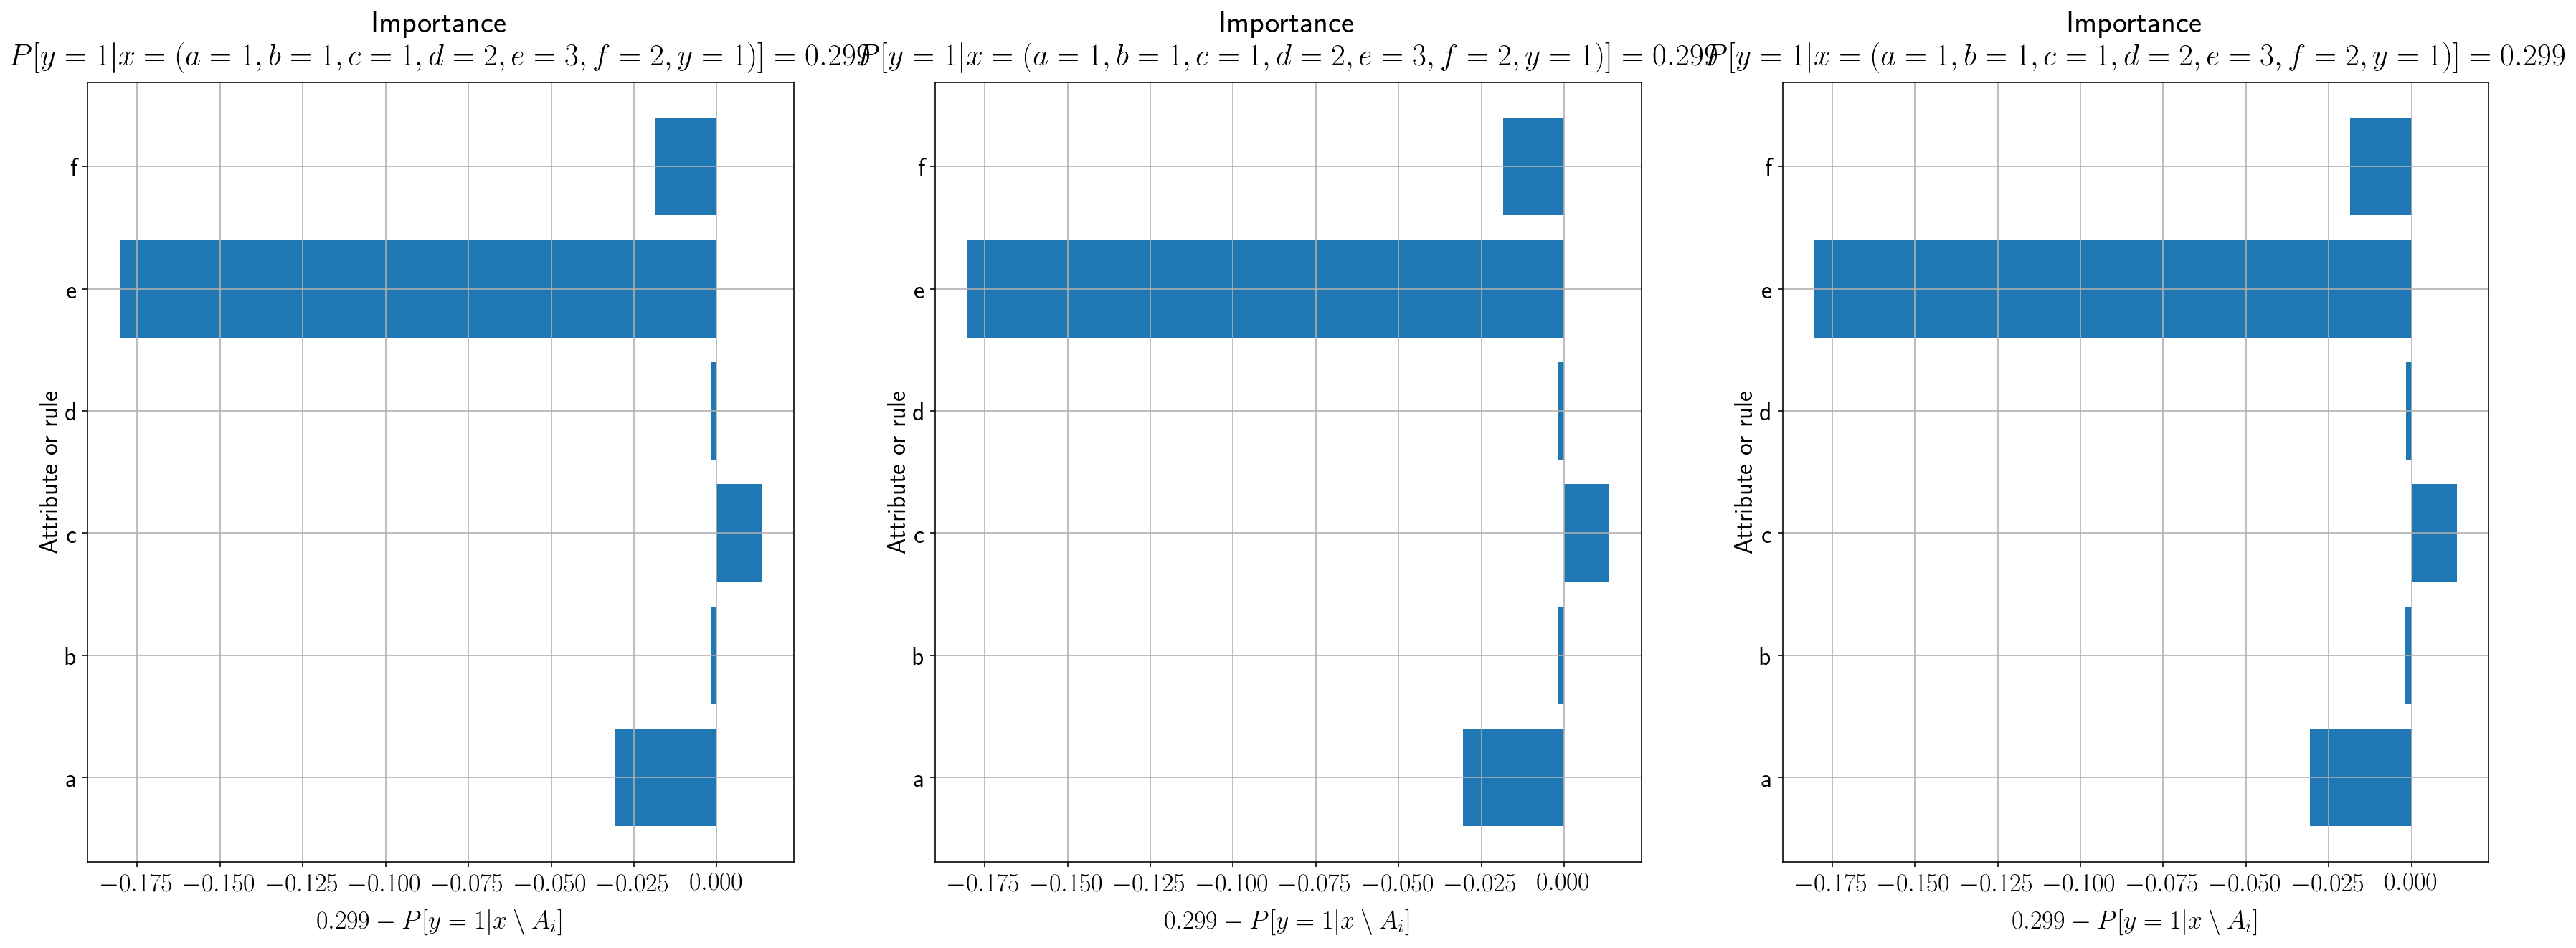

Instance 1
compute_lace_step k=21 0.01
final rules []
compute_lace_step k=42 0.01
final rules []
compute_lace_step k=63 0.01
final rules []
compute_lace_step k=84 0.01
final rules []
compute_lace_step k=105 0.01
final rules []
compute_lace_step k=126 0.01
final rules []
compute_lace_step k=147 0.01
final rules []
compute_lace_step k=168 0.01
final rules []
compute_lace_step k=189 0.01
final rules []
compute_lace_step k=210 0.01
final rules []
explain_instance errors: 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01
compute_lace_step k=21 0.05
final rules []
compute_lace_step k=42 0.05
final rules []
compute_lace_step k=63 0.05
final rules []
compute_lace_step k=84 0.05
final rules []
compute_lace_step k=105 0.05
final rules []
compute_lace_step k=126 0.05
final rules []
compute_lace_step k=147 0.05
final rules []
compute_lace_step k=168 0.05
final rules []
compute_lace_step k=189 0.05
final rules []
compute_lace_step k=210 0.0

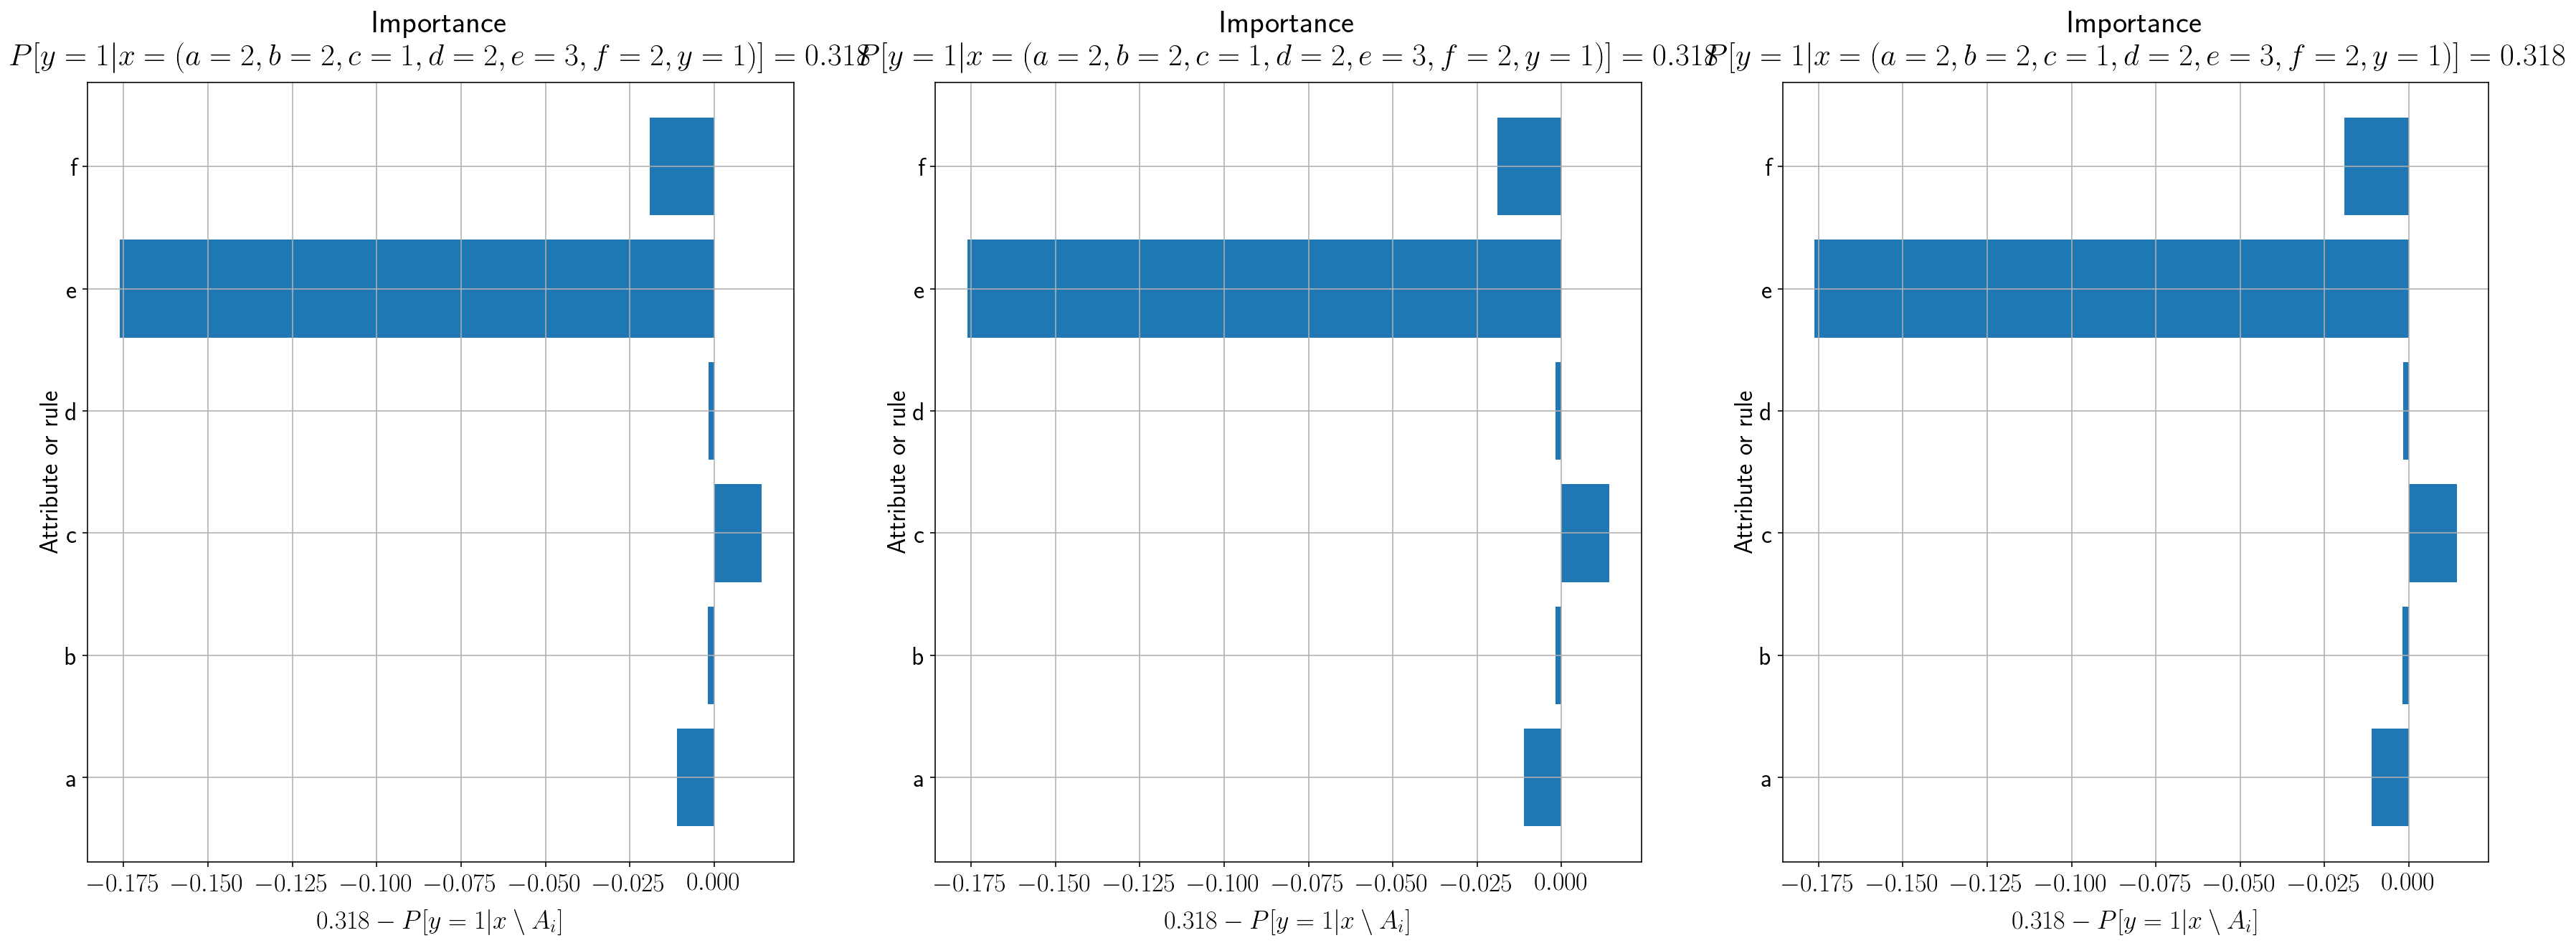

Instance 2
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('c', '2'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
compute_lace_step k=42 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 28}
{'body': [('e', '2')], 'class': '0', 'sup': 15}
final rules [[5]]
compute_lace_step k=63 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 37}
{'body': [('e', '2')], 'class': '0', 'sup': 24}
{'body': [('a', '1'), ('b', '3'), ('e', '3'), ('f', '2')], 'class': '0', 'sup': 3}
final rules [[5]]
compute_lace_step k=84 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 46}
{'body': [('e', '2')], 'class': '0', 'sup': 31}
{'body': [('e', '3')], 'class': '0', 'sup': 8}
final rules [[5]]
compute_lace_step k=105 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 55}
{'body': [('e', '2')], 'class': '0', 'sup': 38}
{'body': [('e', '3')], 'class': '0', 'sup': 13}
final rules [[5]]
compute_lace_step k=126 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 61}
{'body': [('

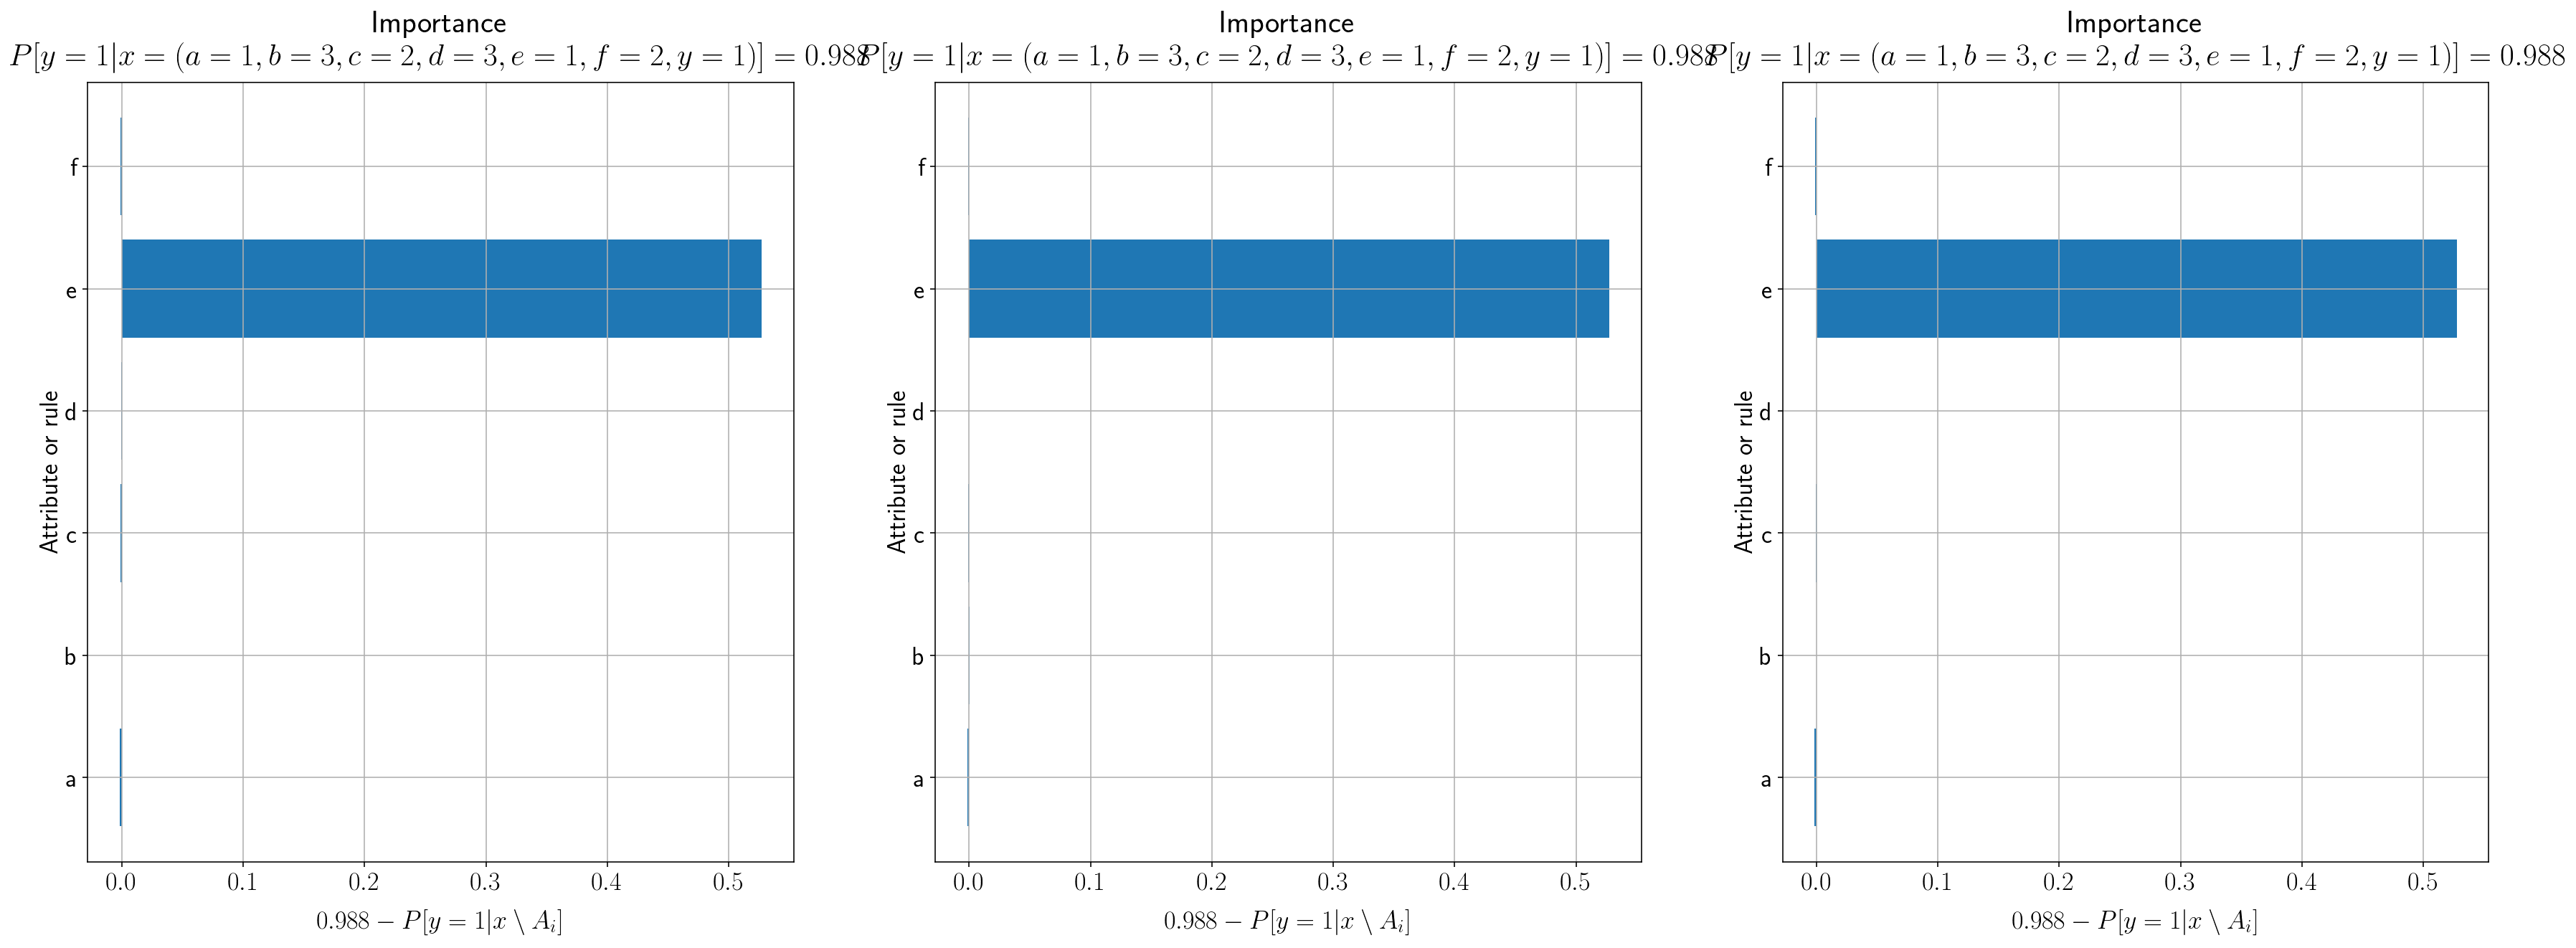

Instance 3
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('d', '3'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
explain_instance errors: 8.865E-03
compute_lace_step k=21 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('d', '3'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
explain_instance errors: 8.865E-03
compute_lace_step k=21 0.075
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('d', '3'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
explain_instance errors: 8.865E-03


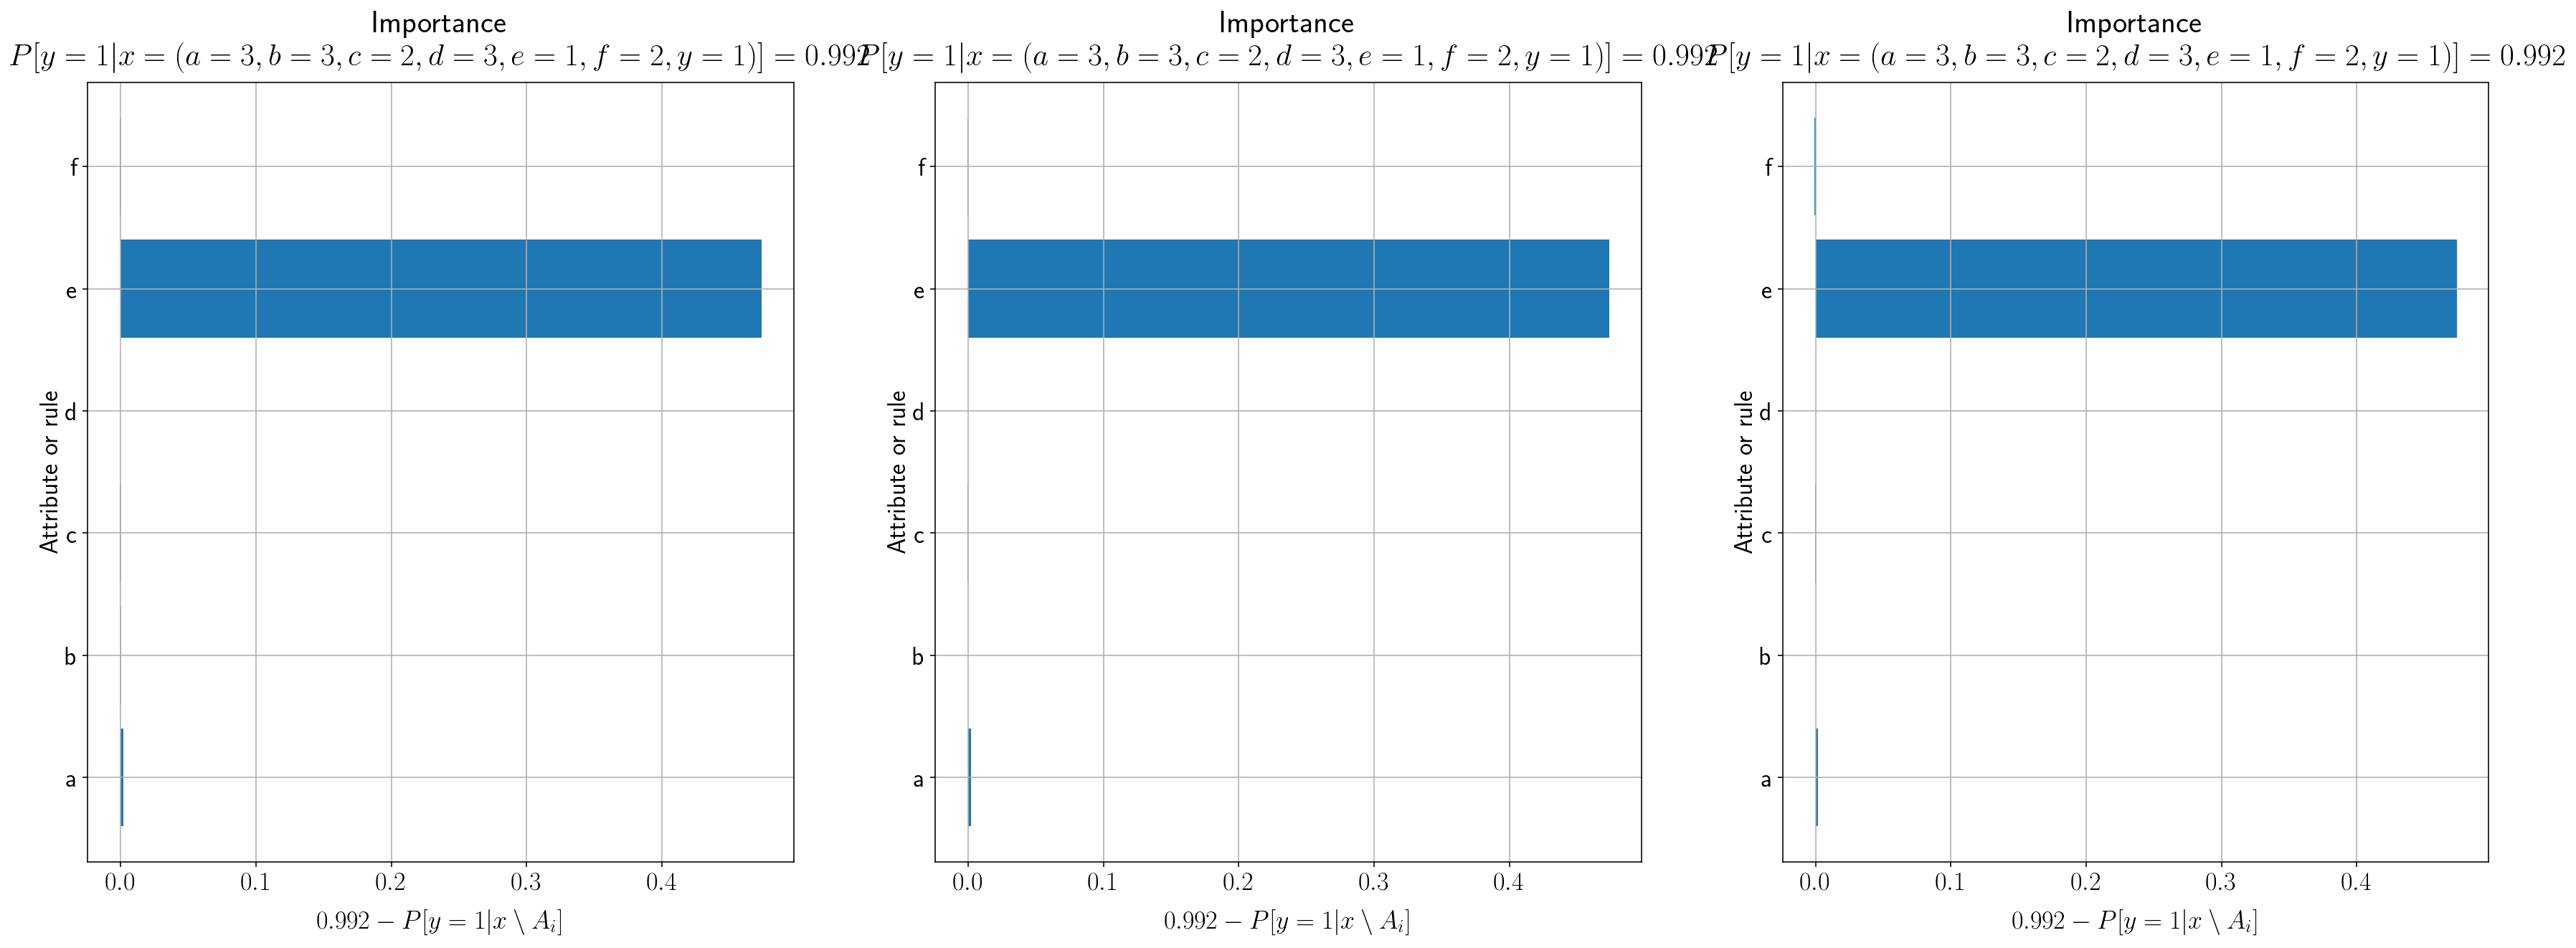

In [6]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_nb", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Random Forest

Instance 0
compute_lace_step k=21 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 12}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('f', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2]]
compute_lace_step k=42 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 23}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
final rules [[1, 2]]
compute_lace_step k=63 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 33}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 17}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
{'body': [('f', '1')], 'class': '1', 'sup': 17}
final rules [[1, 2]]
compute_lace_step k=84 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 35}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b'

compute_lace_step k=21 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 12}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('f', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2]]
compute_lace_step k=42 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 23}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
final rules [[1, 2]]
compute_lace_step k=63 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 33}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 17}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
{'body': [('f', '1')], 'class': '1', 'sup': 17}
final rules [[1, 2]]
compute_lace_step k=84 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 35}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '2'),

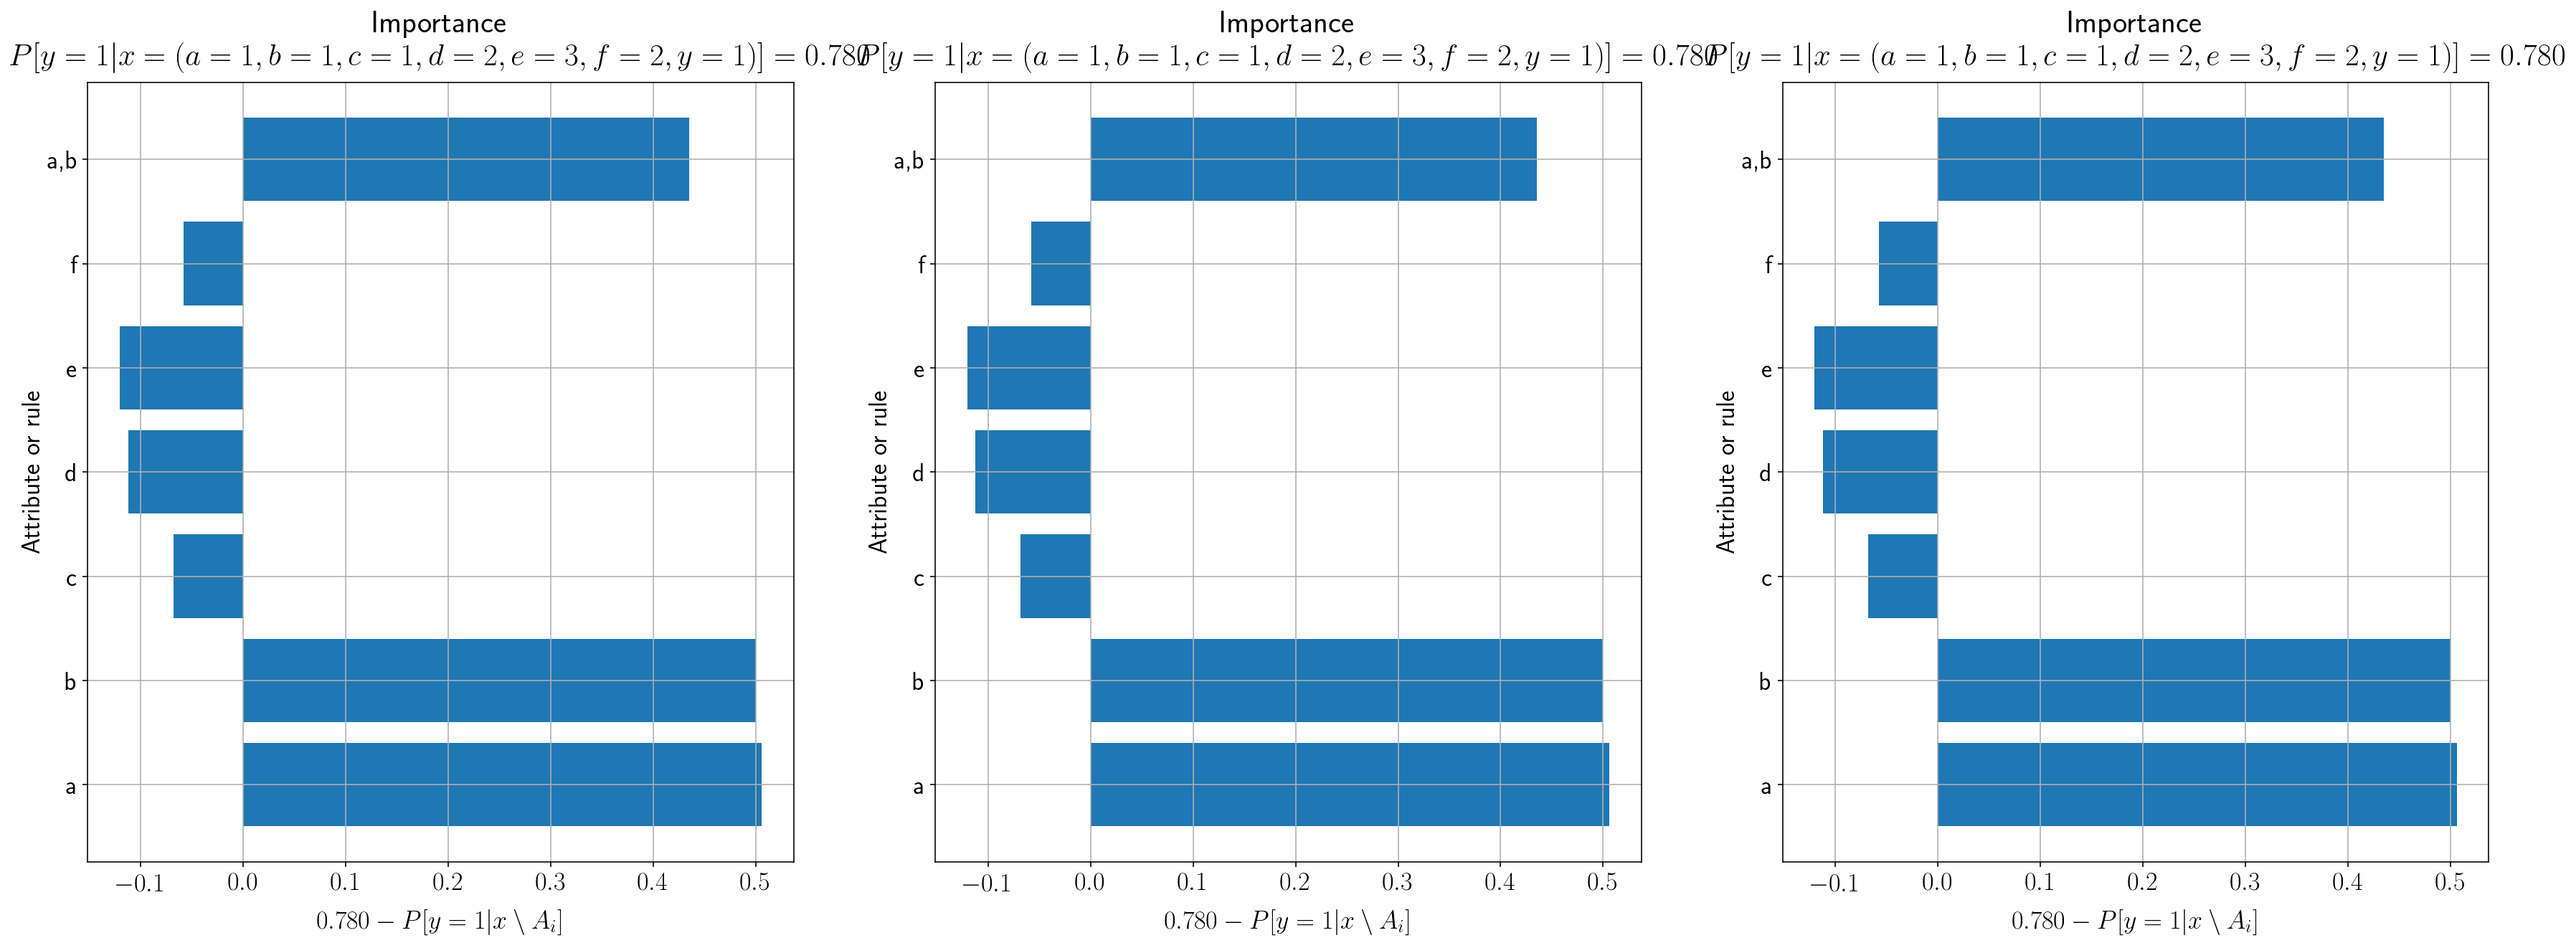

Instance 1
compute_lace_step k=21 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 14}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('d', '2'), ('f', '2')], 'class': '0', 'sup': 3}
{'body': [('a', '3'), ('b', '2'), ('c', '1'), ('d', '2')], 'class': '0', 'sup': 3}
{'body': [('a', '1'), ('b', '2'), ('c', '1'), ('e', '3'), ('f', '2')], 'class': '0', 'sup': 2}
final rules [[1, 2]]
compute_lace_step k=42 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('b', '1')], 'class': '0', 'sup': 8}
{'body': [('a', '3'), ('b', '2'), ('c', '1')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 6}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 5}
final rules [[1, 2]]
compute_lace_step k=63 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 25}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 9}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup':

{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 36}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 36}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 24}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 22}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 20}
{'body': [('b', '3'), ('d', '3')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '3')], 'class': '0', 'sup': 10}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 7}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 7}
{'body': [('b', '1'), ('c', '2')], 'class': '0', 'sup': 16}
{'body': [('b', '1'), ('e', '4')], 'class': '0', 'sup': 14}
{'body': [('b', '1')], 'class': '0', 'sup': 43}
final rules [[1, 2]]
compute_lace_step k=189 0.05
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 37}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 36}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 27}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 24}
{'bo

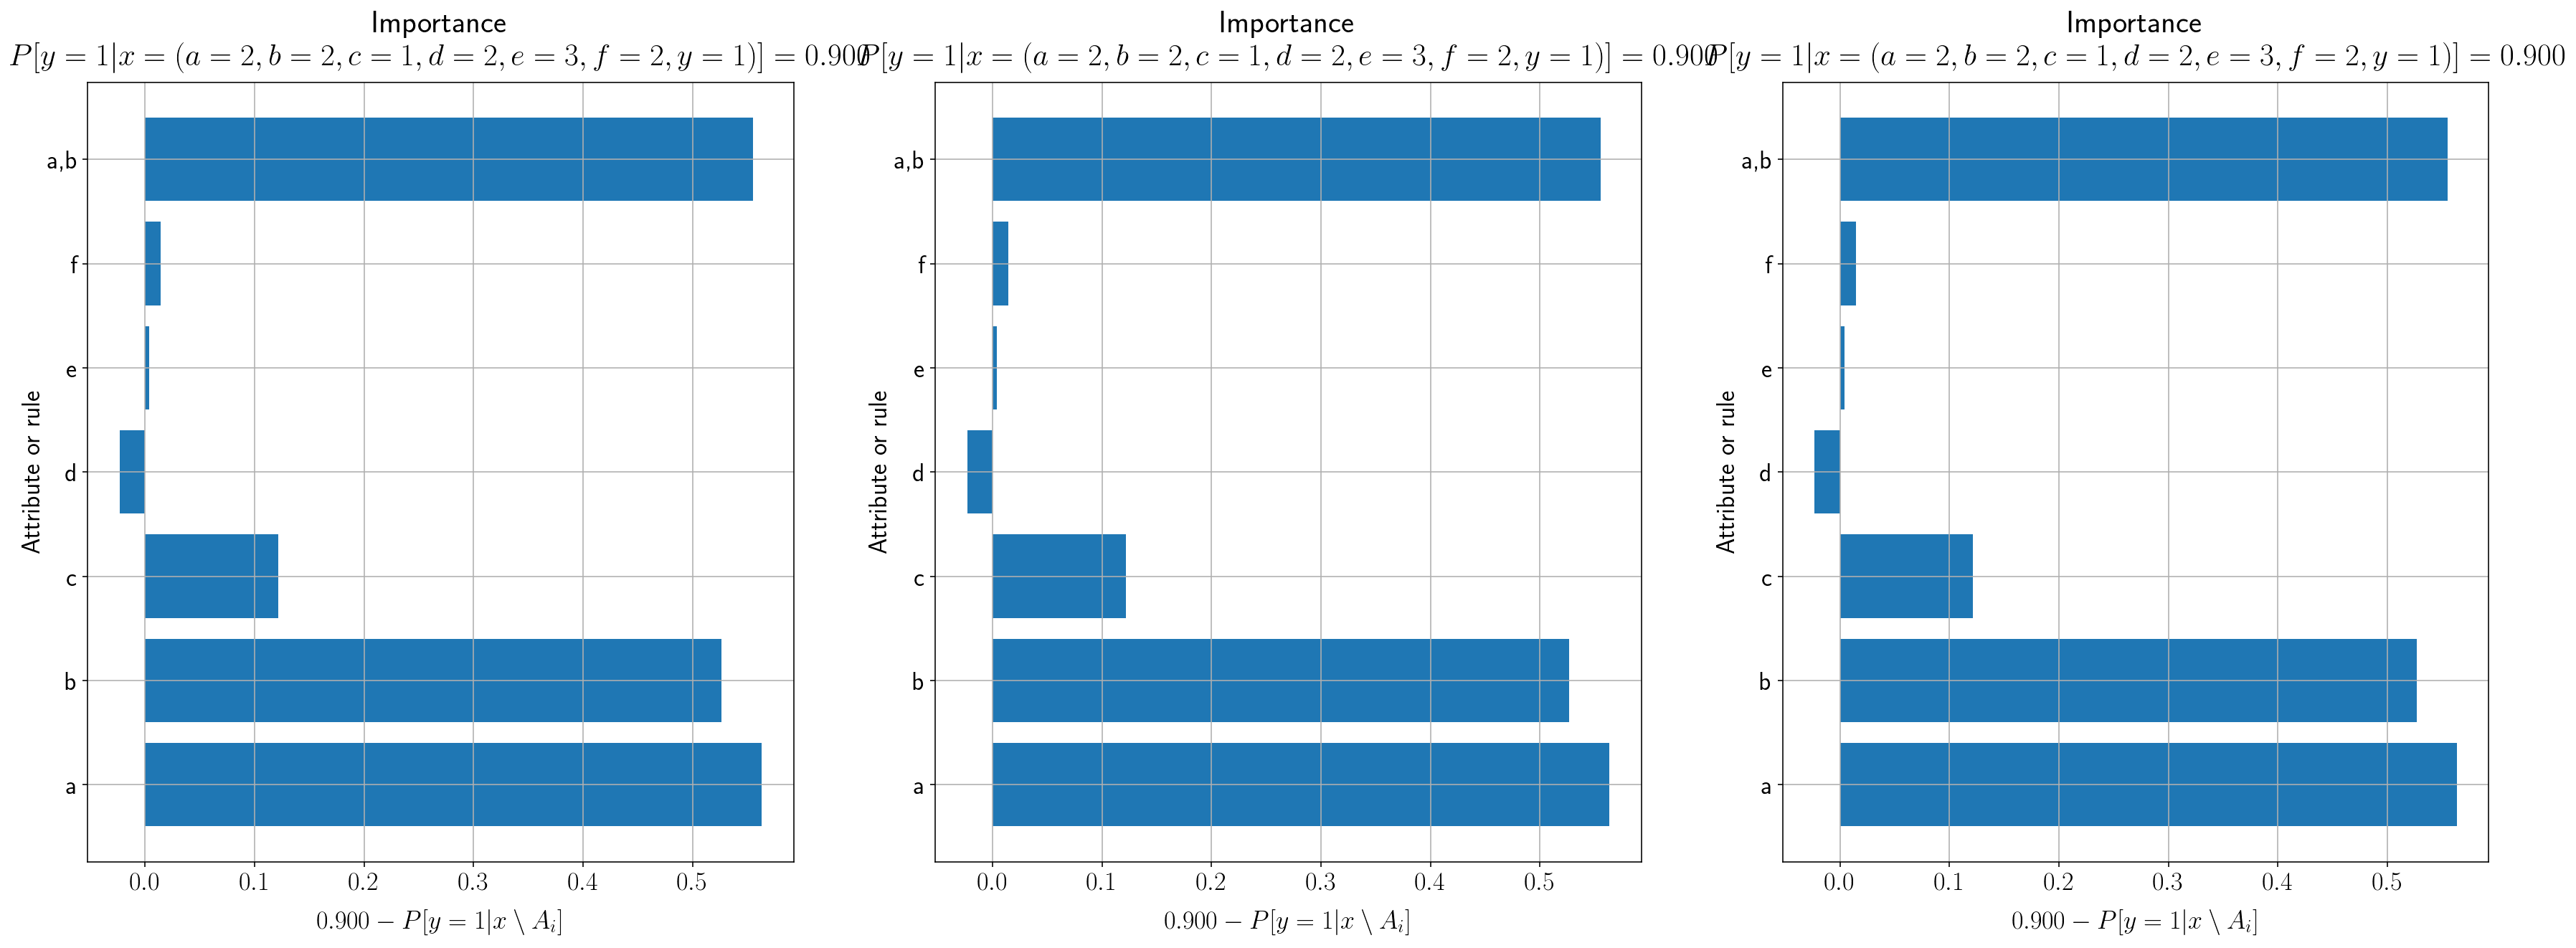

Instance 2
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('c', '2'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
compute_lace_step k=42 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 28}
{'body': [('b', '3'), ('e', '2')], 'class': '0', 'sup': 11}
{'body': [('a', '1'), ('e', '2')], 'class': '0', 'sup': 10}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 8}
final rules [[5]]
compute_lace_step k=63 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 37}
{'body': [('b', '3'), ('e', '2')], 'class': '0', 'sup': 15}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 14}
{'body': [('a', '1'), ('e', '2')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '3'), ('e', '3'), ('f', '2')], 'class': '0', 'sup': 3}
final rules [[5]]
compute_lace_step k=84 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 46}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 10

{'body': [('e', '1')], 'class': '1', 'sup': 55}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 18}
{'body': [('e', '3')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 12}
{'body': [('b', '3'), ('c', '1'), ('e', '2')], 'class': '0', 'sup': 8}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 8}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 8}
{'body': [('a', '1'), ('c', '1'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '2'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '1'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 5}
{'body': [('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 3}
{'body': [('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
compute_lace_step k=126 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 61}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 20}
{'body': [('a', '1'), ('e', '3')], 'c

{'body': [('e', '1')], 'class': '1', 'sup': 69}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 21}
{'body': [('a', '1'), ('e', '3')], 'class': '0', 'sup': 19}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 15}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 14}
{'body': [('b', '3'), ('e', '3')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 11}
{'body': [('d', '1'), ('e', '2')], 'class': '0', 'sup': 8}
{'body': [('a', '1'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '2'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '3'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 4}
{'body': [('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 7}
{'body': [('e', '2'), ('f', '2')], 'class': '0', 'sup': 22}
final rules [[5]]
compute_lace_step k=168 0.075
{'body': [('e', '1')], 'class': '1', 'sup': 75}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 23}
{'body': 

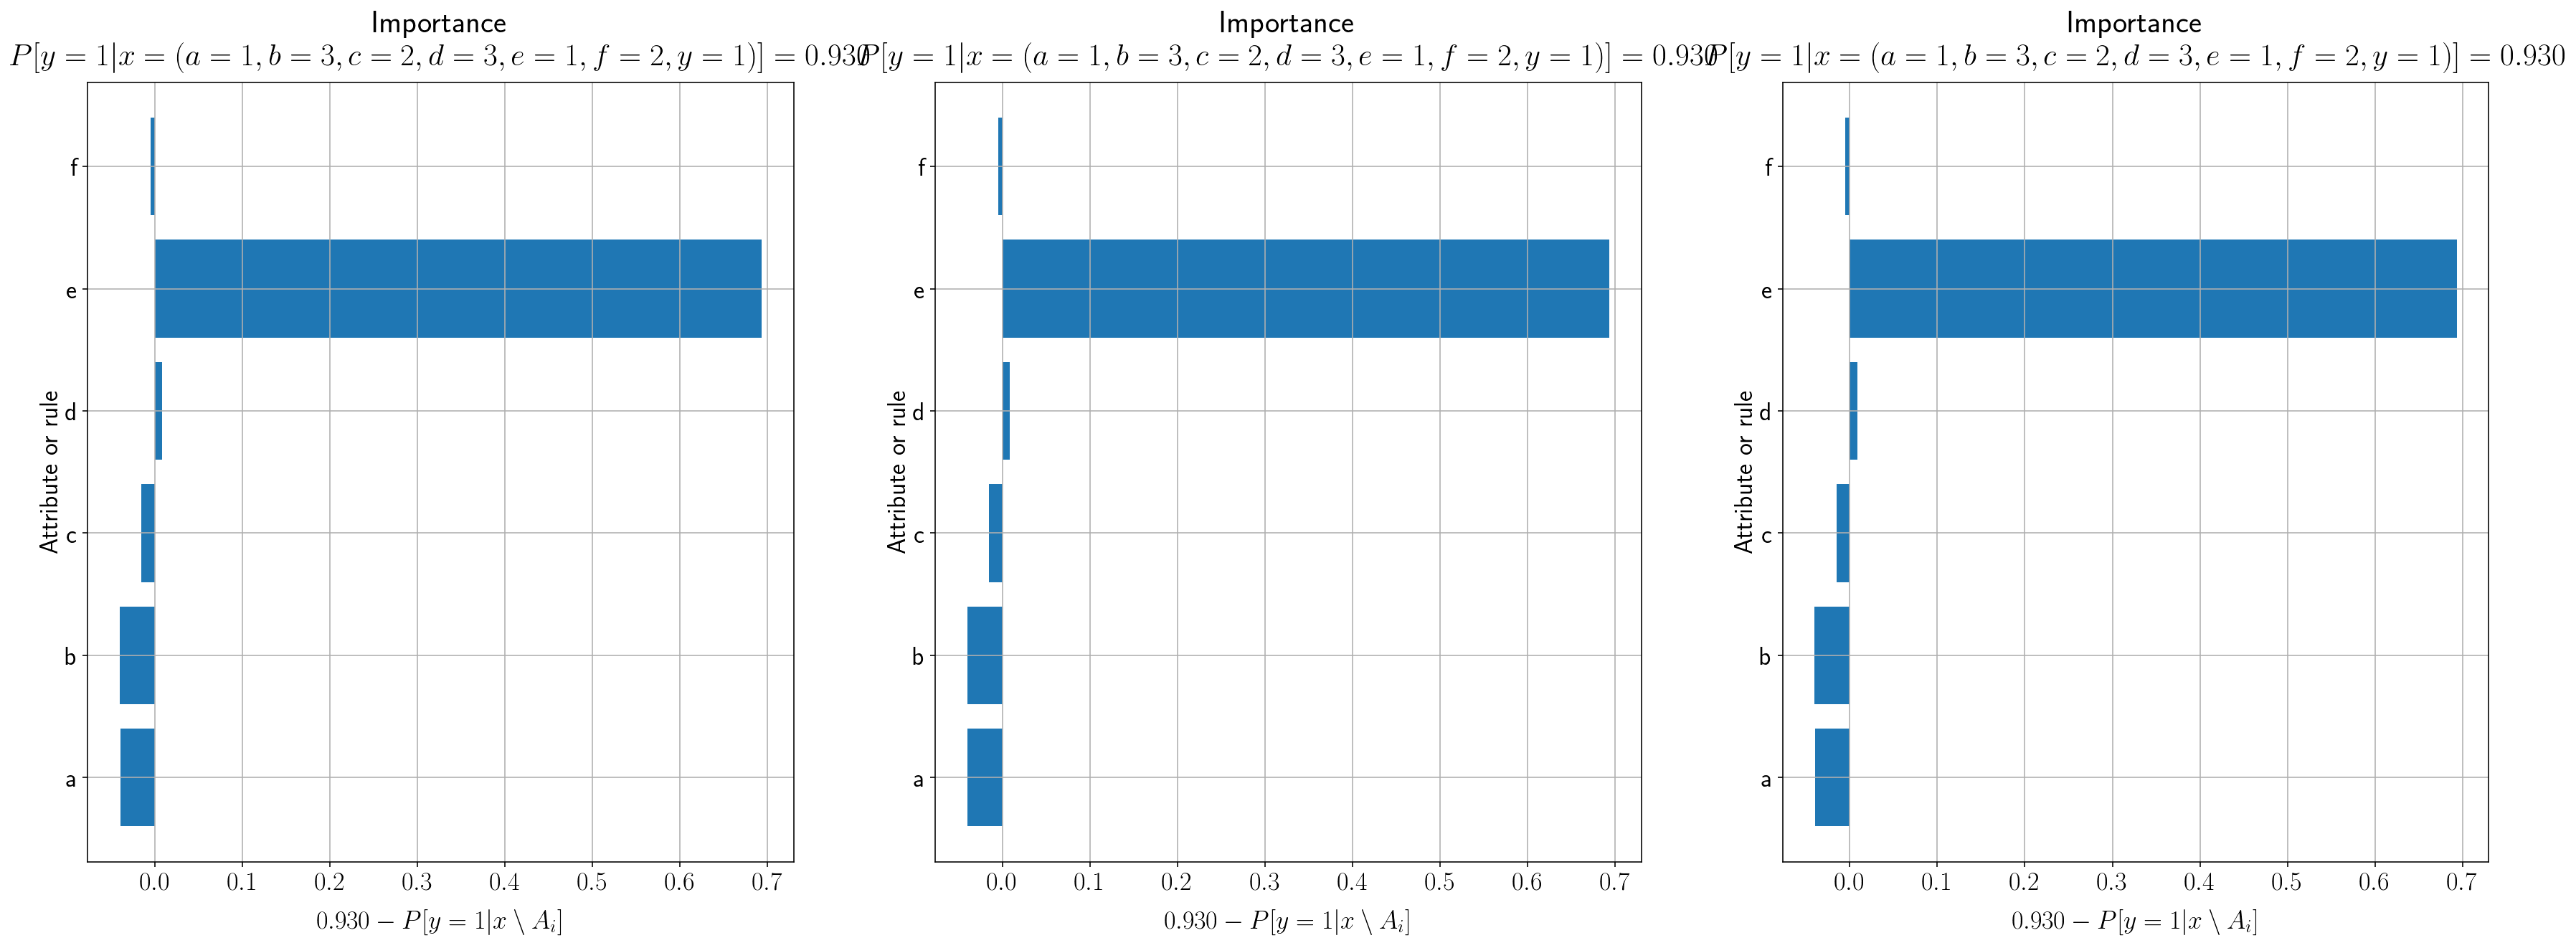

Instance 3
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('a', '3'), ('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
{'body': [('a', '2'), ('b', '3'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
final rules [[5]]
compute_lace_step k=42 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 27}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 18}
{'body': [('a', '3'), ('b', '2'), ('d', '3'), ('e', '2')], 'class': '0', 'sup': 4}
{'body': [('a', '2'), ('b', '3'), ('d', '3'), ('e', '2')], 'class': '0', 'sup': 3}
final rules [[1, 2], [1, 2, 5], [5]]
explain_instance errors: 4.356E-01, 1.783E-02
compute_lace_step k=21 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('a', '3'), ('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
{'body': [('a', '2'), ('b', '3'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
final 

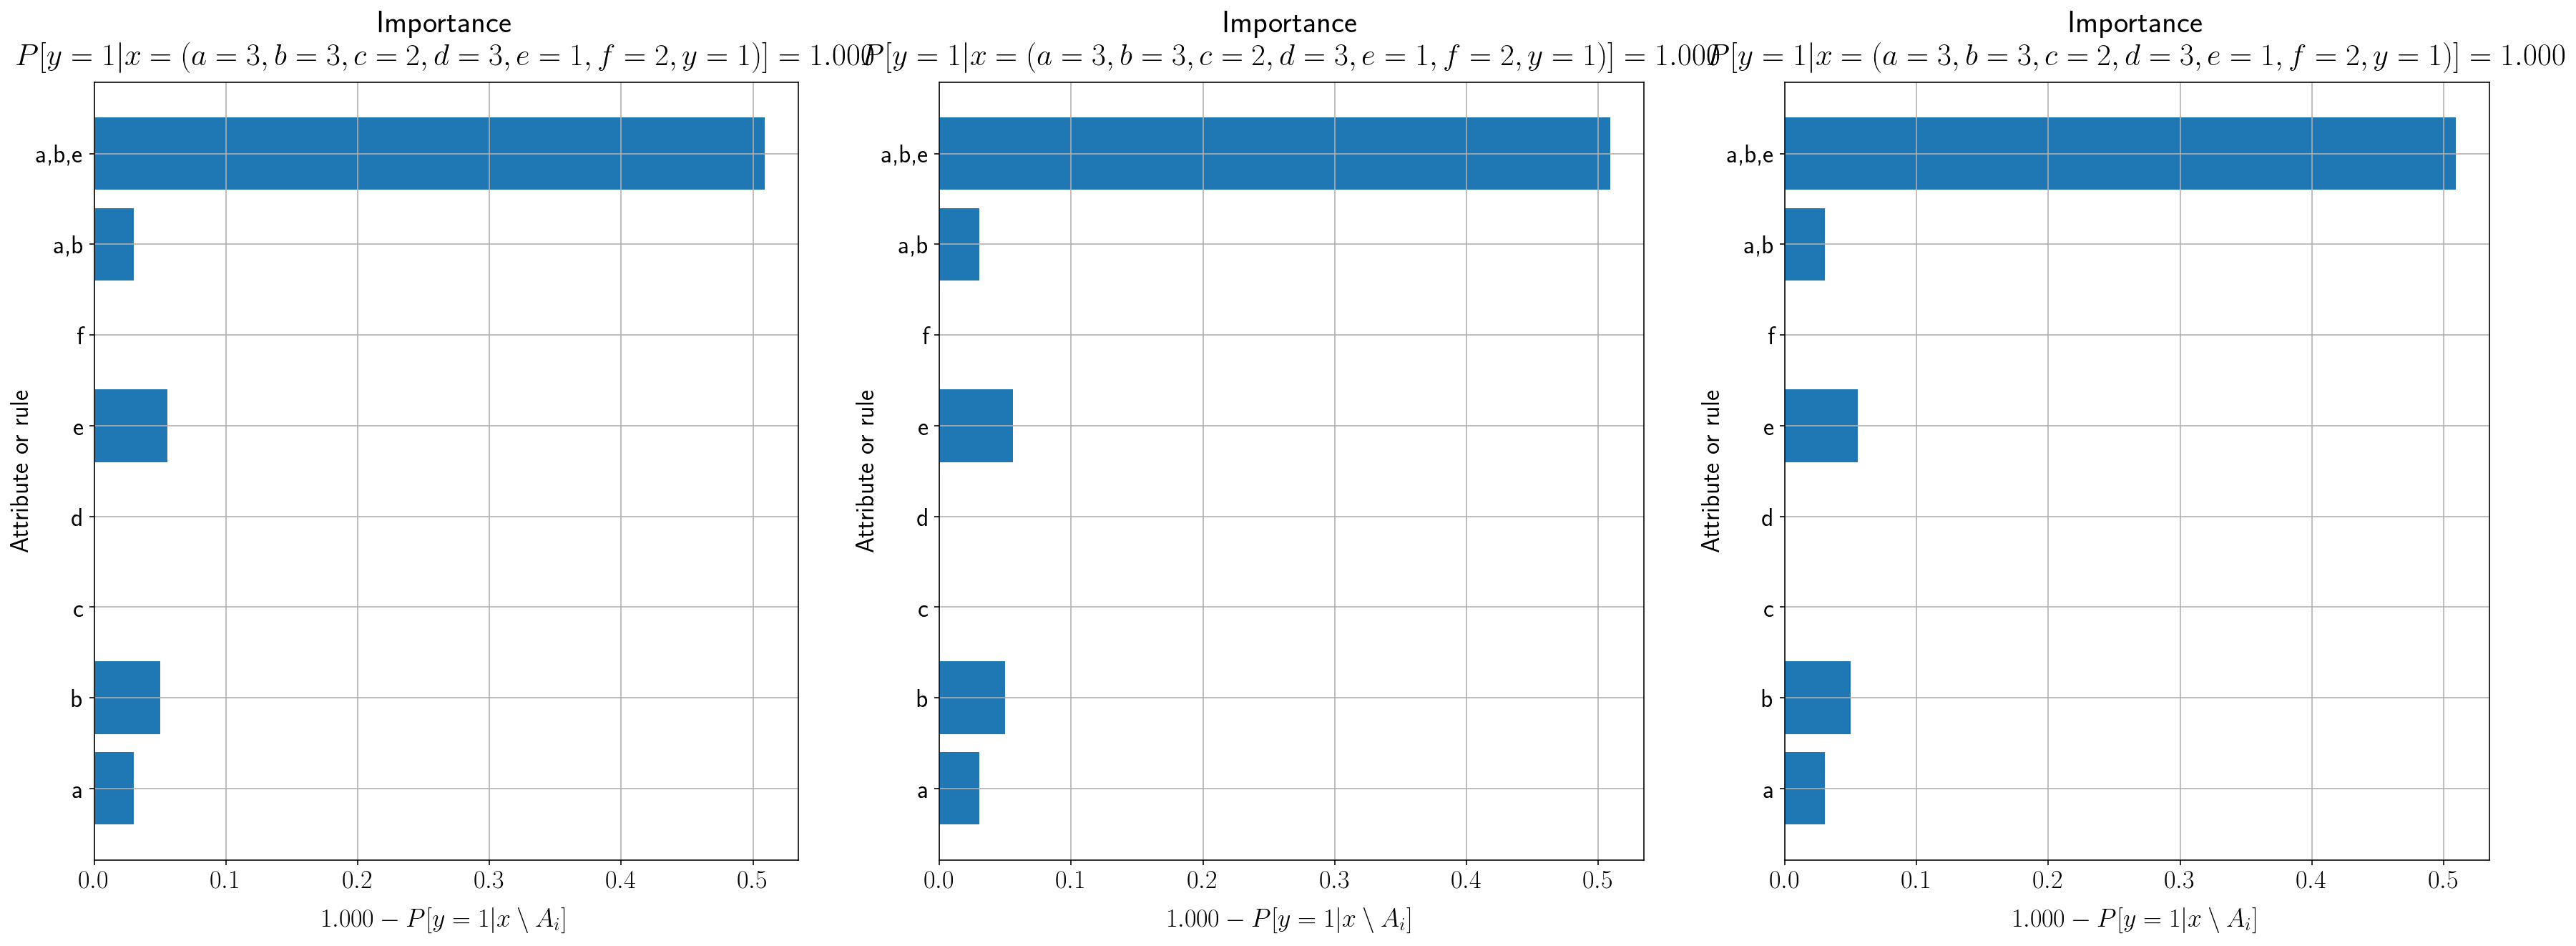

In [7]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Neural Network

Instance 0
compute_lace_step k=21 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 12}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('f', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2]]
compute_lace_step k=42 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 23}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
final rules [[1, 2]]
compute_lace_step k=63 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 33}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 17}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
{'body': [('f', '1')], 'class': '1', 'sup': 17}
final rules [[1, 2]]
compute_lace_step k=84 0.01
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 35}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b'

compute_lace_step k=21 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 12}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('f', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2]]
compute_lace_step k=42 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 23}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
final rules [[1, 2]]
compute_lace_step k=63 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 33}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 17}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 9}
{'body': [('f', '1')], 'class': '1', 'sup': 17}
final rules [[1, 2]]
compute_lace_step k=84 0.075
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 35}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '2'),

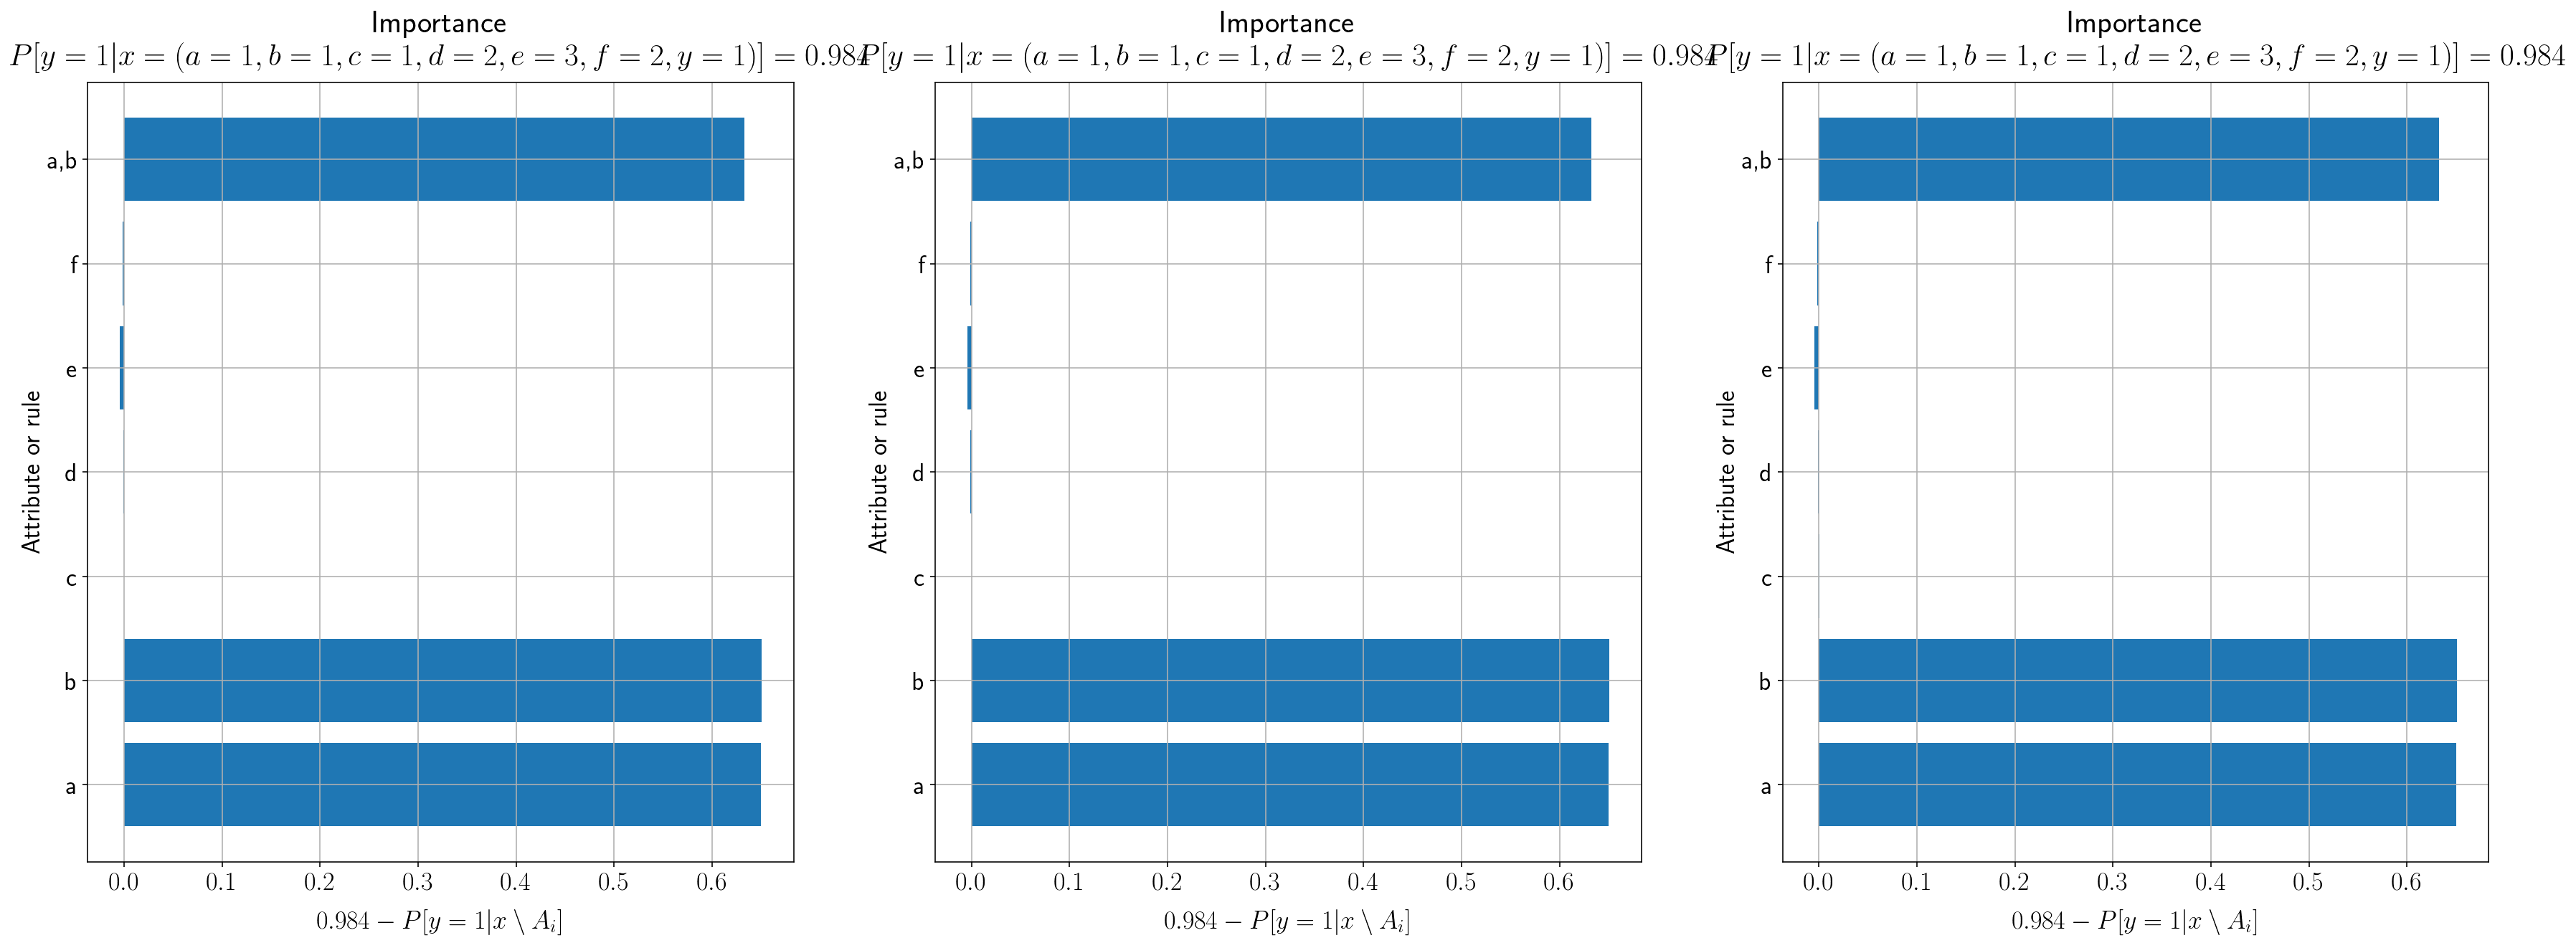

Instance 1
compute_lace_step k=21 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 14}
{'body': [('a', '2'), ('b', '1'), ('c', '1'), ('d', '2'), ('f', '2')], 'class': '0', 'sup': 3}
{'body': [('a', '3'), ('b', '2'), ('c', '1'), ('d', '2')], 'class': '0', 'sup': 3}
{'body': [('a', '1'), ('b', '2'), ('c', '1'), ('e', '3'), ('f', '2')], 'class': '0', 'sup': 2}
final rules [[1, 2]]
compute_lace_step k=42 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('b', '1')], 'class': '0', 'sup': 8}
{'body': [('a', '3'), ('b', '2'), ('c', '1')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 6}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 5}
final rules [[1, 2]]
compute_lace_step k=63 0.01
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 25}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 10}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 9}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup':

{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 36}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 36}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 24}
{'body': [('a', '2'), ('b', '3')], 'class': '0', 'sup': 22}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 20}
{'body': [('b', '3'), ('d', '3')], 'class': '0', 'sup': 10}
{'body': [('a', '1'), ('b', '3')], 'class': '0', 'sup': 10}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 7}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 7}
{'body': [('b', '1'), ('c', '2')], 'class': '0', 'sup': 16}
{'body': [('b', '1'), ('e', '4')], 'class': '0', 'sup': 14}
{'body': [('b', '1')], 'class': '0', 'sup': 43}
final rules [[1, 2]]
compute_lace_step k=189 0.05
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 37}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 36}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 27}
{'body': [('a', '1'), ('b', '2')], 'class': '0', 'sup': 24}
{'bo

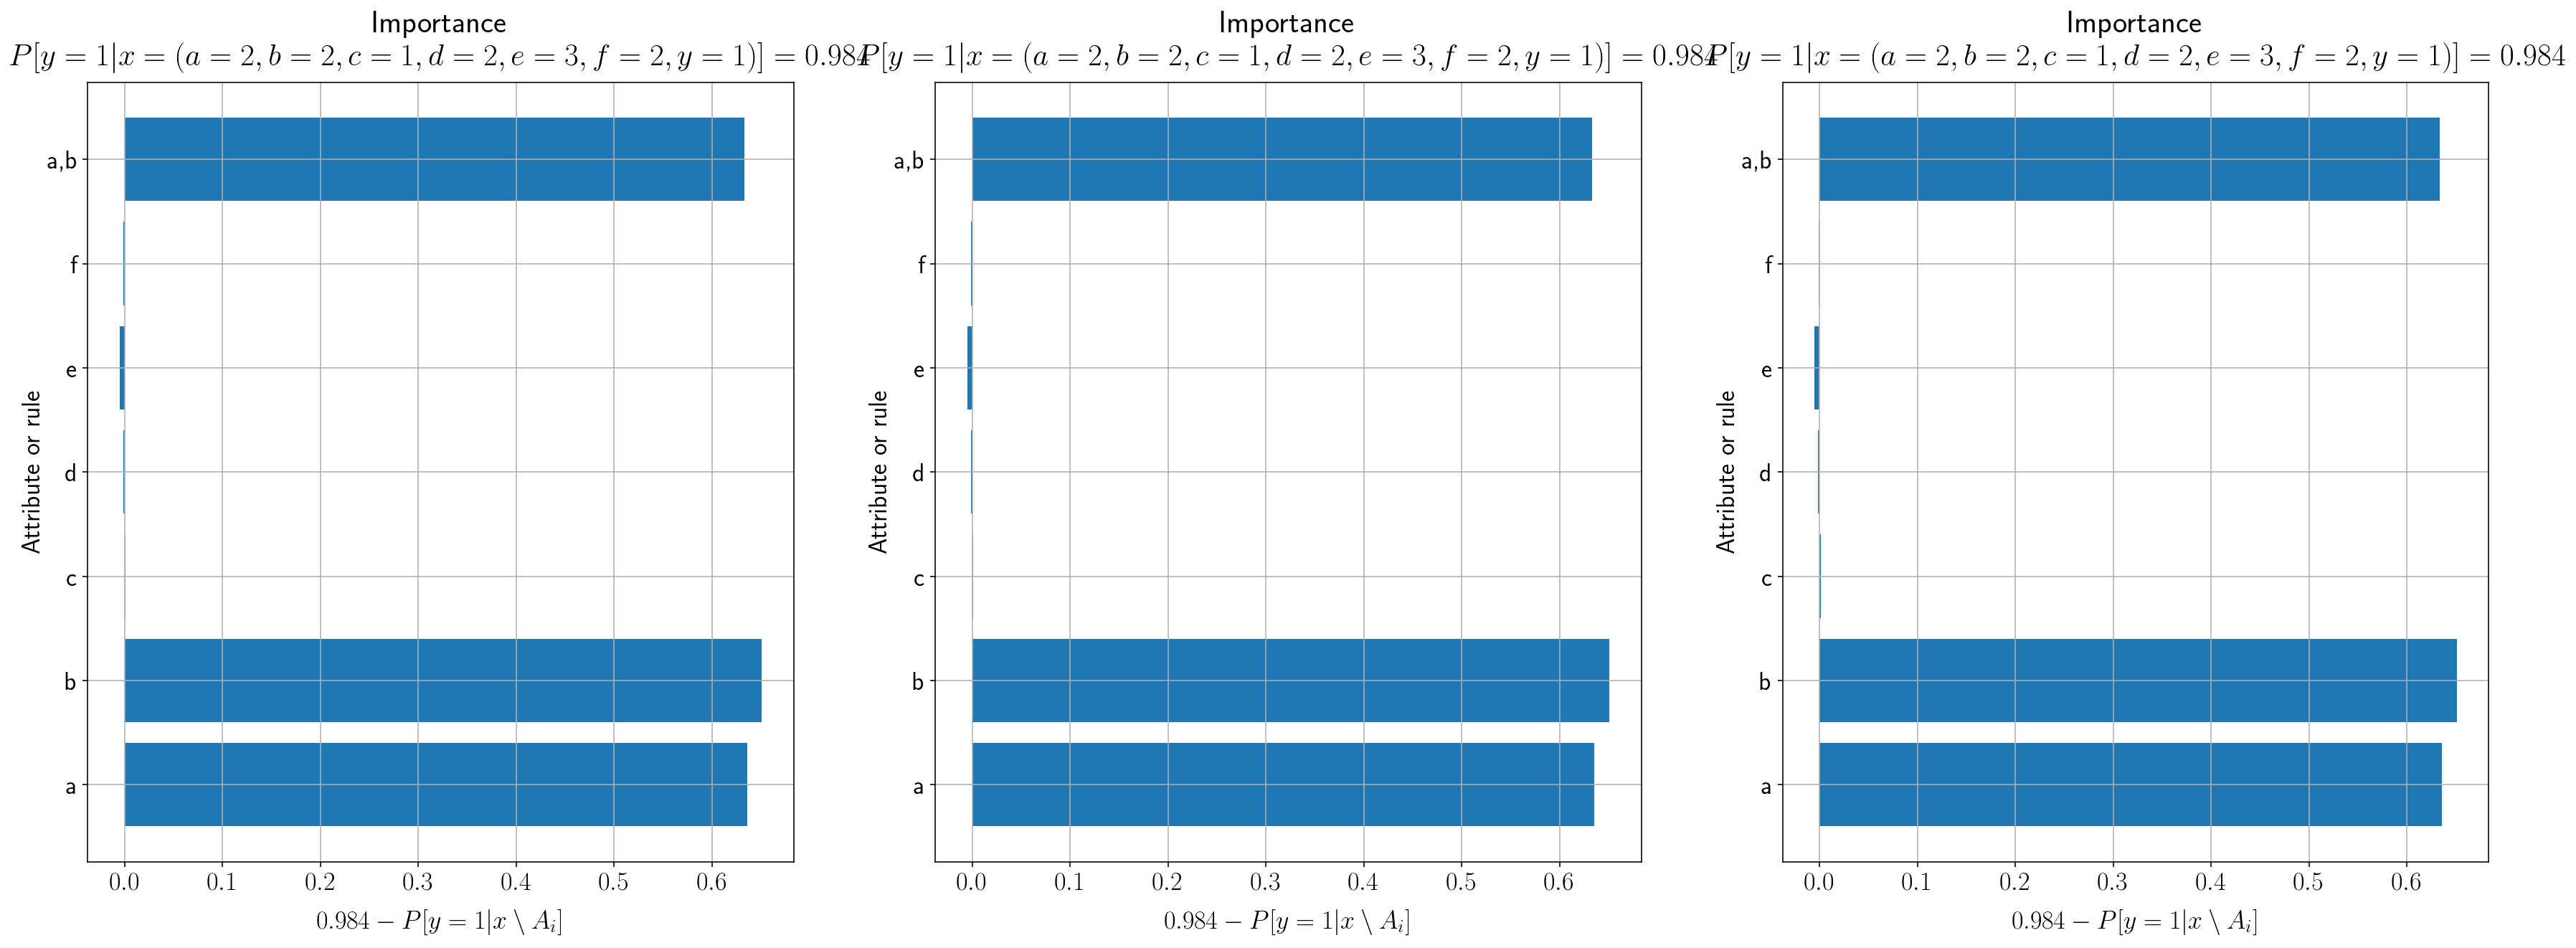

Instance 2
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('c', '2'), ('e', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
compute_lace_step k=42 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 28}
{'body': [('b', '3'), ('e', '2')], 'class': '0', 'sup': 11}
{'body': [('a', '1'), ('e', '2')], 'class': '0', 'sup': 10}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 8}
final rules [[5]]
compute_lace_step k=63 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 37}
{'body': [('b', '3'), ('e', '2')], 'class': '0', 'sup': 15}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 14}
{'body': [('a', '1'), ('e', '2')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '3'), ('e', '3'), ('f', '2')], 'class': '0', 'sup': 3}
final rules [[5]]
compute_lace_step k=84 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 46}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 10

{'body': [('e', '1')], 'class': '1', 'sup': 55}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 18}
{'body': [('e', '3')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 12}
{'body': [('b', '3'), ('c', '1'), ('e', '2')], 'class': '0', 'sup': 8}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 8}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 8}
{'body': [('a', '1'), ('c', '1'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '2'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '1'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 5}
{'body': [('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 3}
{'body': [('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 6}
final rules [[5]]
compute_lace_step k=126 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 61}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 20}
{'body': [('a', '1'), ('e', '3')], 'c

{'body': [('e', '1')], 'class': '1', 'sup': 69}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 21}
{'body': [('a', '1'), ('e', '3')], 'class': '0', 'sup': 19}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 15}
{'body': [('a', '1'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 14}
{'body': [('b', '3'), ('e', '3')], 'class': '0', 'sup': 13}
{'body': [('a', '1'), ('b', '1')], 'class': '1', 'sup': 11}
{'body': [('d', '1'), ('e', '2')], 'class': '0', 'sup': 8}
{'body': [('a', '1'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '2'), ('b', '3'), ('e', '2')], 'class': '0', 'sup': 7}
{'body': [('a', '3'), ('b', '2'), ('e', '2')], 'class': '0', 'sup': 4}
{'body': [('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 7}
{'body': [('e', '2'), ('f', '2')], 'class': '0', 'sup': 22}
final rules [[5]]
compute_lace_step k=168 0.075
{'body': [('e', '1')], 'class': '1', 'sup': 75}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 23}
{'body': 

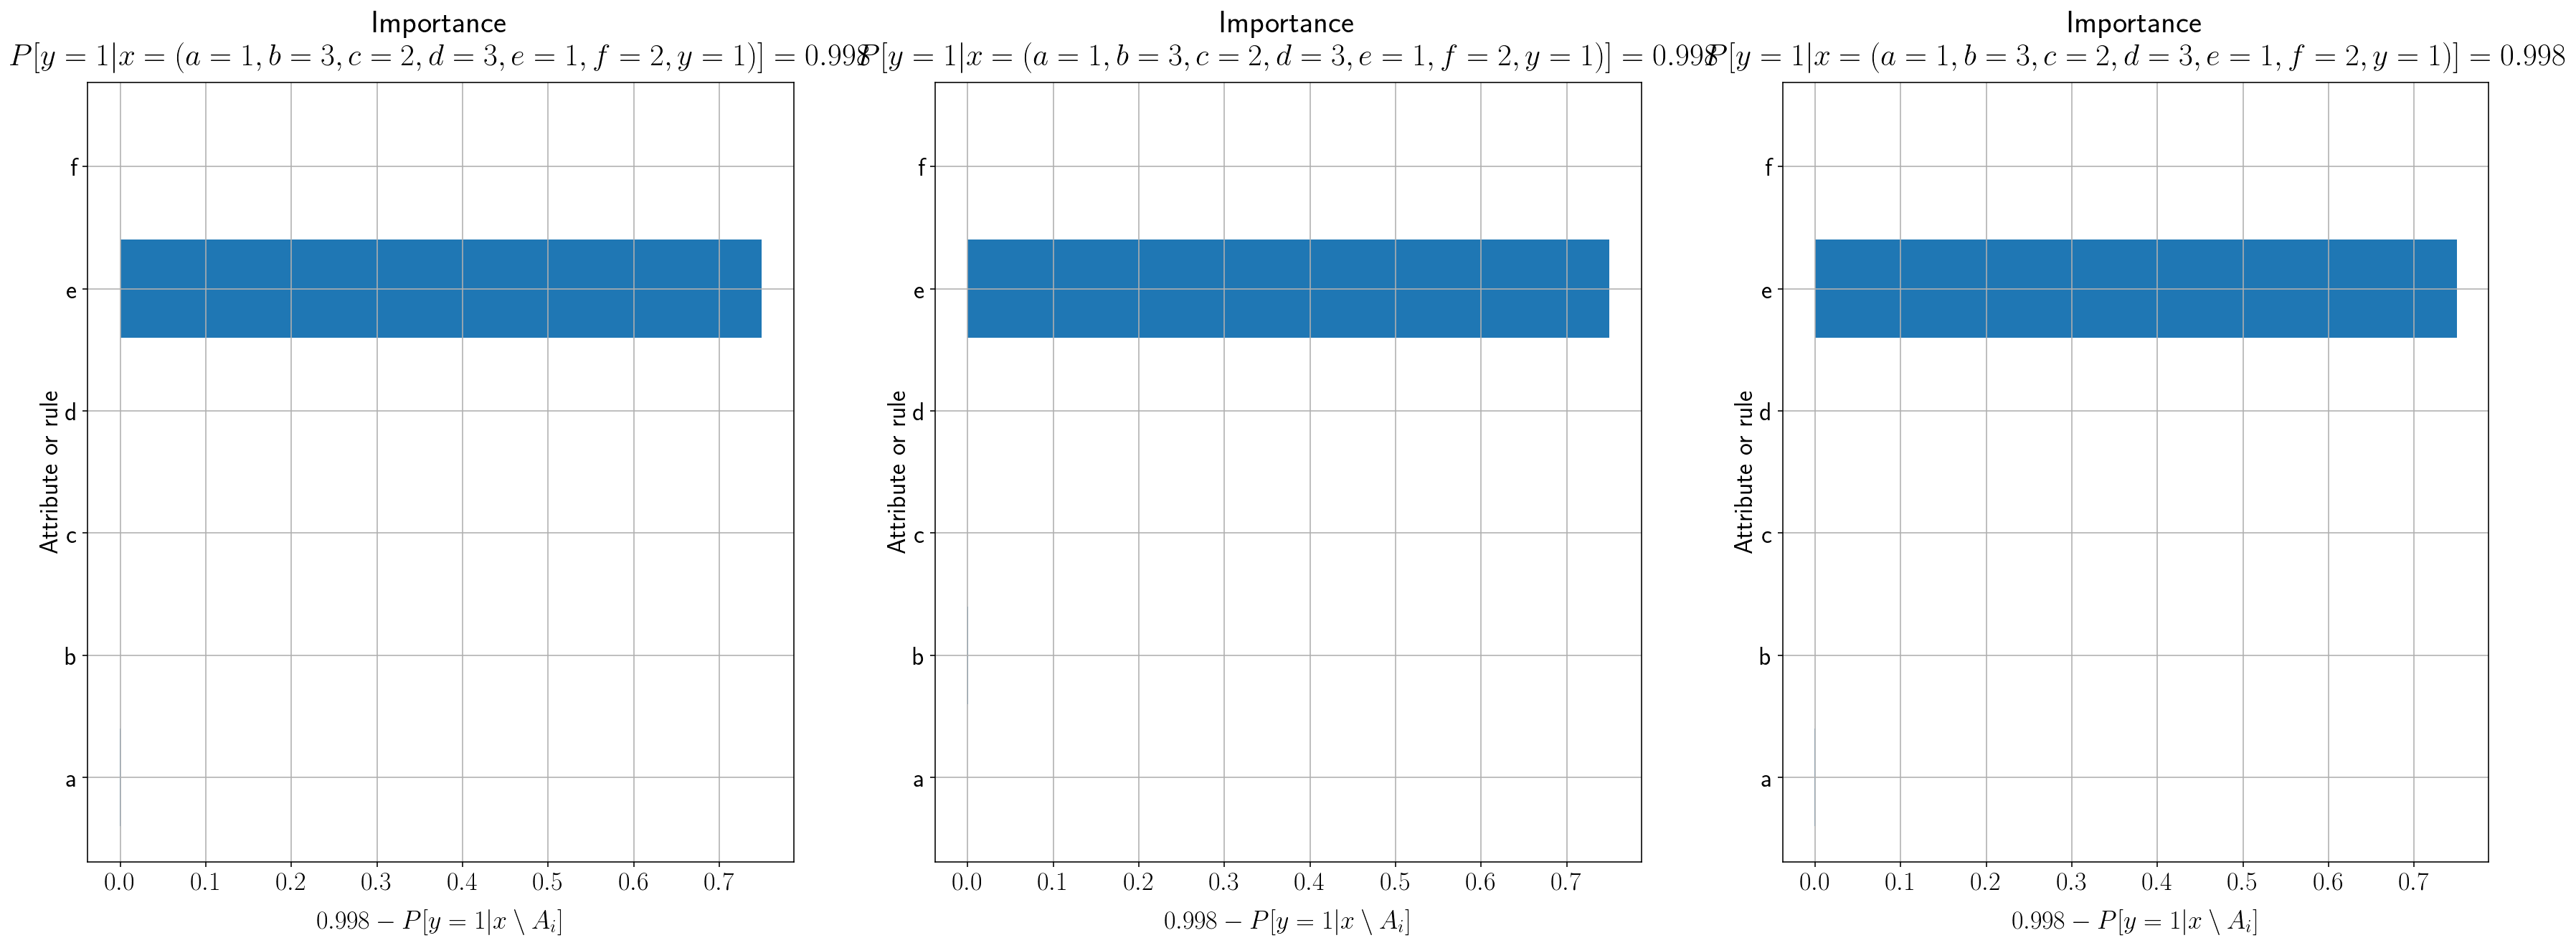

Instance 3
compute_lace_step k=21 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('a', '3'), ('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
{'body': [('a', '2'), ('b', '3'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
final rules [[5]]
compute_lace_step k=42 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 27}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 18}
{'body': [('a', '3'), ('b', '2'), ('d', '3'), ('e', '2')], 'class': '0', 'sup': 4}
{'body': [('a', '2'), ('b', '3'), ('d', '3'), ('e', '2')], 'class': '0', 'sup': 3}
final rules [[1, 2], [1, 2, 5], [5]]
explain_instance errors: 4.816E-01, 6.065E-04
compute_lace_step k=21 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 16}
{'body': [('a', '3'), ('b', '2'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
{'body': [('a', '2'), ('b', '3'), ('c', '2'), ('d', '3'), ('e', '2'), ('f', '2')], 'class': '0', 'sup': 1}
final 

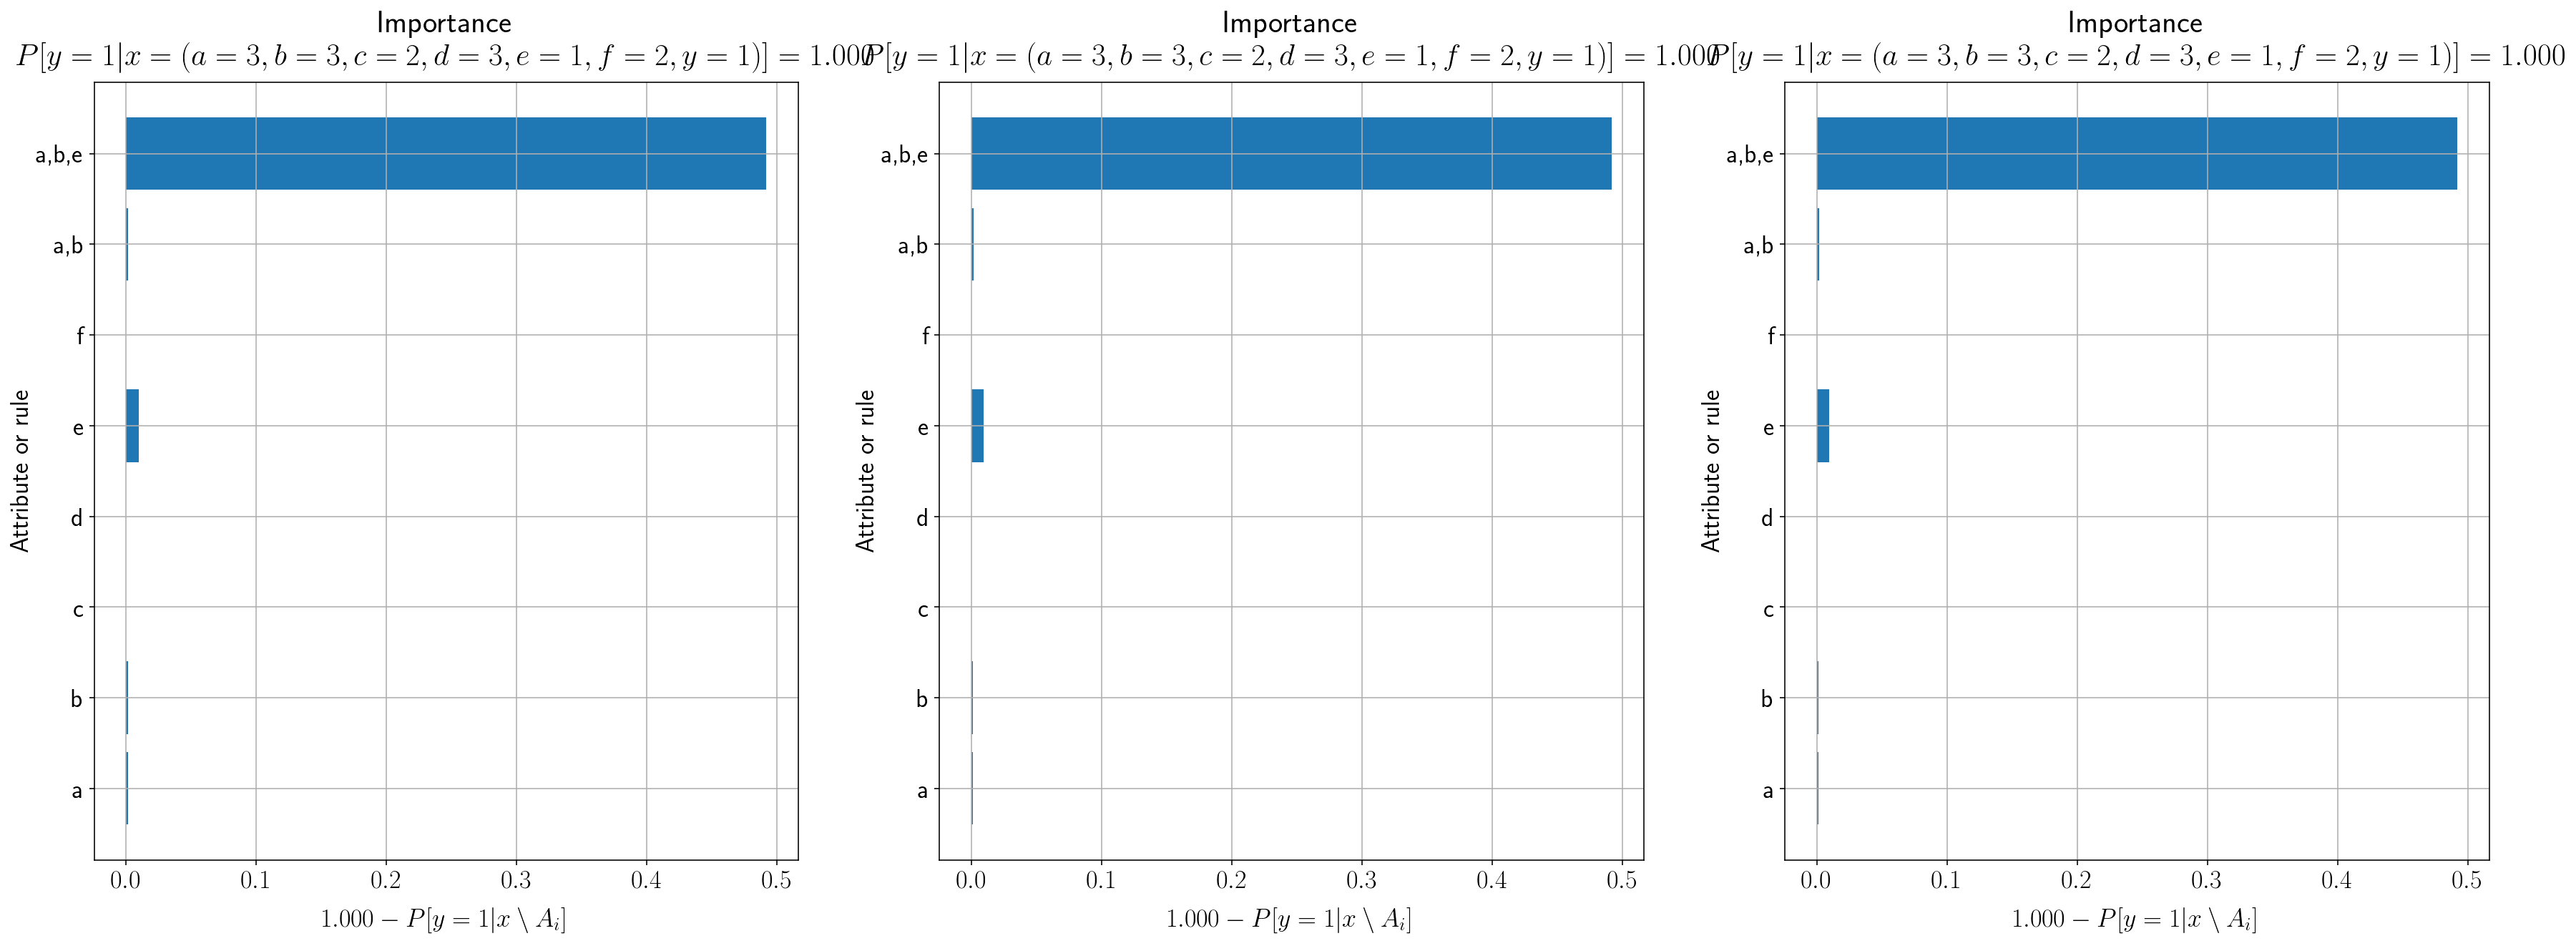

In [8]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc", 0.075))
    plt.show()

for i in range(4):
    run(i)

## Monks Extended

### Categorical Naive Bayes

Instance 0
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
final rules []
compute_lace_step k=423 0.01
final rules []
compute_lace_step k=564 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 414}
{'body': [('a', '3'), ('b', '2'), ('c', '1'), ('e', '1'), ('f', '1'), ('g', '2'), ('i', '3'), ('j', '2')], 'class': '1', 'sup': 2}
final rules [[5]]
explain_instance errors: 2.225E-01, 2.225E-01, 2.225E-01, 1.188E-02
compute_lace_step k=141 0.05
final rules []
compute_lace_step k=282 0.05
final rules []
compute_lace_step k=423 0.05
final rules []
compute_lace_step k=564 0.05
{'body': [('e', '3')], 'class': '0', 'sup': 414}
{'body': [('a', '3'), ('b', '2'), ('c', '1'), ('e', '1'), ('f', '1'), ('g', '2'), ('i', '3'), ('j', '2')], 'class': '1', 'sup': 2}
final rules [[5]]
explain_instance errors: 2.225E-01, 2.225E-01, 2.225E-01, 1.188E-02
compute_lace_step k=141 0.075
final rules []
compute_lace_step k=282 0.075
final rules []
compute_lace_step k=423 0.075
final rules []


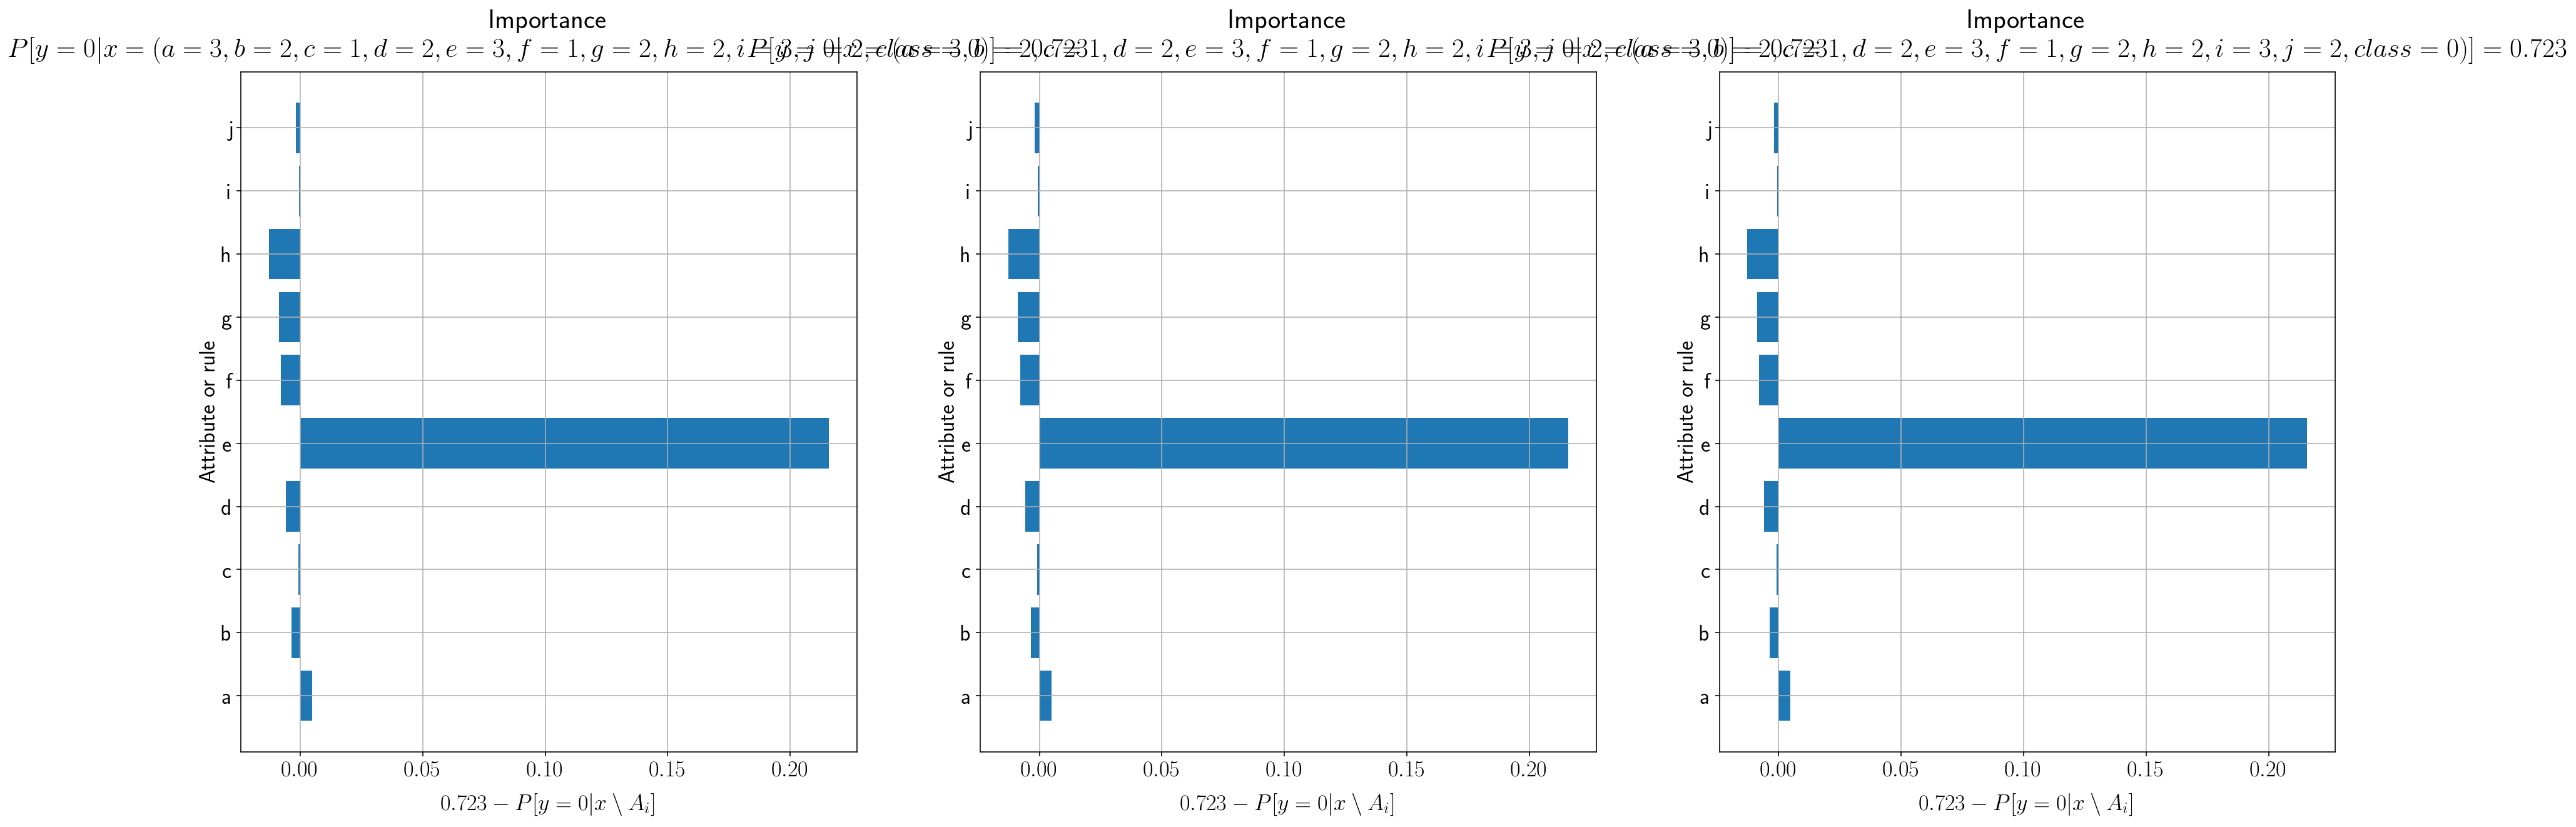

Instance 1
compute_lace_step k=141 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('e', '2')], 'class': '0', 'sup': 23}
final rules [[5]]
explain_instance errors: 8.278E-03
compute_lace_step k=141 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('e', '2')], 'class': '0', 'sup': 23}
final rules [[5]]
explain_instance errors: 8.278E-03
compute_lace_step k=141 0.075
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('e', '2')], 'class': '0', 'sup': 23}
final rules [[5]]
explain_instance errors: 8.278E-03


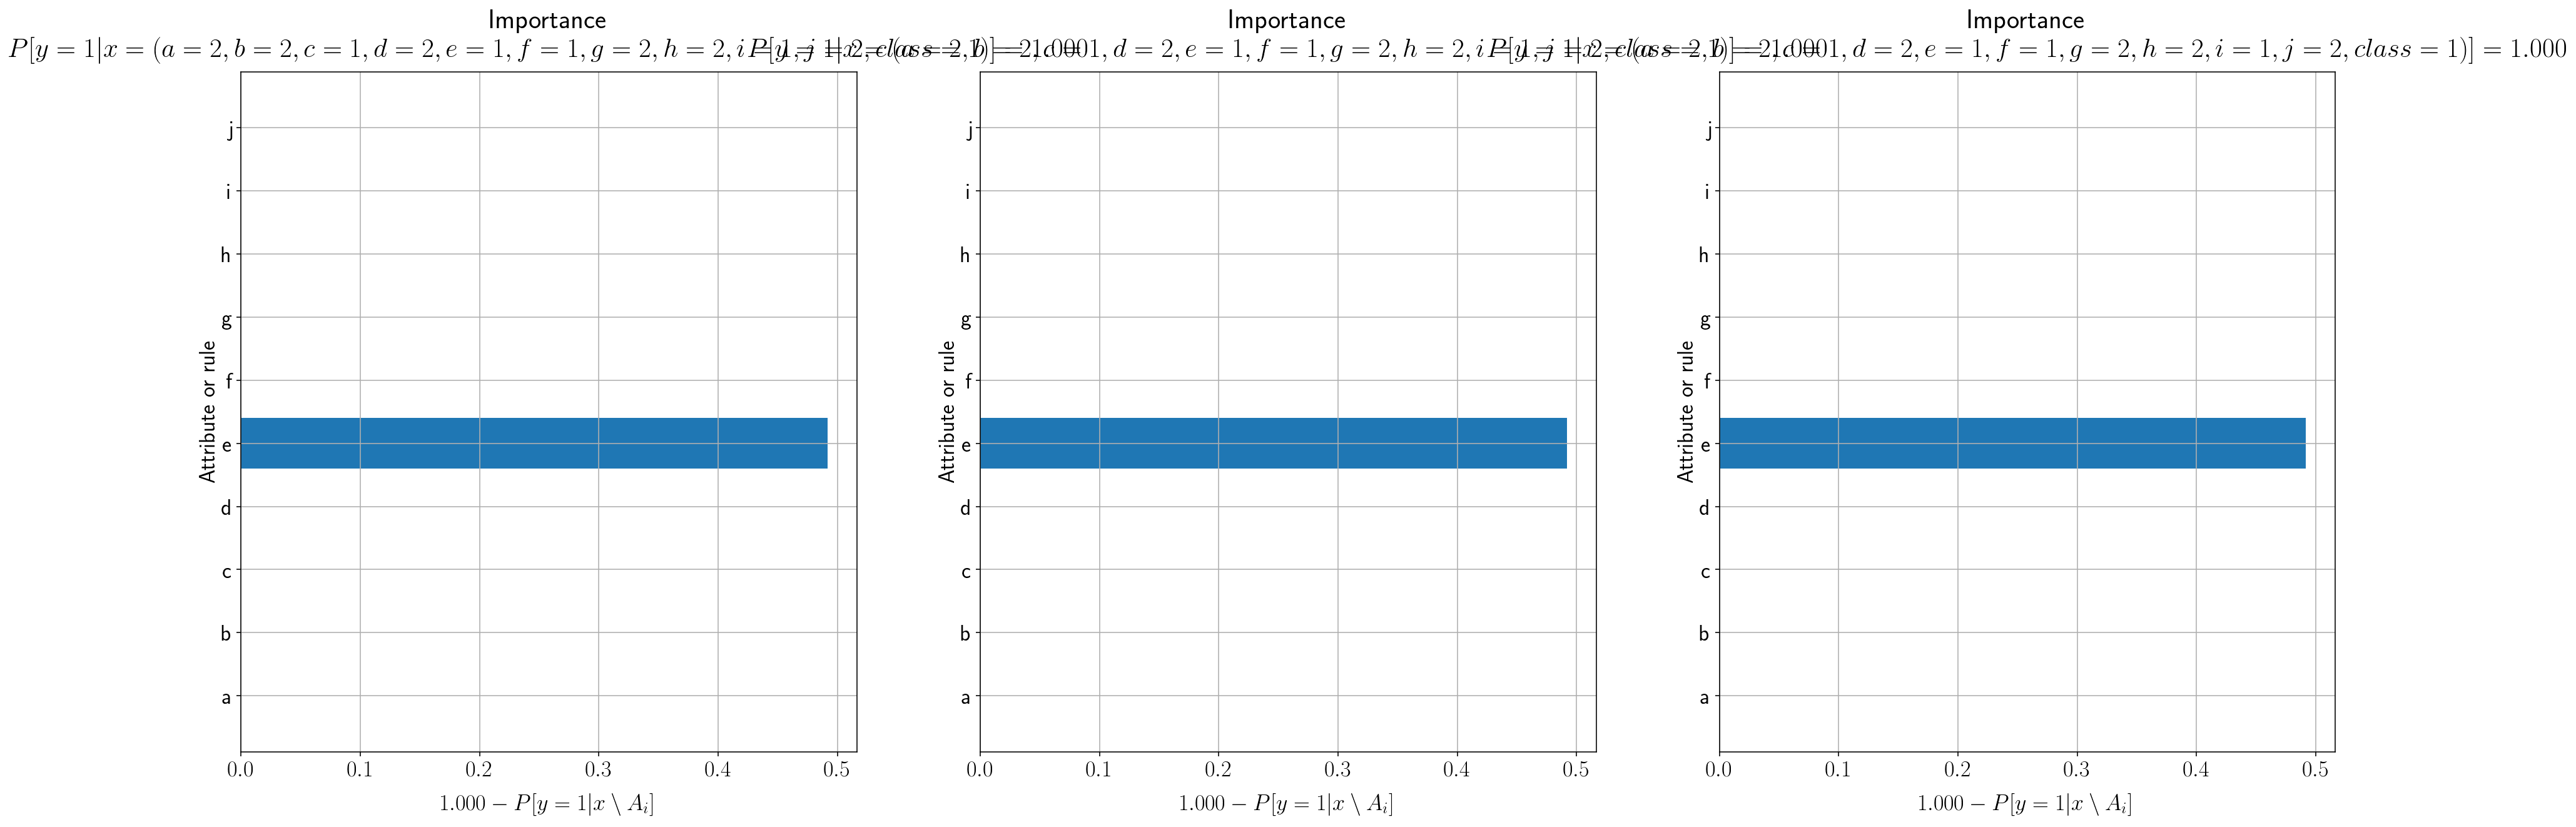

Instance 2
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
final rules []
compute_lace_step k=423 0.01
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=564 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 368}
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('e', '1'), ('f', '3'), ('g', '1'), ('i', '2')], 'class': '1', 'sup': 3}
final rules [[5]]
explain_instance errors: 2.216E-01, 2.216E-01, 2.216E-01, 1.130E-02
compute_lace_step k=141 0.05
final rules []
compute_lace_step k=282 0.05
final rules []
compute_lace_step k=423 0.05
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=564 0.05
{'body': [('e', '3')], 'class': '0', 'sup': 368}
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('e', '1

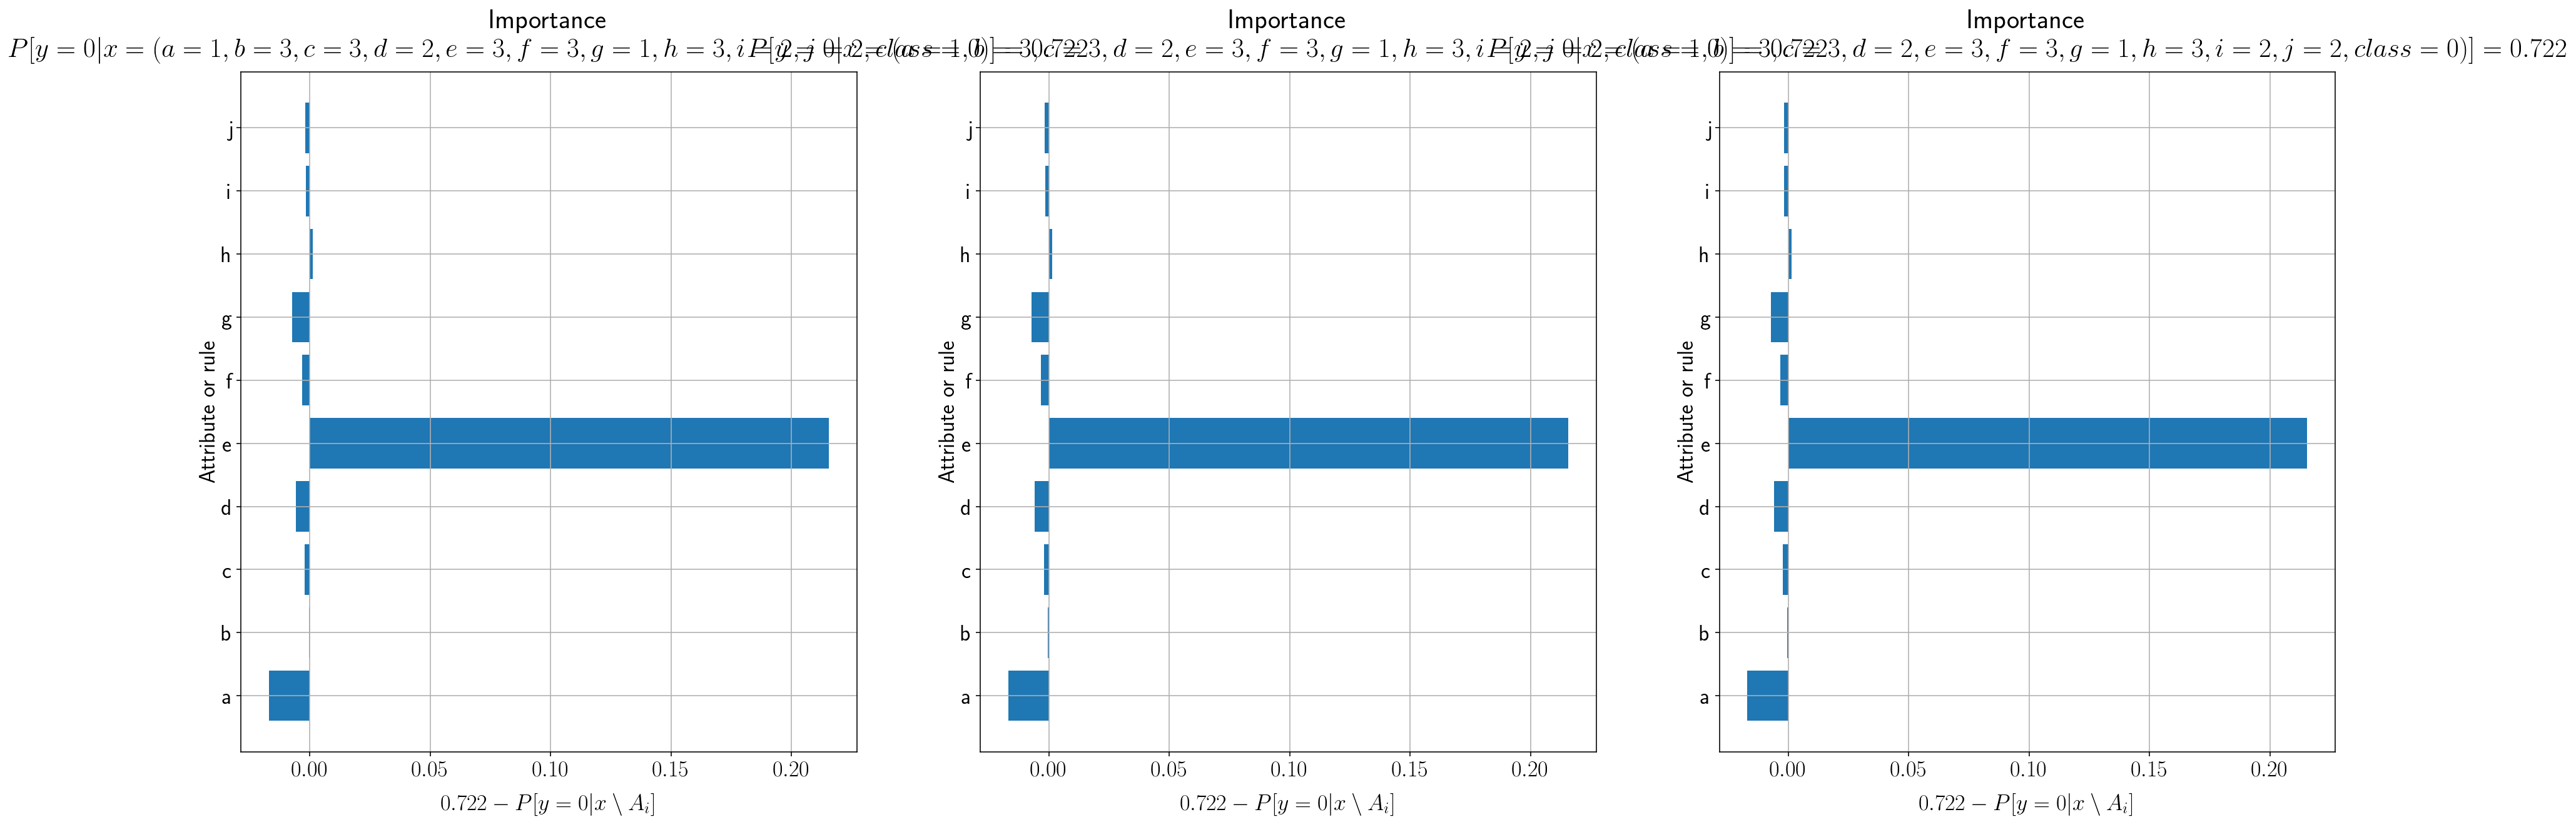

Instance 3
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '1'), ('c', '2'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '3'), ('h', '3'), ('i', '1'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=423 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 284}
{'body': [('a', '3'), ('b', '1'), ('e', '1'), ('f', '3'), ('h', '3')], 'class': '1', 'sup': 4}
final rules [[5]]
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute_lace_step k=141 0.05
final rules []
compute_lace_step k=282 0.05
{'body': [('a', '3'), ('b', '1'), ('c', '2'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '3'), ('h', '3'), ('i', '1'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=423 0.05
{'body': [('e', '3')], 'class': '0', 'sup': 284}
{'body': [('a', '3'), ('b', '1'), ('e', '1'), ('f', '3'), ('h', '3')], 'class': '1', 'sup': 4}
final rules [[5]]
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute

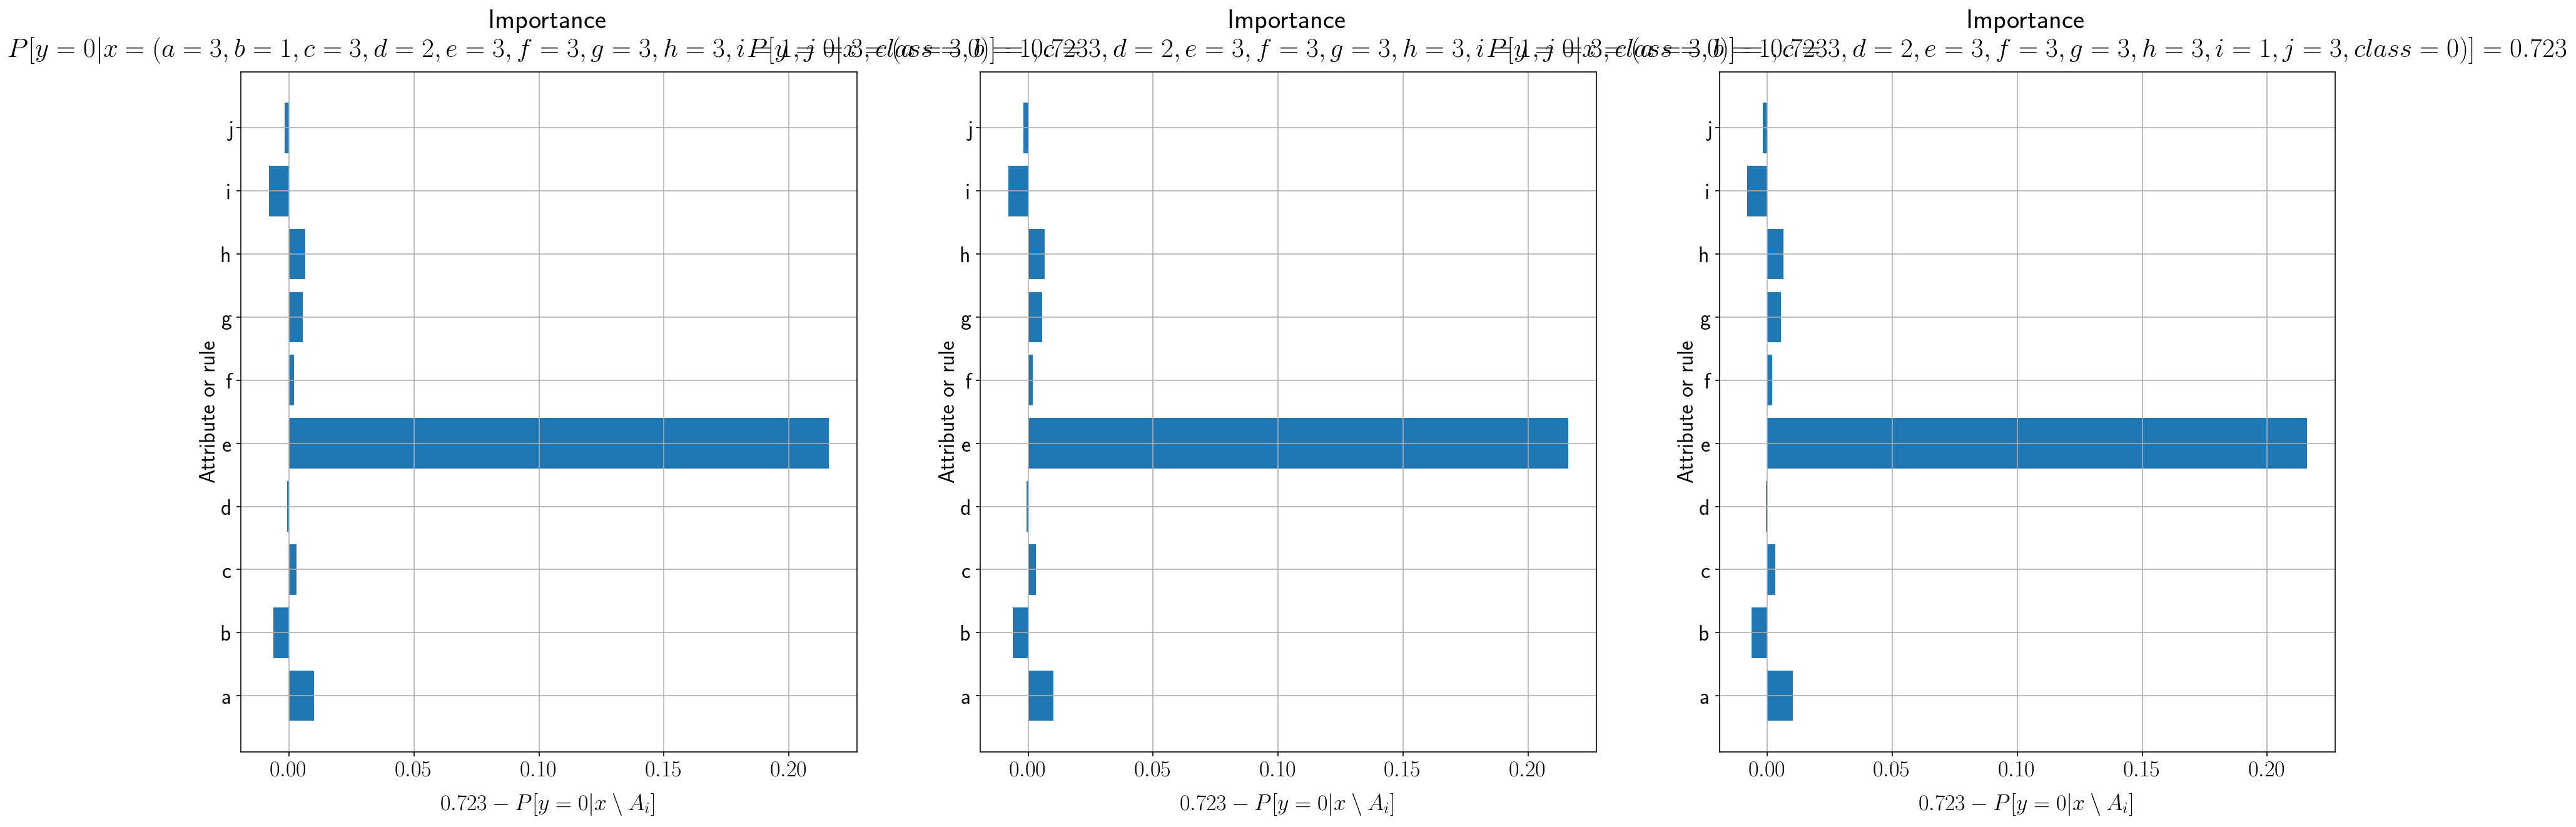

In [9]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Random Forest

Instance 0
compute_lace_step k=141 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 86}
{'body': [('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 16}
final rules [[1, 2]]
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 141}
{'body': [('b', '1')], 'class': '0', 'sup': 64}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 37}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 35}
{'body': [('d', '2'), ('f', '1'), ('g', '1'), ('i', '3'), ('j', '2')], 'class': '0', 'sup': 14}
{'body': [('b', '2')], 'class': '0', 'sup': 142}
final rules [[1, 2], [2]]
compute_lace_step k=423 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 195}
{'body': [('b', '1')], 'class': '0', 'sup': 99}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 60}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 54}
{'body': [('d', '2'), ('

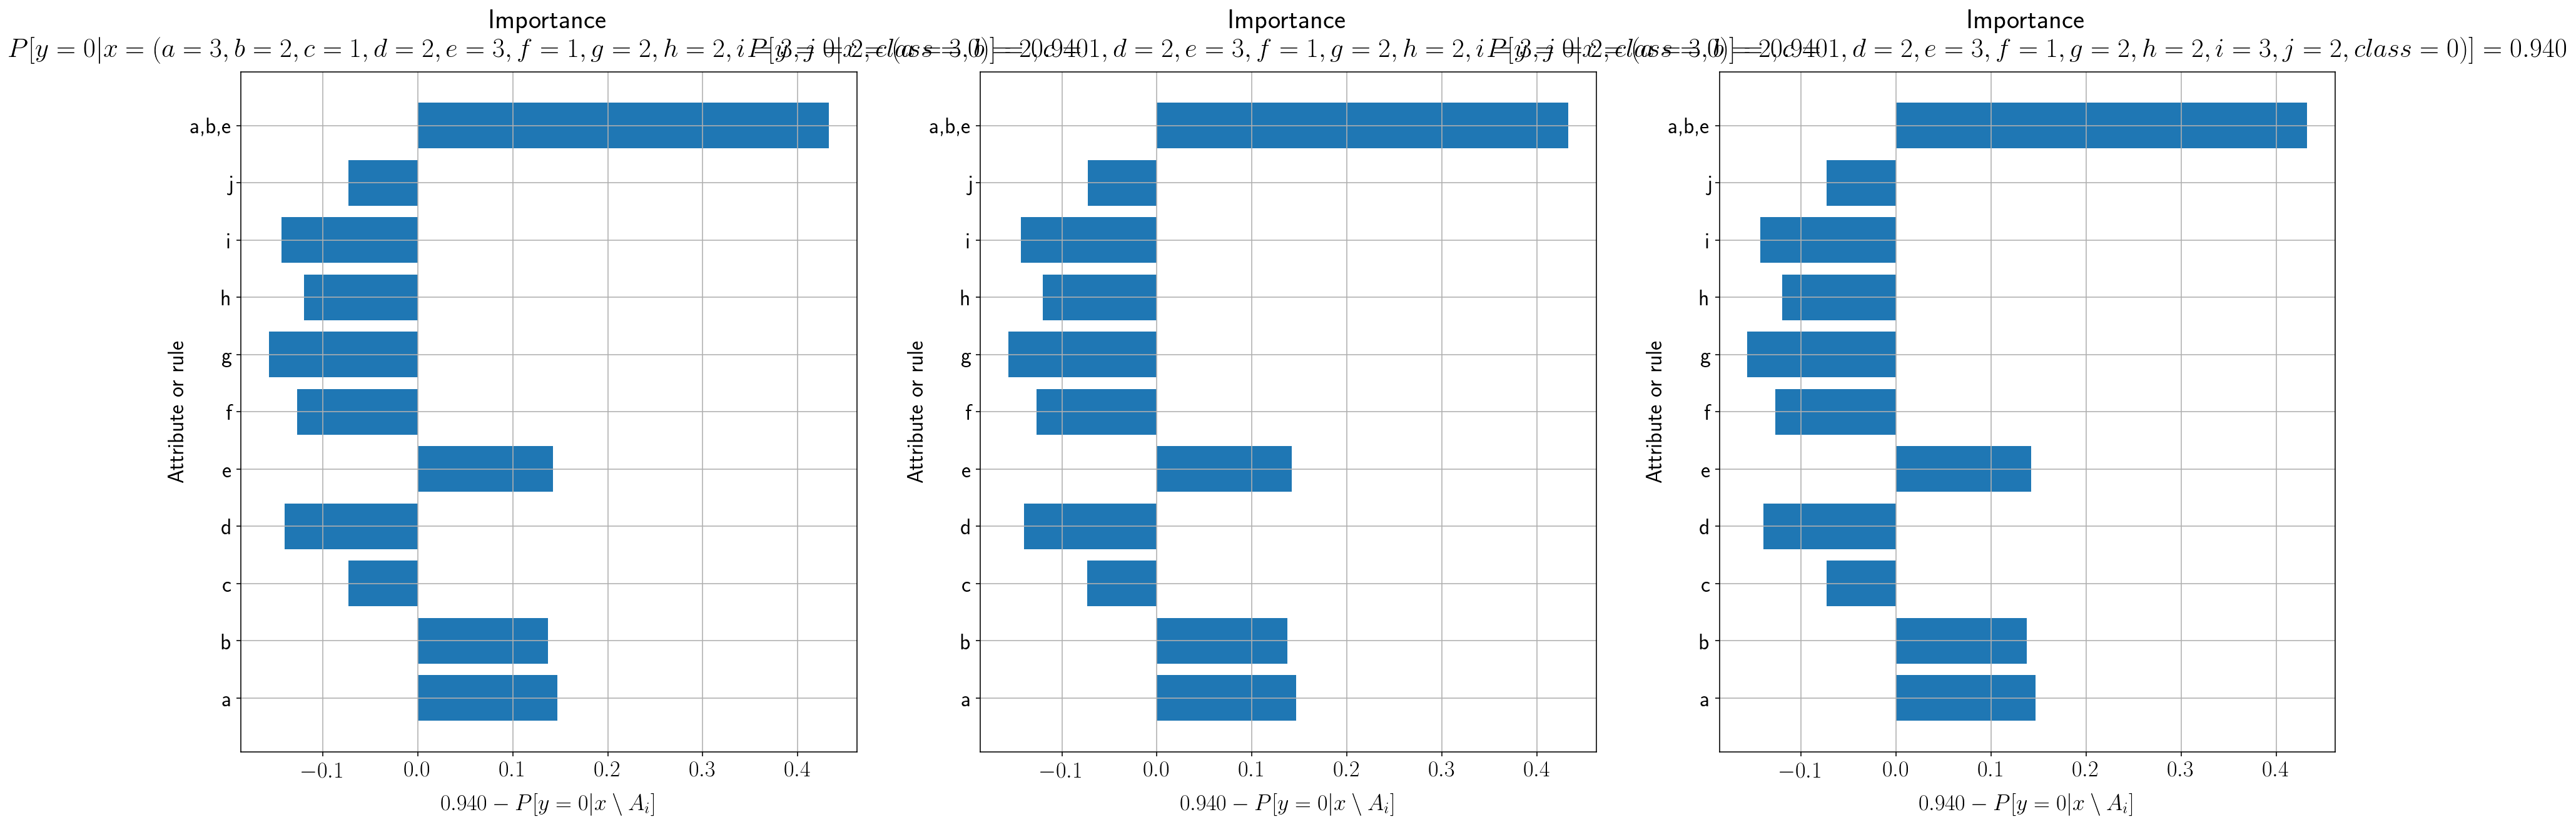

Instance 1
compute_lace_step k=141 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 68}
{'body': [('d', '2'), ('e', '2'), ('g', '2'), ('i', '1')], 'class': '0', 'sup': 8}
{'body': [('b', '3'), ('c', '1'), ('e', '2'), ('g', '2')], 'class': '0', 'sup': 7}
{'body': [('c', '1'), ('e', '2'), ('f', '1'), ('g', '2'), ('i', '1'), ('j', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('e', '2'), ('f', '1'), ('i', '1'), ('j', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2], [1, 2, 5], [5]]
explain_instance errors: 1.432E-02
compute_lace_step k=141 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 68}
{'body': [('d', '2'), ('e', '2'), ('g', '2'), ('i', '1')], 'class': '0', 'sup': 8}
{'body': [('b', '3'), ('c', '1'), ('e', '2'), ('g', '2')], 'class': '0', 'sup': 7}
{'body': [('c', '1'), ('e', '2'), ('f', '1'), ('g', '2'), ('i', '1'), ('j', '2')], 'class': '0'

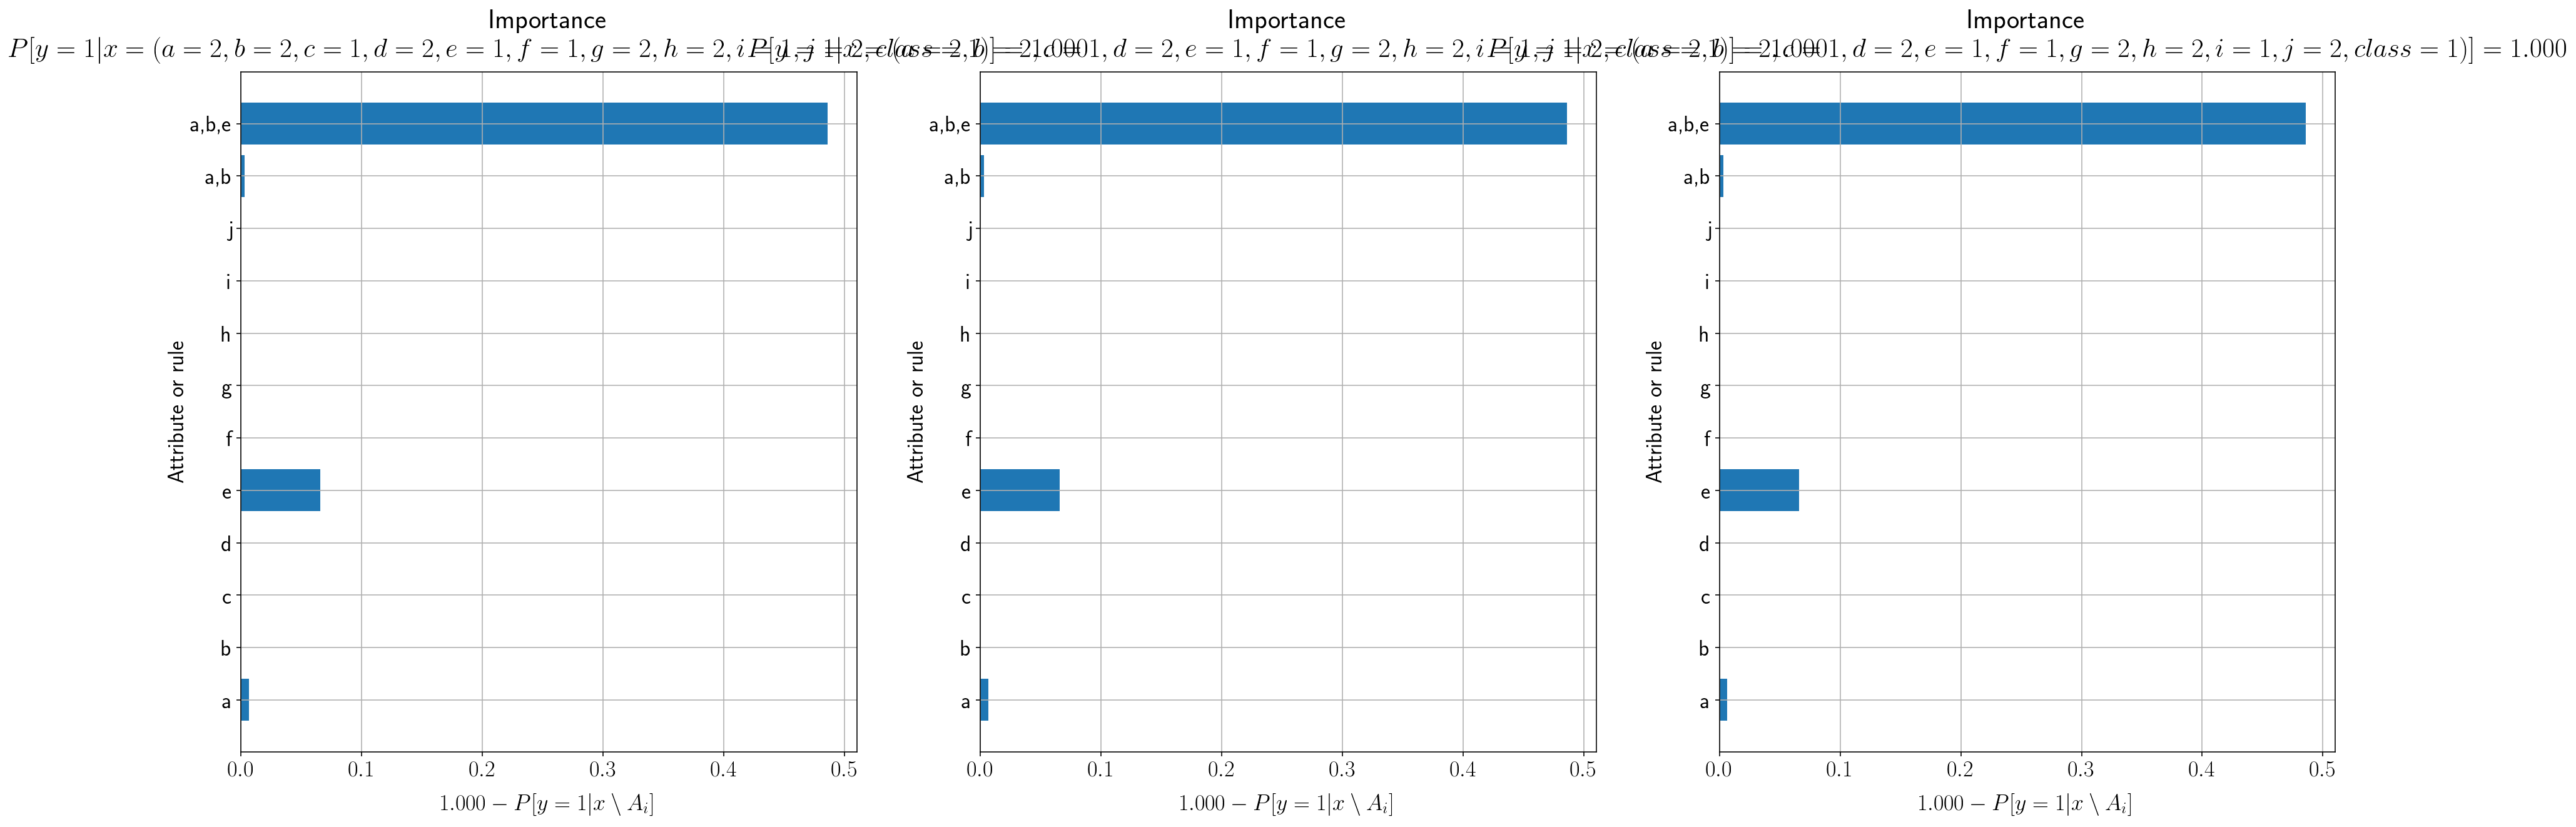

Instance 2
compute_lace_step k=141 0.01
{'body': [('b', '3')], 'class': '0', 'sup': 116}
{'body': [('a', '2'), ('b', '2'), ('c', '3'), ('d', '1'), ('e', '2'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '2')], 'class': '1', 'sup': 1}
final rules [[2]]
compute_lace_step k=282 0.01
{'body': [('b', '3')], 'class': '0', 'sup': 213}
{'body': [('a', '1')], 'class': '0', 'sup': 195}
{'body': [('a', '2'), ('b', '2'), ('c', '3')], 'class': '1', 'sup': 10}
final rules [[1], [1, 2], [2]]
explain_instance errors: 1.555E-01, 2.067E-01
compute_lace_step k=141 0.05
{'body': [('b', '3')], 'class': '0', 'sup': 116}
{'body': [('a', '2'), ('b', '2'), ('c', '3'), ('d', '1'), ('e', '2'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '2')], 'class': '1', 'sup': 1}
final rules [[2]]
compute_lace_step k=282 0.05
{'body': [('b', '3')], 'class': '0', 'sup': 213}
{'body': [('a', '1')], 'class': '0', 'sup': 195}
{'body': [('a', '2'), ('b', '2'), ('c', '3')], 'class': '1', 'sup': 10}
final rules 

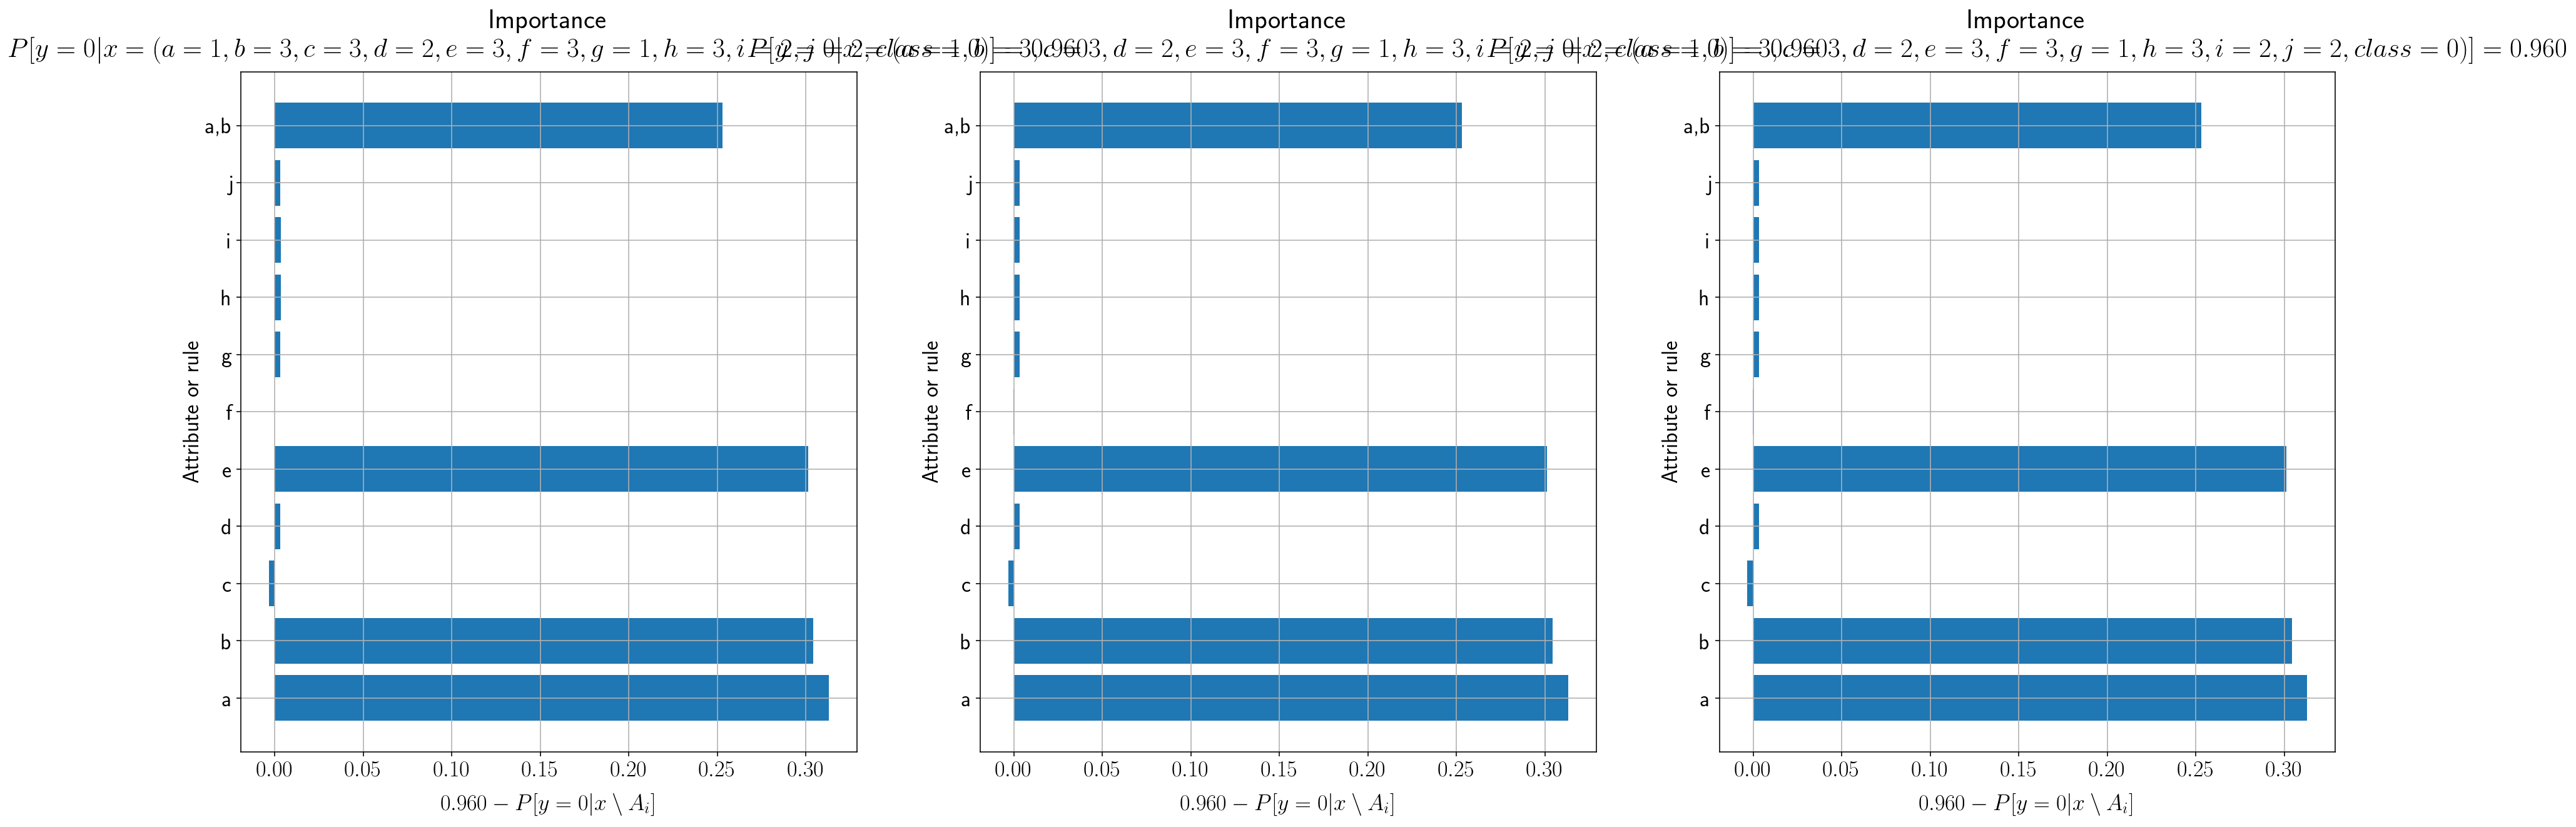

Instance 3
compute_lace_step k=141 0.01
{'body': [('a', '3')], 'class': '0', 'sup': 103}
{'body': [('b', '1')], 'class': '0', 'sup': 100}
{'body': [('a', '2'), ('b', '2'), ('e', '3')], 'class': '1', 'sup': 10}
final rules [[1], [1, 2], [2]]
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '1'), ('e', '3')], 'class': '0', 'sup': 80}
{'body': [('a', '3'), ('b', '1'), ('c', '3')], 'class': '0', 'sup': 76}
{'body': [('b', '1'), ('i', '2')], 'class': '0', 'sup': 72}
{'body': [('a', '3'), ('i', '2')], 'class': '0', 'sup': 71}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 69}
{'body': [('b', '1'), ('h', '2')], 'class': '0', 'sup': 69}
{'body': [('a', '3'), ('g', '2')], 'class': '0', 'sup': 67}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 67}
{'body': [('b', '1'), ('j', '2')], 'class': '0', 'sup': 62}
{'body': [('b', '1'), ('d', '1')], 'class': '0', 'sup': 59}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 24}
{'body': [('a', '1'), ('b', '1'), ('c', '3'), 

explain_instance errors: 2.170E-01, 2.815E-02, 2.605E-02, 2.605E-02, 3.328E-03
compute_lace_step k=141 0.075
{'body': [('a', '3')], 'class': '0', 'sup': 103}
{'body': [('b', '1')], 'class': '0', 'sup': 100}
{'body': [('a', '2'), ('b', '2'), ('e', '3')], 'class': '1', 'sup': 10}
final rules [[1], [1, 2], [2]]
compute_lace_step k=282 0.075
{'body': [('a', '3'), ('b', '1'), ('e', '3')], 'class': '0', 'sup': 80}
{'body': [('a', '3'), ('b', '1'), ('c', '3')], 'class': '0', 'sup': 76}
{'body': [('b', '1'), ('i', '2')], 'class': '0', 'sup': 72}
{'body': [('a', '3'), ('i', '2')], 'class': '0', 'sup': 71}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 69}
{'body': [('b', '1'), ('h', '2')], 'class': '0', 'sup': 69}
{'body': [('a', '3'), ('g', '2')], 'class': '0', 'sup': 67}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 67}
{'body': [('b', '1'), ('j', '2')], 'class': '0', 'sup': 62}
{'body': [('b', '1'), ('d', '1')], 'class': '0', 'sup': 59}
{'body': [('a', '2'), ('b', '2')], '

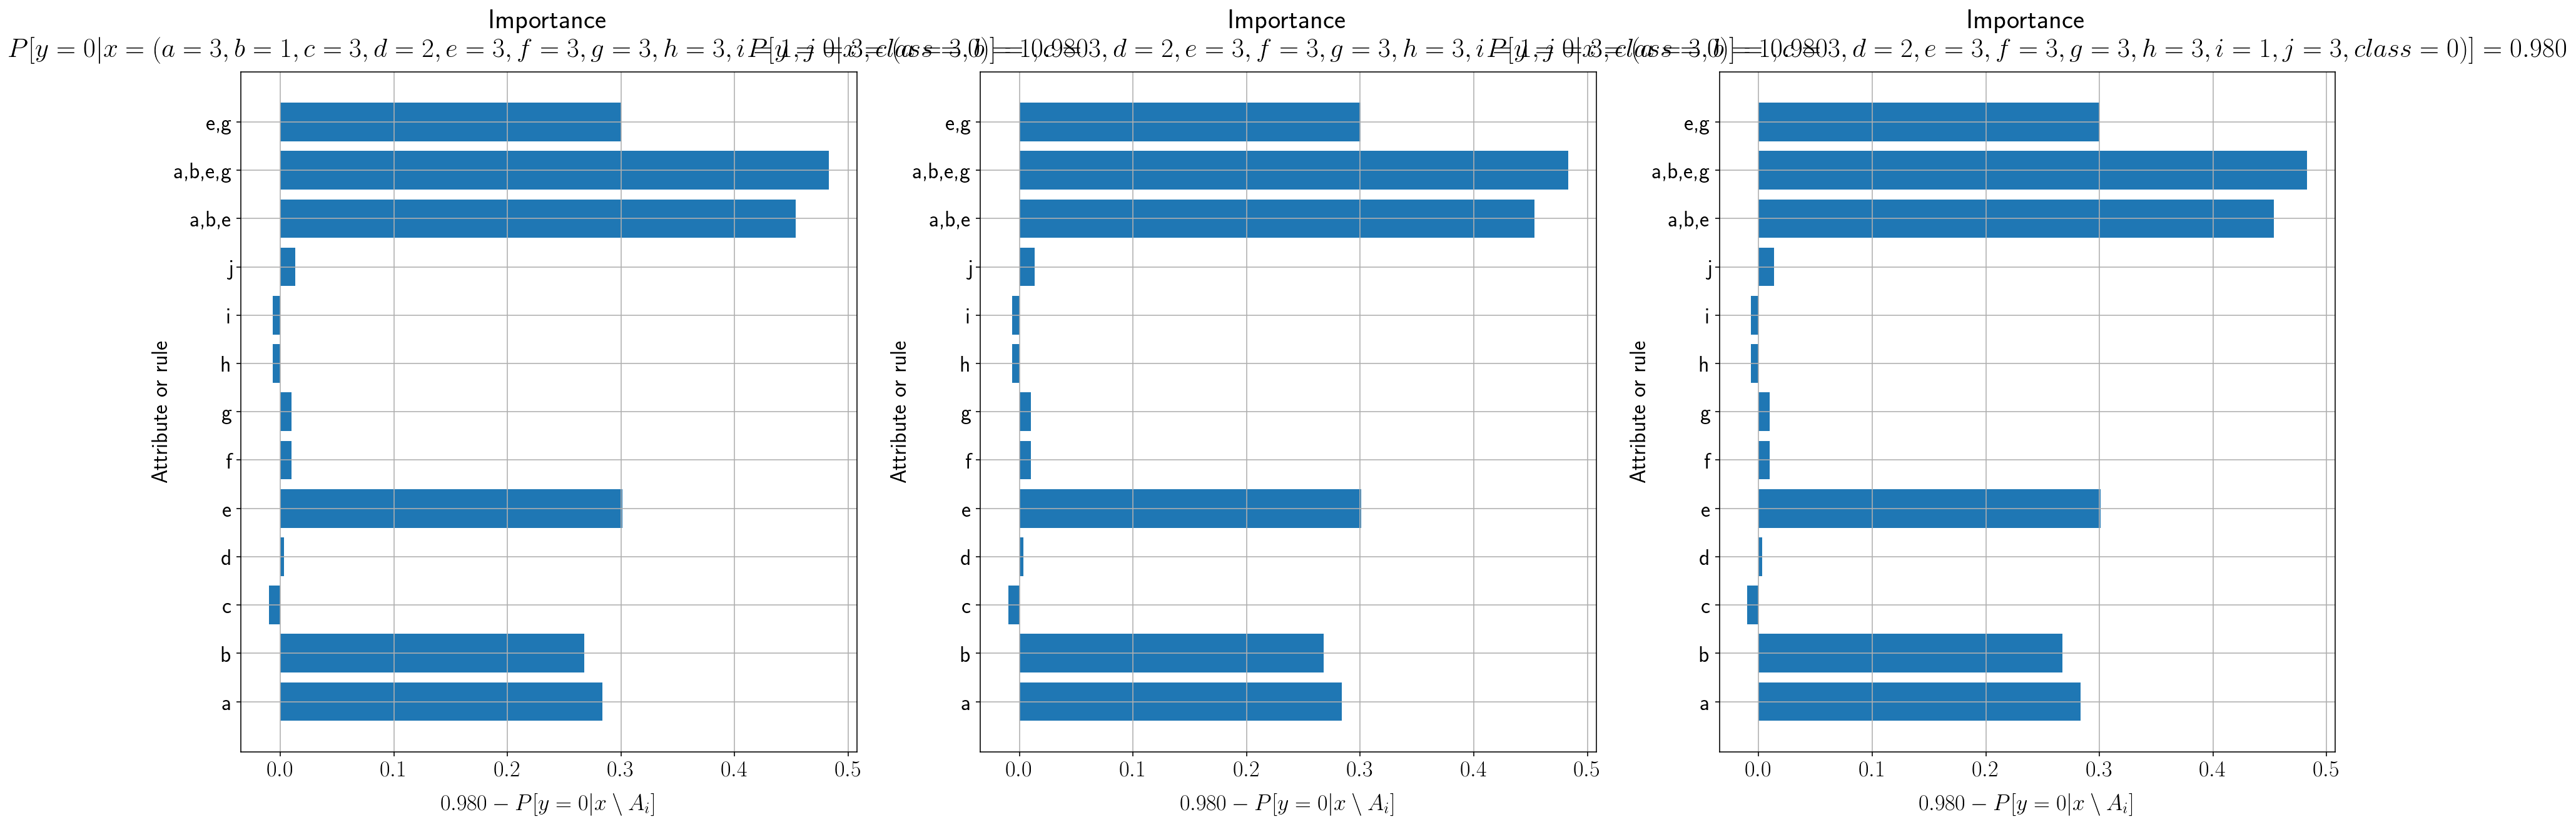

In [10]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_rf", 0.075))
    plt.show()

for i in range(4):
    run(i)

### Neural Network

Instance 0
compute_lace_step k=141 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 86}
{'body': [('b', '1')], 'class': '0', 'sup': 22}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 17}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 16}
final rules [[1, 2]]
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 141}
{'body': [('b', '1')], 'class': '0', 'sup': 64}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 37}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 35}
{'body': [('d', '2'), ('f', '1'), ('g', '1'), ('i', '3'), ('j', '2')], 'class': '0', 'sup': 14}
{'body': [('b', '2')], 'class': '0', 'sup': 142}
final rules [[1, 2], [2]]
compute_lace_step k=423 0.01
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 195}
{'body': [('b', '1')], 'class': '0', 'sup': 99}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 60}
{'body': [('a', '3'), ('b', '3')], 'class': '1', 'sup': 54}
{'body': [('d', '2'), ('

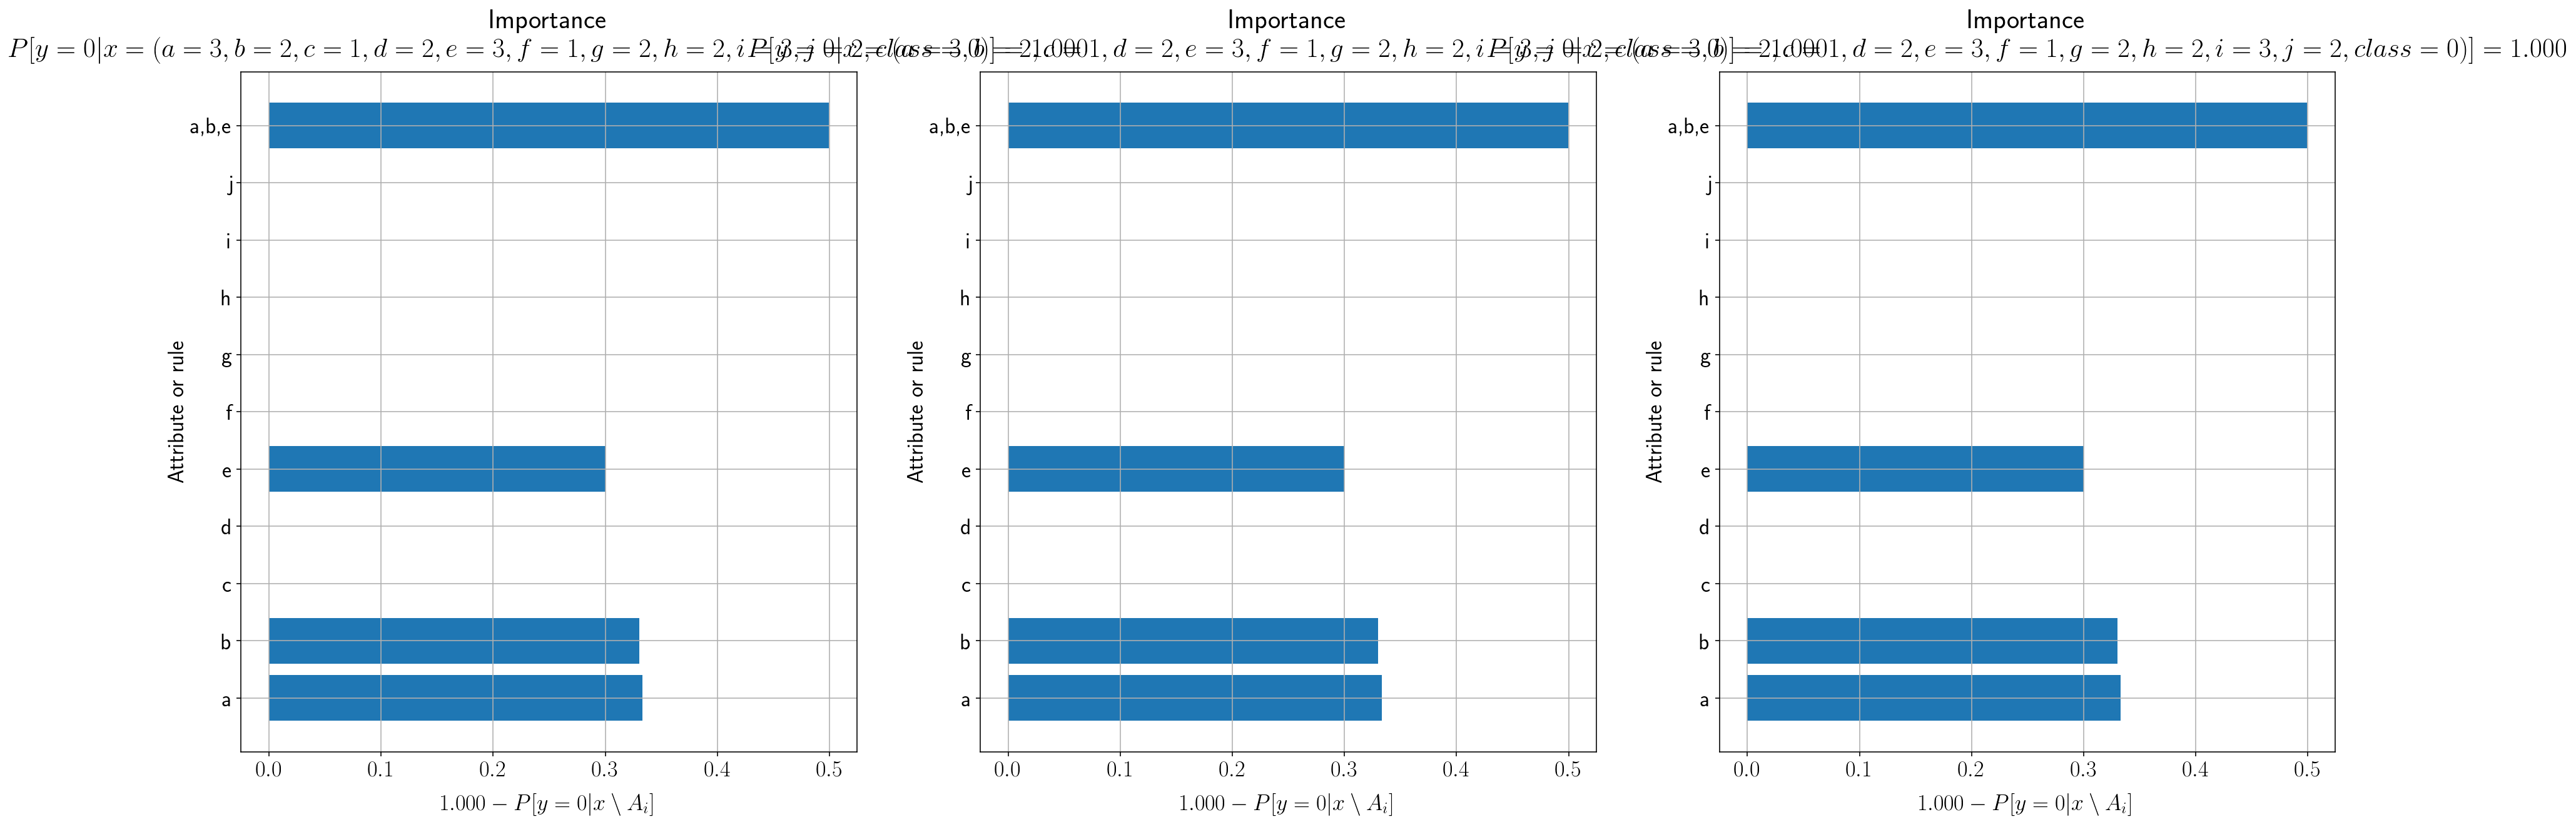

Instance 1
compute_lace_step k=141 0.01
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 68}
{'body': [('d', '2'), ('e', '2'), ('g', '2'), ('i', '1')], 'class': '0', 'sup': 8}
{'body': [('b', '3'), ('c', '1'), ('e', '2'), ('g', '2')], 'class': '0', 'sup': 7}
{'body': [('c', '1'), ('e', '2'), ('f', '1'), ('g', '2'), ('i', '1'), ('j', '2')], 'class': '0', 'sup': 6}
{'body': [('a', '2'), ('b', '1'), ('e', '2'), ('f', '1'), ('i', '1'), ('j', '2')], 'class': '0', 'sup': 4}
final rules [[1, 2], [1, 2, 5], [5]]
explain_instance errors: 5.389E-07
compute_lace_step k=141 0.05
{'body': [('e', '1')], 'class': '1', 'sup': 119}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 68}
{'body': [('d', '2'), ('e', '2'), ('g', '2'), ('i', '1')], 'class': '0', 'sup': 8}
{'body': [('b', '3'), ('c', '1'), ('e', '2'), ('g', '2')], 'class': '0', 'sup': 7}
{'body': [('c', '1'), ('e', '2'), ('f', '1'), ('g', '2'), ('i', '1'), ('j', '2')], 'class': '0'

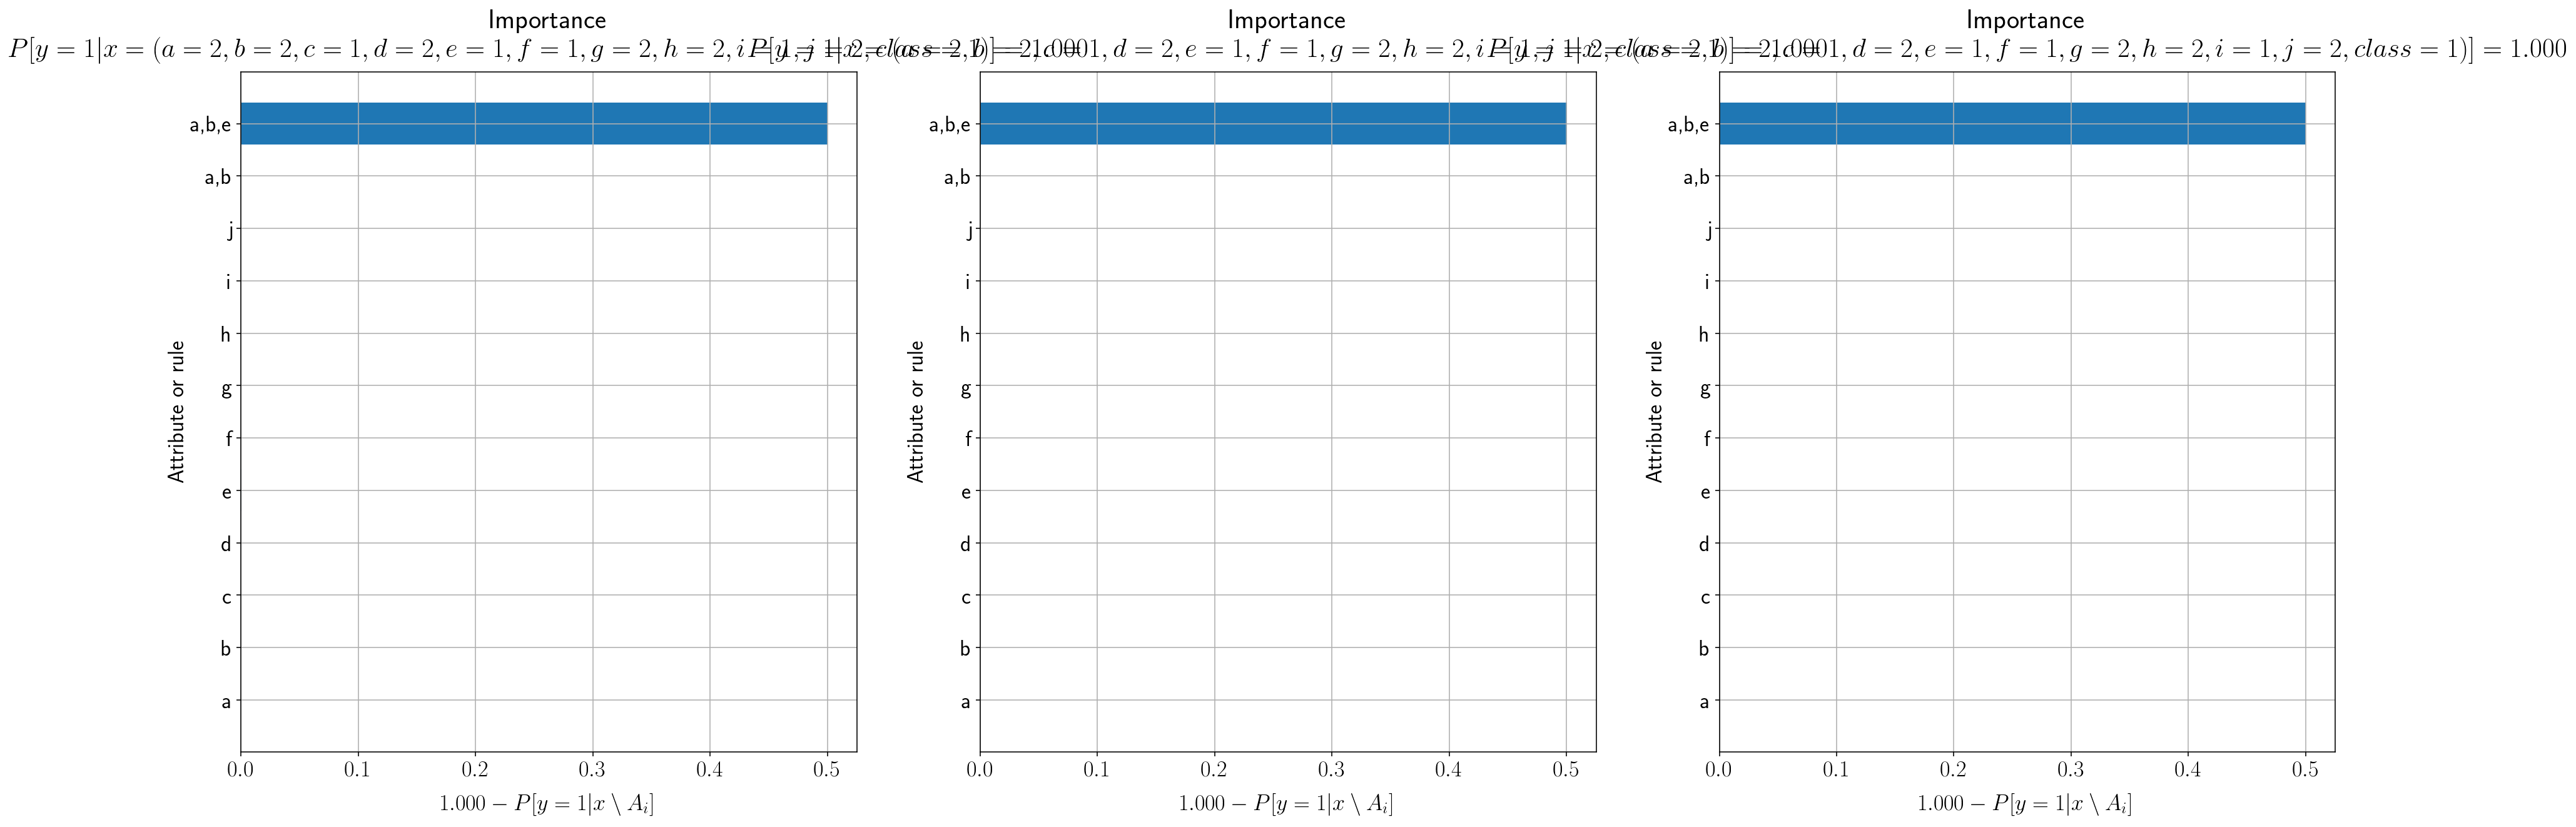

Instance 2
compute_lace_step k=141 0.01
{'body': [('b', '3')], 'class': '0', 'sup': 116}
{'body': [('a', '2'), ('b', '2'), ('c', '3'), ('d', '1'), ('e', '2'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '2')], 'class': '1', 'sup': 1}
final rules [[2]]
compute_lace_step k=282 0.01
{'body': [('b', '3')], 'class': '0', 'sup': 213}
{'body': [('a', '1')], 'class': '0', 'sup': 195}
{'body': [('a', '2'), ('b', '2'), ('c', '3')], 'class': '1', 'sup': 10}
final rules [[1], [1, 2], [2]]
explain_instance errors: 1.610E-01, 1.713E-01
compute_lace_step k=141 0.05
{'body': [('b', '3')], 'class': '0', 'sup': 116}
{'body': [('a', '2'), ('b', '2'), ('c', '3'), ('d', '1'), ('e', '2'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '2')], 'class': '1', 'sup': 1}
final rules [[2]]
compute_lace_step k=282 0.05
{'body': [('b', '3')], 'class': '0', 'sup': 213}
{'body': [('a', '1')], 'class': '0', 'sup': 195}
{'body': [('a', '2'), ('b', '2'), ('c', '3')], 'class': '1', 'sup': 10}
final rules 

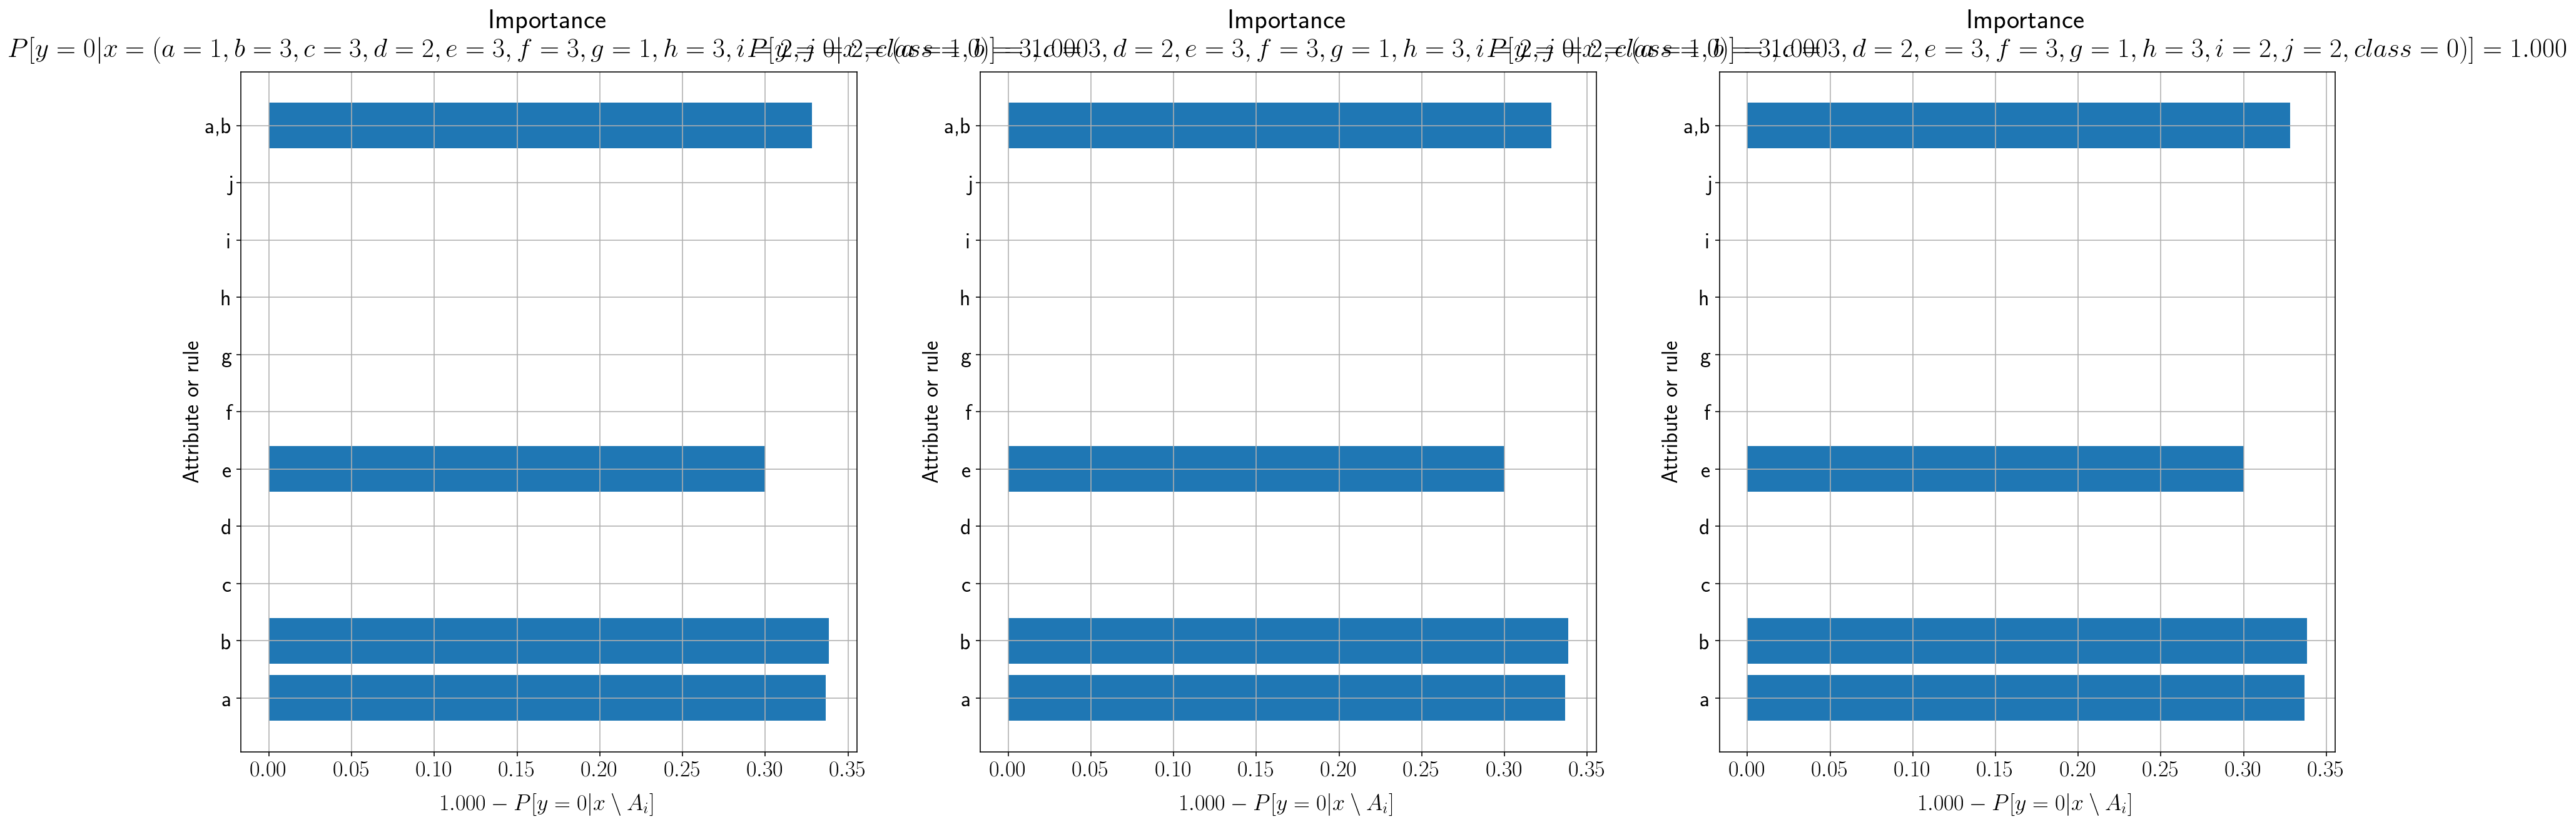

Instance 3
compute_lace_step k=141 0.01
{'body': [('a', '3')], 'class': '0', 'sup': 103}
{'body': [('b', '1')], 'class': '0', 'sup': 100}
{'body': [('a', '2'), ('b', '2'), ('e', '3')], 'class': '1', 'sup': 10}
final rules [[1], [1, 2], [2]]
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '1'), ('e', '3')], 'class': '0', 'sup': 80}
{'body': [('a', '3'), ('b', '1'), ('c', '3')], 'class': '0', 'sup': 76}
{'body': [('b', '1'), ('i', '2')], 'class': '0', 'sup': 72}
{'body': [('a', '3'), ('i', '2')], 'class': '0', 'sup': 71}
{'body': [('a', '3'), ('b', '2')], 'class': '0', 'sup': 69}
{'body': [('b', '1'), ('h', '2')], 'class': '0', 'sup': 69}
{'body': [('a', '3'), ('g', '2')], 'class': '0', 'sup': 67}
{'body': [('a', '2'), ('b', '1')], 'class': '0', 'sup': 67}
{'body': [('b', '1'), ('j', '2')], 'class': '0', 'sup': 62}
{'body': [('b', '1'), ('d', '1')], 'class': '0', 'sup': 59}
{'body': [('a', '2'), ('b', '2')], 'class': '1', 'sup': 24}
{'body': [('a', '1'), ('b', '1'), ('c', '3'), 

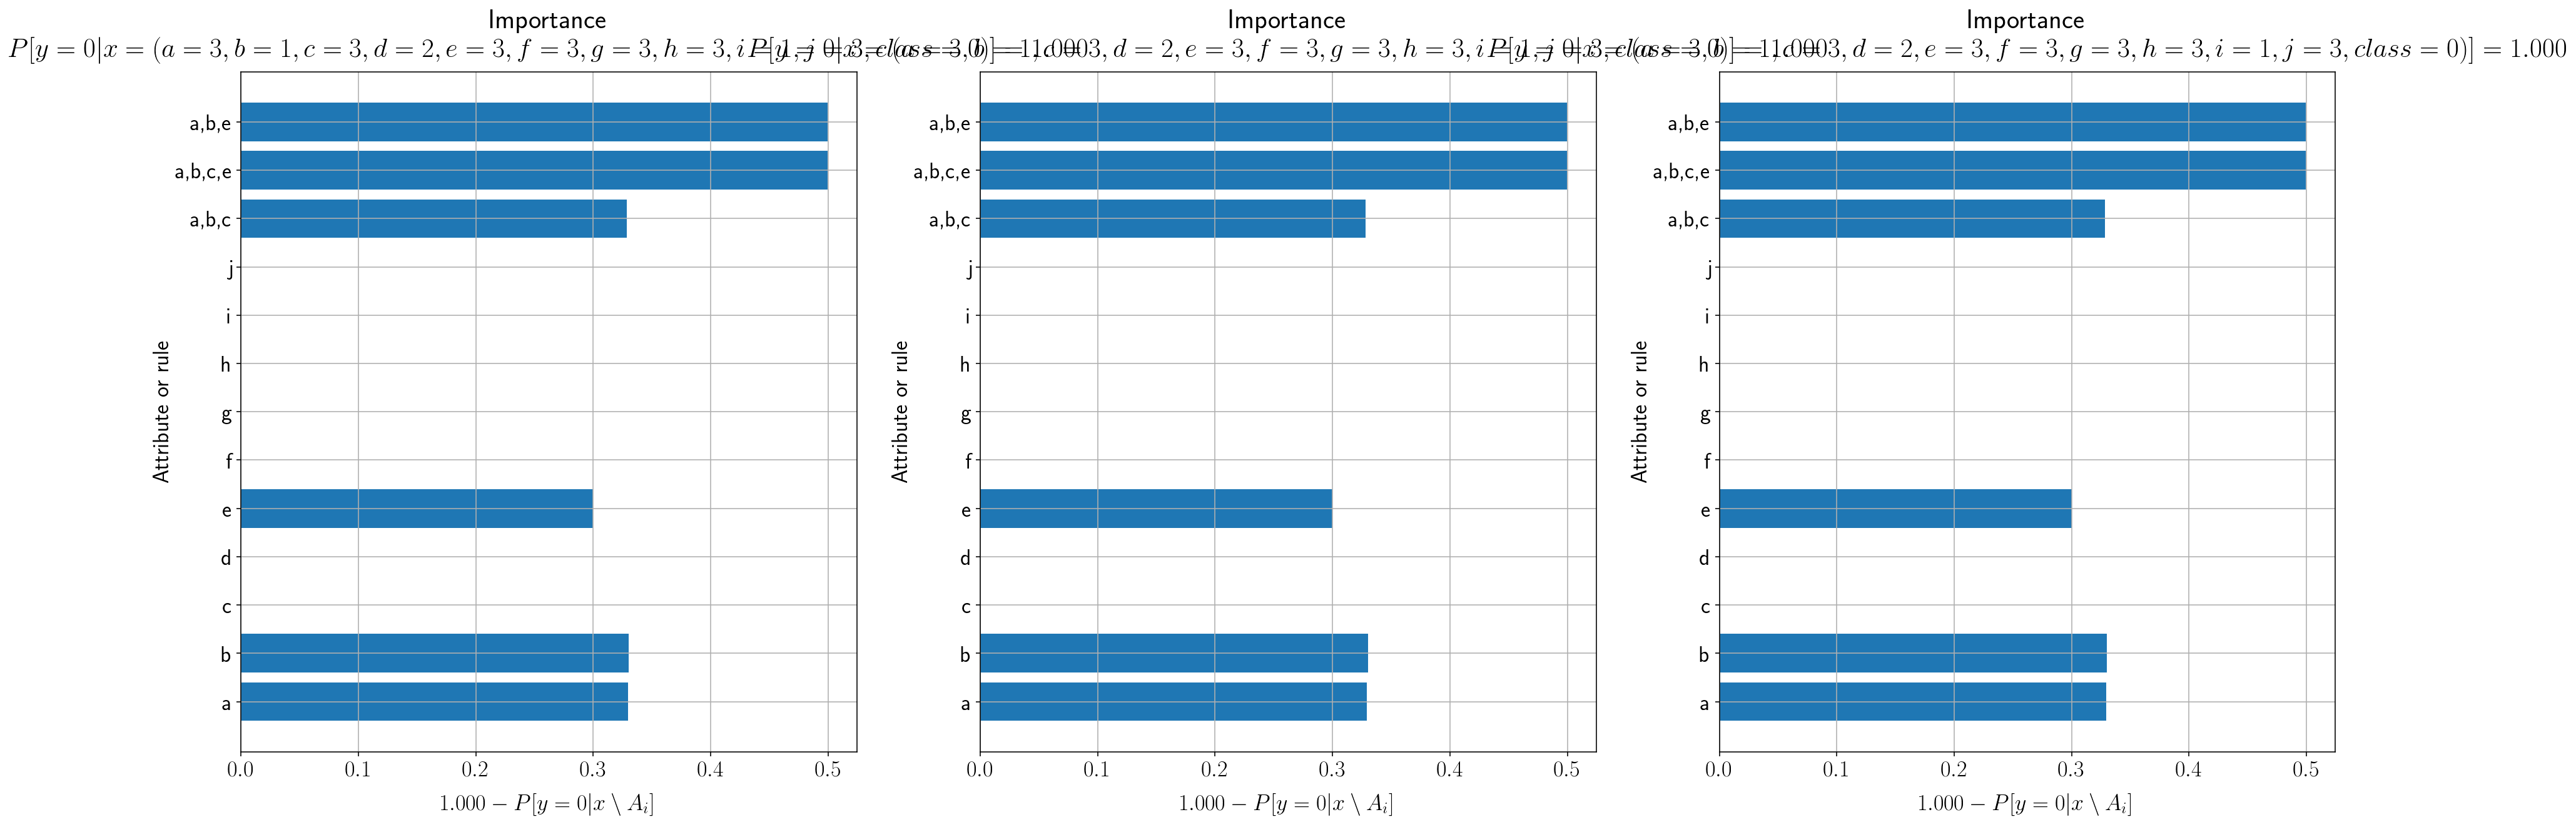

In [12]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "nn_onehot_enc", 0.075))
    plt.show()

for i in range(4):
    run(i)

## Adult

### Categorical Naive Bayes

Instance 0
compute_lace_step k=118 0.01
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 75}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 61}
{'body': [('occupation', 'Service')], 'class': '<=50K', 'sup': 57}
{'body': [('capital-gain', 'low'), ('age', '<25')], 'class': '<=50K', 'sup': 50}
{'body': [('workclass', 'Self-emp-inc'), ('education', 'High-School-grad'), ('race', 'White'), ('occupation', 'White-Collar'), ('relationship', 'Not-in-family'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body': [('education', 'Doctorate'), ('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body': [('education', 'High-School-grad'), ('race', 'White'), ('relationshi

compute_lace_step k=472 0.01
{'body': [('age', '<25')], 'class': '<=50K', 'sup': 189}
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 171}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 166}
{'body': [('education', 'High-School-grad'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 125}
{'body': [('sex', 'Female'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 122}
{'body': [('occupation', 'Service'), ('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 120}
{'body': [('sex', 'Female'), ('occupation', 'Service')], 'class': '<=50K', 'sup': 111}
{'body': [('capital-gain', 'low'), ('hours-per-week', '<39.5')], 'class': '<=50K', 'sup': 103}
{'body': [('

explain_instance errors: 3.827E-01, 7.375E-02, 7.375E-02, 4.713E-02, 4.713E-02
compute_lace_step k=118 0.05
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 75}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 61}
{'body': [('occupation', 'Service')], 'class': '<=50K', 'sup': 57}
{'body': [('capital-gain', 'low'), ('age', '<25')], 'class': '<=50K', 'sup': 50}
{'body': [('workclass', 'Self-emp-inc'), ('education', 'High-School-grad'), ('race', 'White'), ('occupation', 'White-Collar'), ('relationship', 'Not-in-family'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body': [('education', 'Doctorate'), ('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body': 

compute_lace_step k=472 0.05
{'body': [('age', '<25')], 'class': '<=50K', 'sup': 189}
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 171}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 166}
{'body': [('education', 'High-School-grad'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 125}
{'body': [('sex', 'Female'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 122}
{'body': [('occupation', 'Service'), ('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 120}
{'body': [('sex', 'Female'), ('occupation', 'Service')], 'class': '<=50K', 'sup': 111}
{'body': [('capital-gain', 'low'), ('hours-per-week', '<39.5')], 'class': '<=50K', 'sup': 103}
{'body': [('

explain_instance errors: 3.827E-01, 7.375E-02, 7.375E-02, 4.713E-02, 4.713E-02
compute_lace_step k=118 0.075
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 75}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 61}
{'body': [('occupation', 'Service')], 'class': '<=50K', 'sup': 57}
{'body': [('capital-gain', 'low'), ('age', '<25')], 'class': '<=50K', 'sup': 50}
{'body': [('workclass', 'Self-emp-inc'), ('education', 'High-School-grad'), ('race', 'White'), ('occupation', 'White-Collar'), ('relationship', 'Not-in-family'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body': [('education', 'Doctorate'), ('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('age', '>=51')], 'class': '>50K', 'sup': 3}
{'body':

compute_lace_step k=472 0.075
{'body': [('age', '<25')], 'class': '<=50K', 'sup': 189}
{'body': [('workclass', 'Private'), ('education', 'High-School-grad'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 171}
{'body': [('sex', 'Female'), ('education', 'High-School-grad'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 166}
{'body': [('education', 'High-School-grad'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 125}
{'body': [('sex', 'Female'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 122}
{'body': [('occupation', 'Service'), ('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 120}
{'body': [('sex', 'Female'), ('occupation', 'Service')], 'class': '<=50K', 'sup': 111}
{'body': [('capital-gain', 'low'), ('hours-per-week', '<39.5')], 'class': '<=50K', 'sup': 103}
{'body': [(

explain_instance errors: 3.827E-01, 7.375E-02, 7.375E-02, 7.375E-02, 4.933E-02


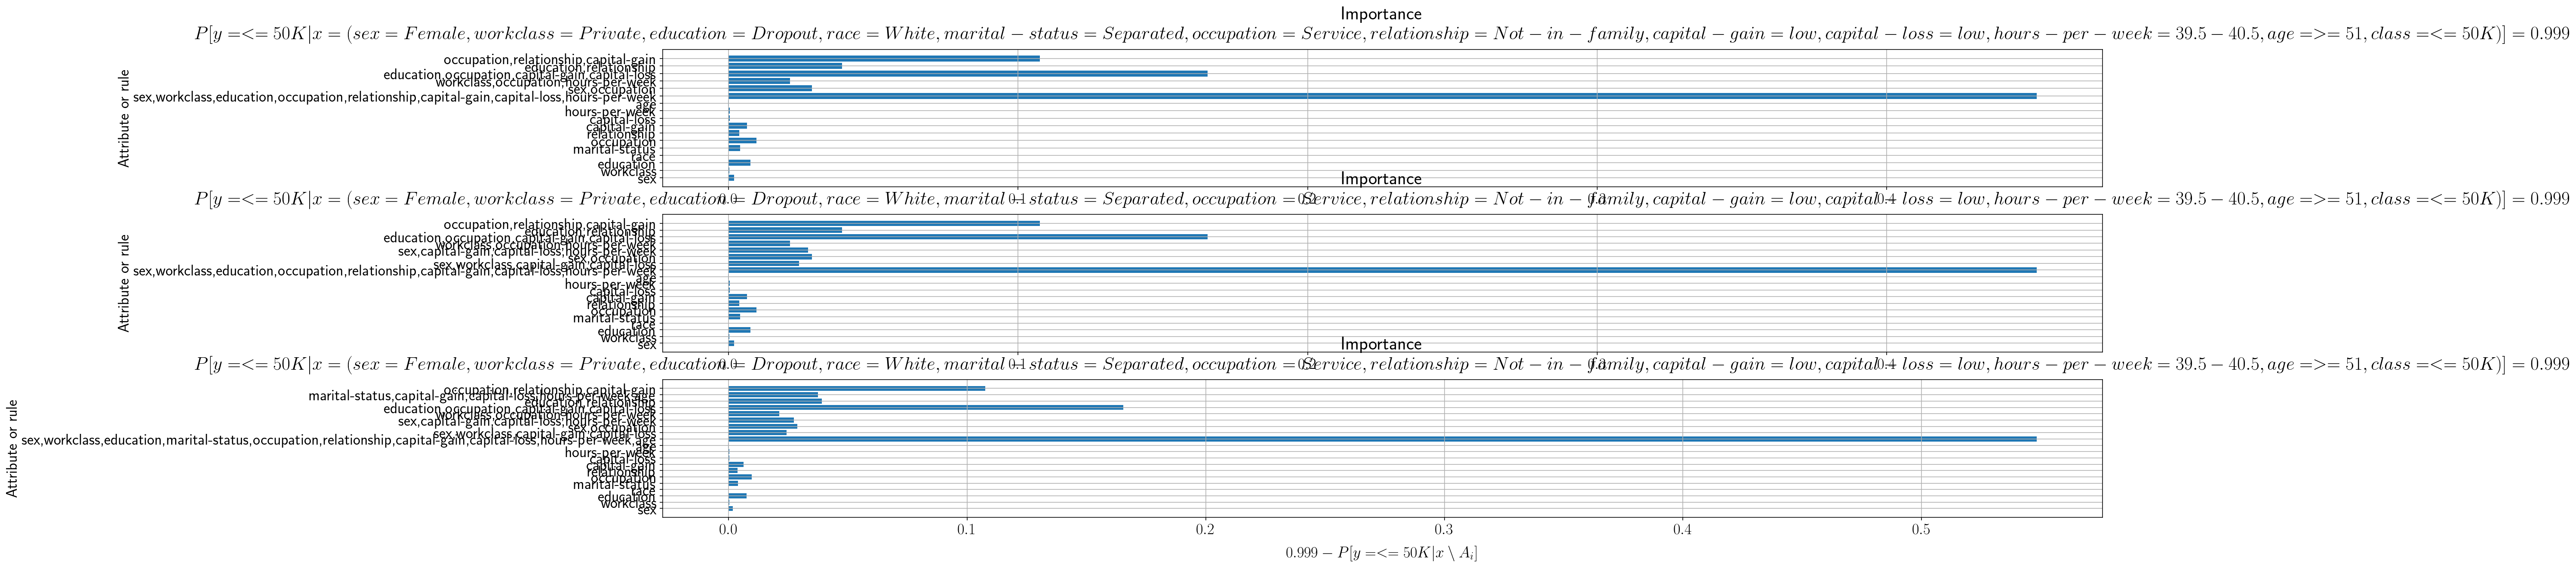

Instance 1
compute_lace_step k=118 0.01
final rules []
compute_lace_step k=236 0.01
{'body': [('capital-gain', 'low'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 192}
{'body': [('relationship', 'Unmarried'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 174}
{'body': [('relationship', 'Unmarried'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 139}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship', 'Wife'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '40.5-50.5'), ('age', '34-41')], 'class': '>50K', 'sup': 1}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Admin'), ('relationship', 'Wife'), ('capital-gain', 'high'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '34-41

explain_instance errors: 4.962E-01, 4.039E-01, 2.830E-02, 1.239E-02
compute_lace_step k=118 0.05
final rules []
compute_lace_step k=236 0.05
{'body': [('capital-gain', 'low'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 192}
{'body': [('relationship', 'Unmarried'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 174}
{'body': [('relationship', 'Unmarried'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 139}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship', 'Wife'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '40.5-50.5'), ('age', '34-41')], 'class': '>50K', 'sup': 1}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Admin'), ('relationship', 'Wife'), ('capital-gain', 'high'), ('capital-loss'

explain_instance errors: 4.962E-01, 4.039E-01, 2.830E-02, 1.239E-02
compute_lace_step k=118 0.075
final rules []
compute_lace_step k=236 0.075
{'body': [('capital-gain', 'low'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 192}
{'body': [('relationship', 'Unmarried'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 174}
{'body': [('relationship', 'Unmarried'), ('hours-per-week', '39.5-40.5')], 'class': '<=50K', 'sup': 139}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship', 'Wife'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '40.5-50.5'), ('age', '34-41')], 'class': '>50K', 'sup': 1}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'Black'), ('marital-status', 'Married'), ('occupation', 'Admin'), ('relationship', 'Wife'), ('capital-gain', 'high'), ('capital-los

explain_instance errors: 4.962E-01, 4.039E-01, 2.830E-02, 1.239E-02


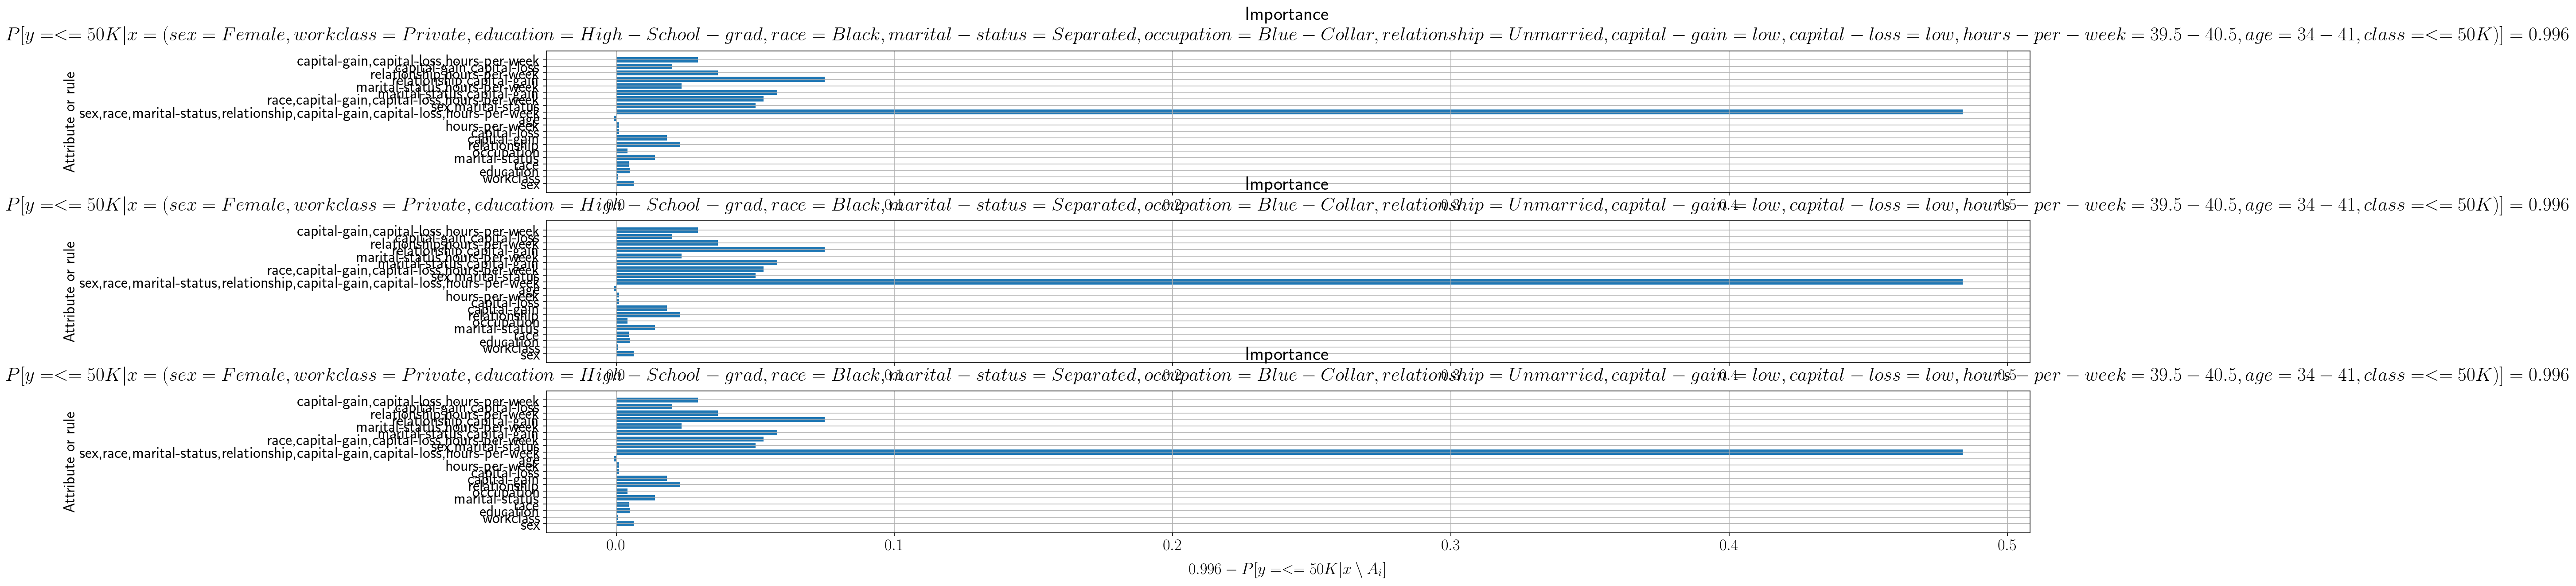

Instance 2
compute_lace_step k=118 0.01
final rules []
compute_lace_step k=236 0.01
final rules []
compute_lace_step k=354 0.01
{'body': [('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 233}
{'body': [('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 210}
{'body': [('marital-status', 'Never-married'), ('occupation', 'Blue-Collar')], 'class': '<=50K', 'sup': 174}
{'body': [('capital-gain', 'low'), ('age', '34-41')], 'class': '<=50K', 'sup': 123}
{'body': [('marital-status', 'Separated'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 95}
{'body': [('race', 'White'), ('relationship', 'Own-child')], 'class': '<=50K', 'sup': 94}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('race', 'White')], 'class': '<=50K', 'sup': 84}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship

{'body': [('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 257}
{'body': [('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 231}
{'body': [('marital-status', 'Never-married'), ('occupation', 'Blue-Collar')], 'class': '<=50K', 'sup': 195}
{'body': [('capital-gain', 'low'), ('age', '34-41')], 'class': '<=50K', 'sup': 137}
{'body': [('marital-status', 'Separated'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 108}
{'body': [('race', 'White'), ('relationship', 'Own-child')], 'class': '<=50K', 'sup': 106}
{'body': [('sex', 'Female'), ('race', 'White')], 'class': '<=50K', 'sup': 99}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship', 'Husband'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '26-33')], 'class': '>50K', 'sup': 92}
{'body'

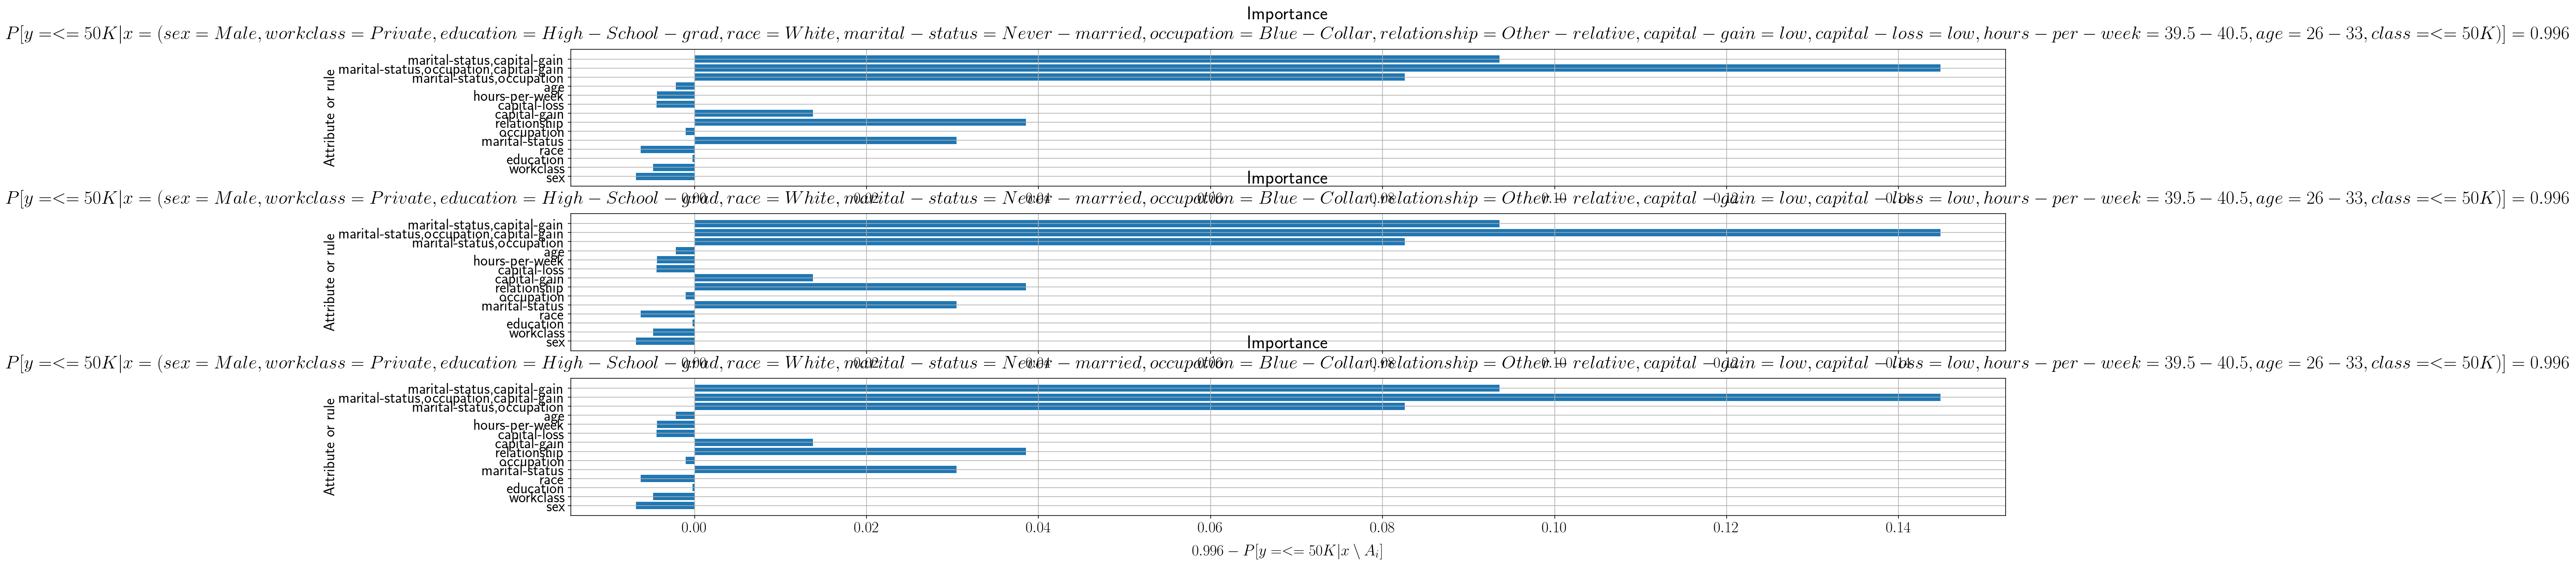

Instance 3
compute_lace_step k=118 0.01
{'body': [('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 97}
{'body': [('race', 'White'), ('marital-status', 'Never-married'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 90}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('relationship', 'Husband'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('age', '26-33')], 'class': '>50K', 'sup': 19}
final rules [[4, 5, 7, 8, 9], [4, 5, 8, 9], [4, 7, 8, 9]]
compute_lace_step k=236 0.01
{'body': [('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 164}
{'body': [('race', 'White'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 139}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-Scho

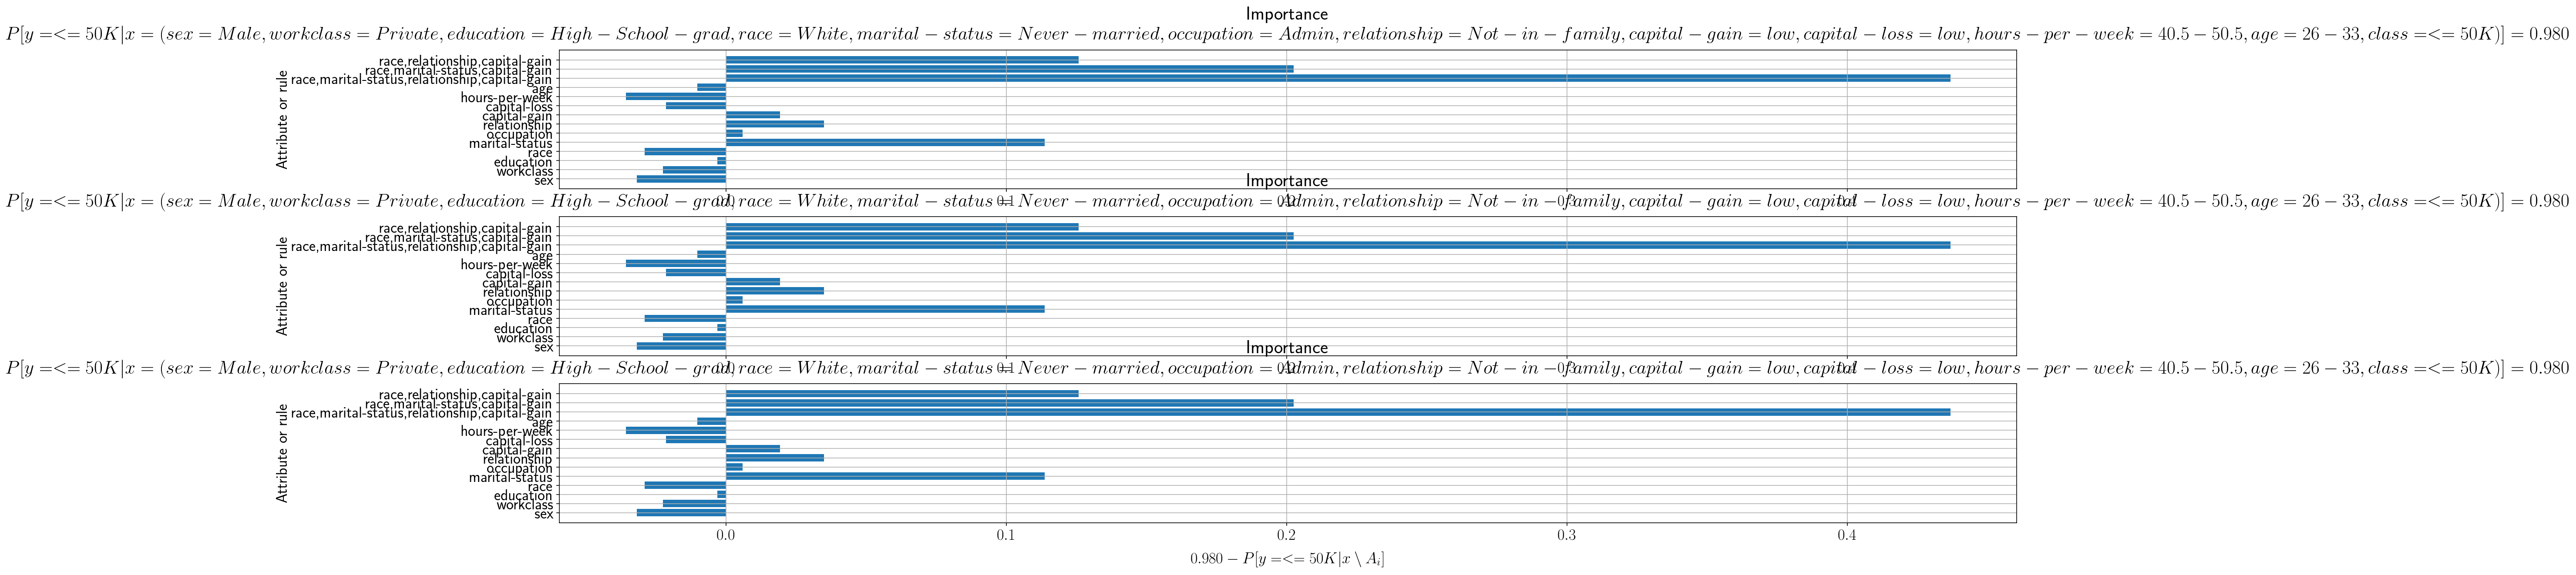

In [14]:
def run(i):
    print(f"Instance {i}")
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    plot(ax1, get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", 0.01))
    plot(ax2, get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", 0.05))
    plot(ax3, get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", 0.075))
    plt.show()

for i in range(4):
    run(i)

## Testing other values of `min_sup` for Monks - Categorical Naive Bayes

### Instance 2

Instance 2
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
final rules []
compute_lace_step k=423 0.01
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=564 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 368}
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('e', '1'), ('f', '3'), ('g', '1'), ('i', '2')], 'class': '1', 'sup': 3}
final rules [[5]]
explain_instance errors: 2.216E-01, 2.216E-01, 2.216E-01, 1.130E-02
compute_lace_step k=141 0.05
final rules []
compute_lace_step k=282 0.05
final rules []
compute_lace_step k=423 0.05
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '1'), ('h', '3'), ('i', '2'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=564 0.05
{'body': [('e', '3')], 'class': '0', 'sup': 368}
{'body': [('a', '1'), ('b', '3'), ('c', '3'), ('e', '1

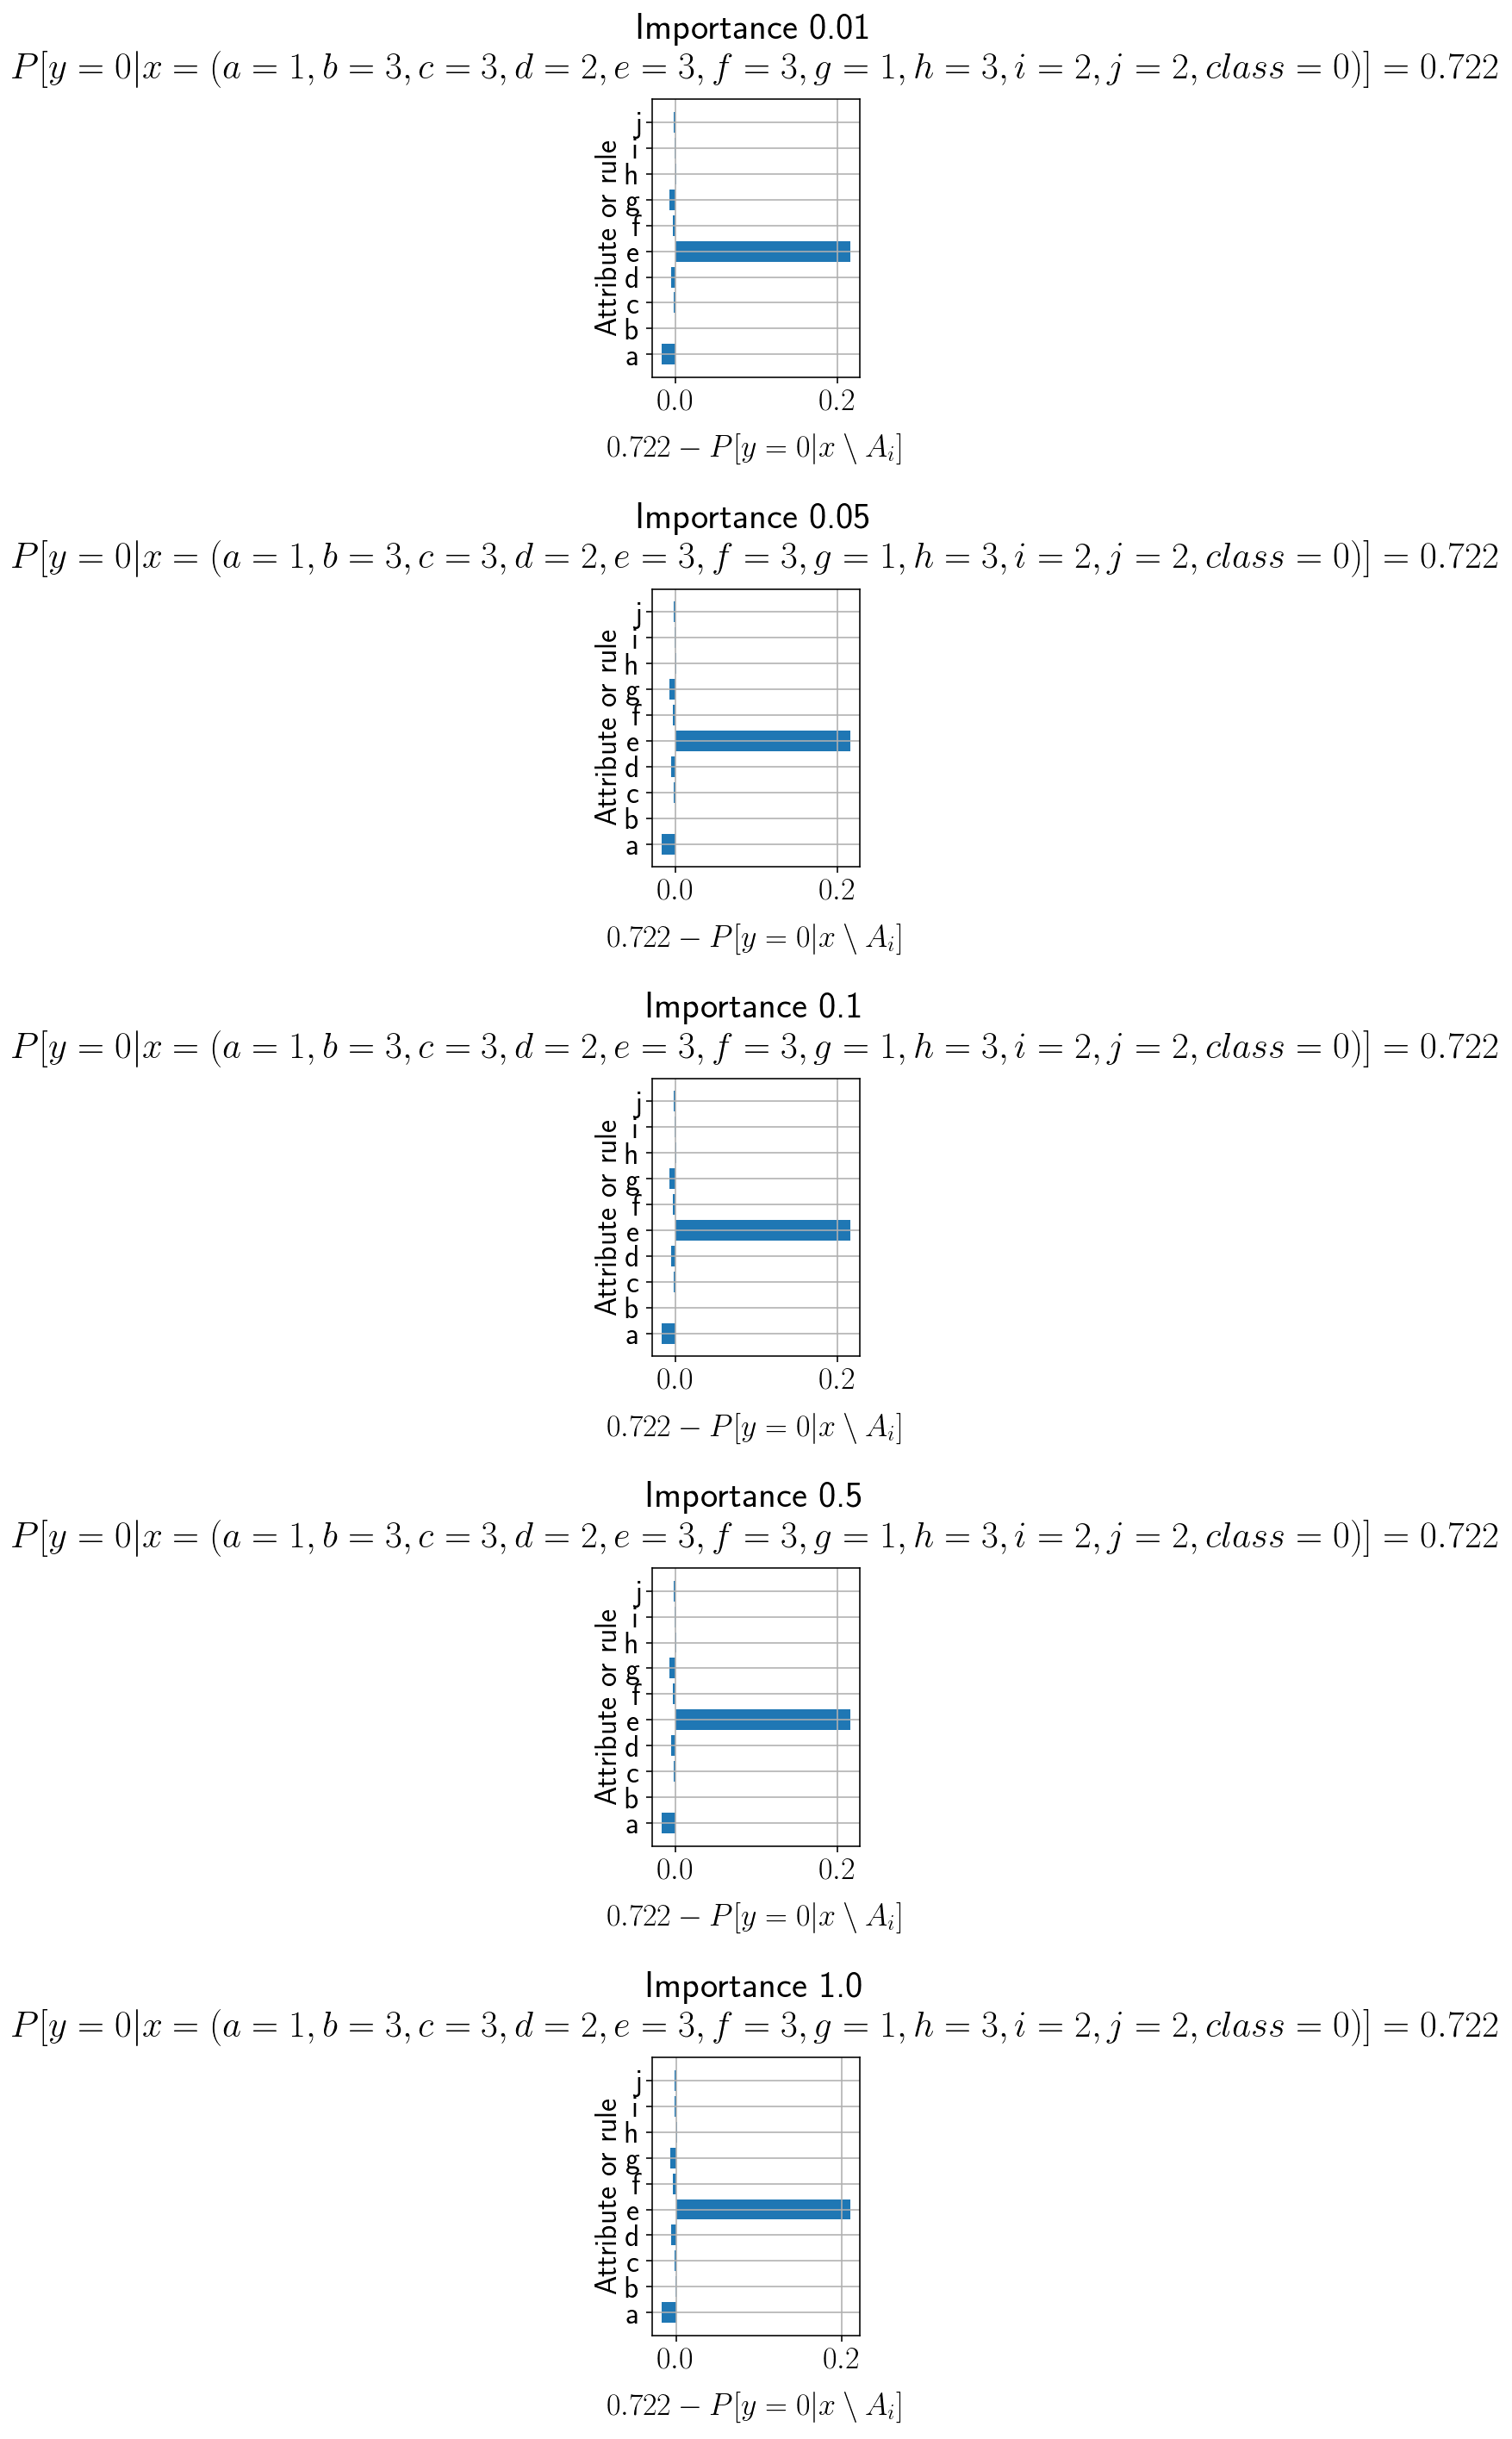

In [13]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_title(
        f"""Importance {min_sup}
        $P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
        )
        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(2)

### Instance 3

Instance 3
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
{'body': [('a', '3'), ('b', '1'), ('c', '2'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '3'), ('h', '3'), ('i', '1'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=423 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 284}
{'body': [('a', '3'), ('b', '1'), ('e', '1'), ('f', '3'), ('h', '3')], 'class': '1', 'sup': 4}
final rules [[5]]
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute_lace_step k=141 0.05
final rules []
compute_lace_step k=282 0.05
{'body': [('a', '3'), ('b', '1'), ('c', '2'), ('d', '2'), ('e', '1'), ('f', '3'), ('g', '3'), ('h', '3'), ('i', '1'), ('j', '3')], 'class': '1', 'sup': 1}
final rules []
compute_lace_step k=423 0.05
{'body': [('e', '3')], 'class': '0', 'sup': 284}
{'body': [('a', '3'), ('b', '1'), ('e', '1'), ('f', '3'), ('h', '3')], 'class': '1', 'sup': 4}
final rules [[5]]
explain_instance errors: 2.231E-01, 2.231E-01, 7.115E-03
compute

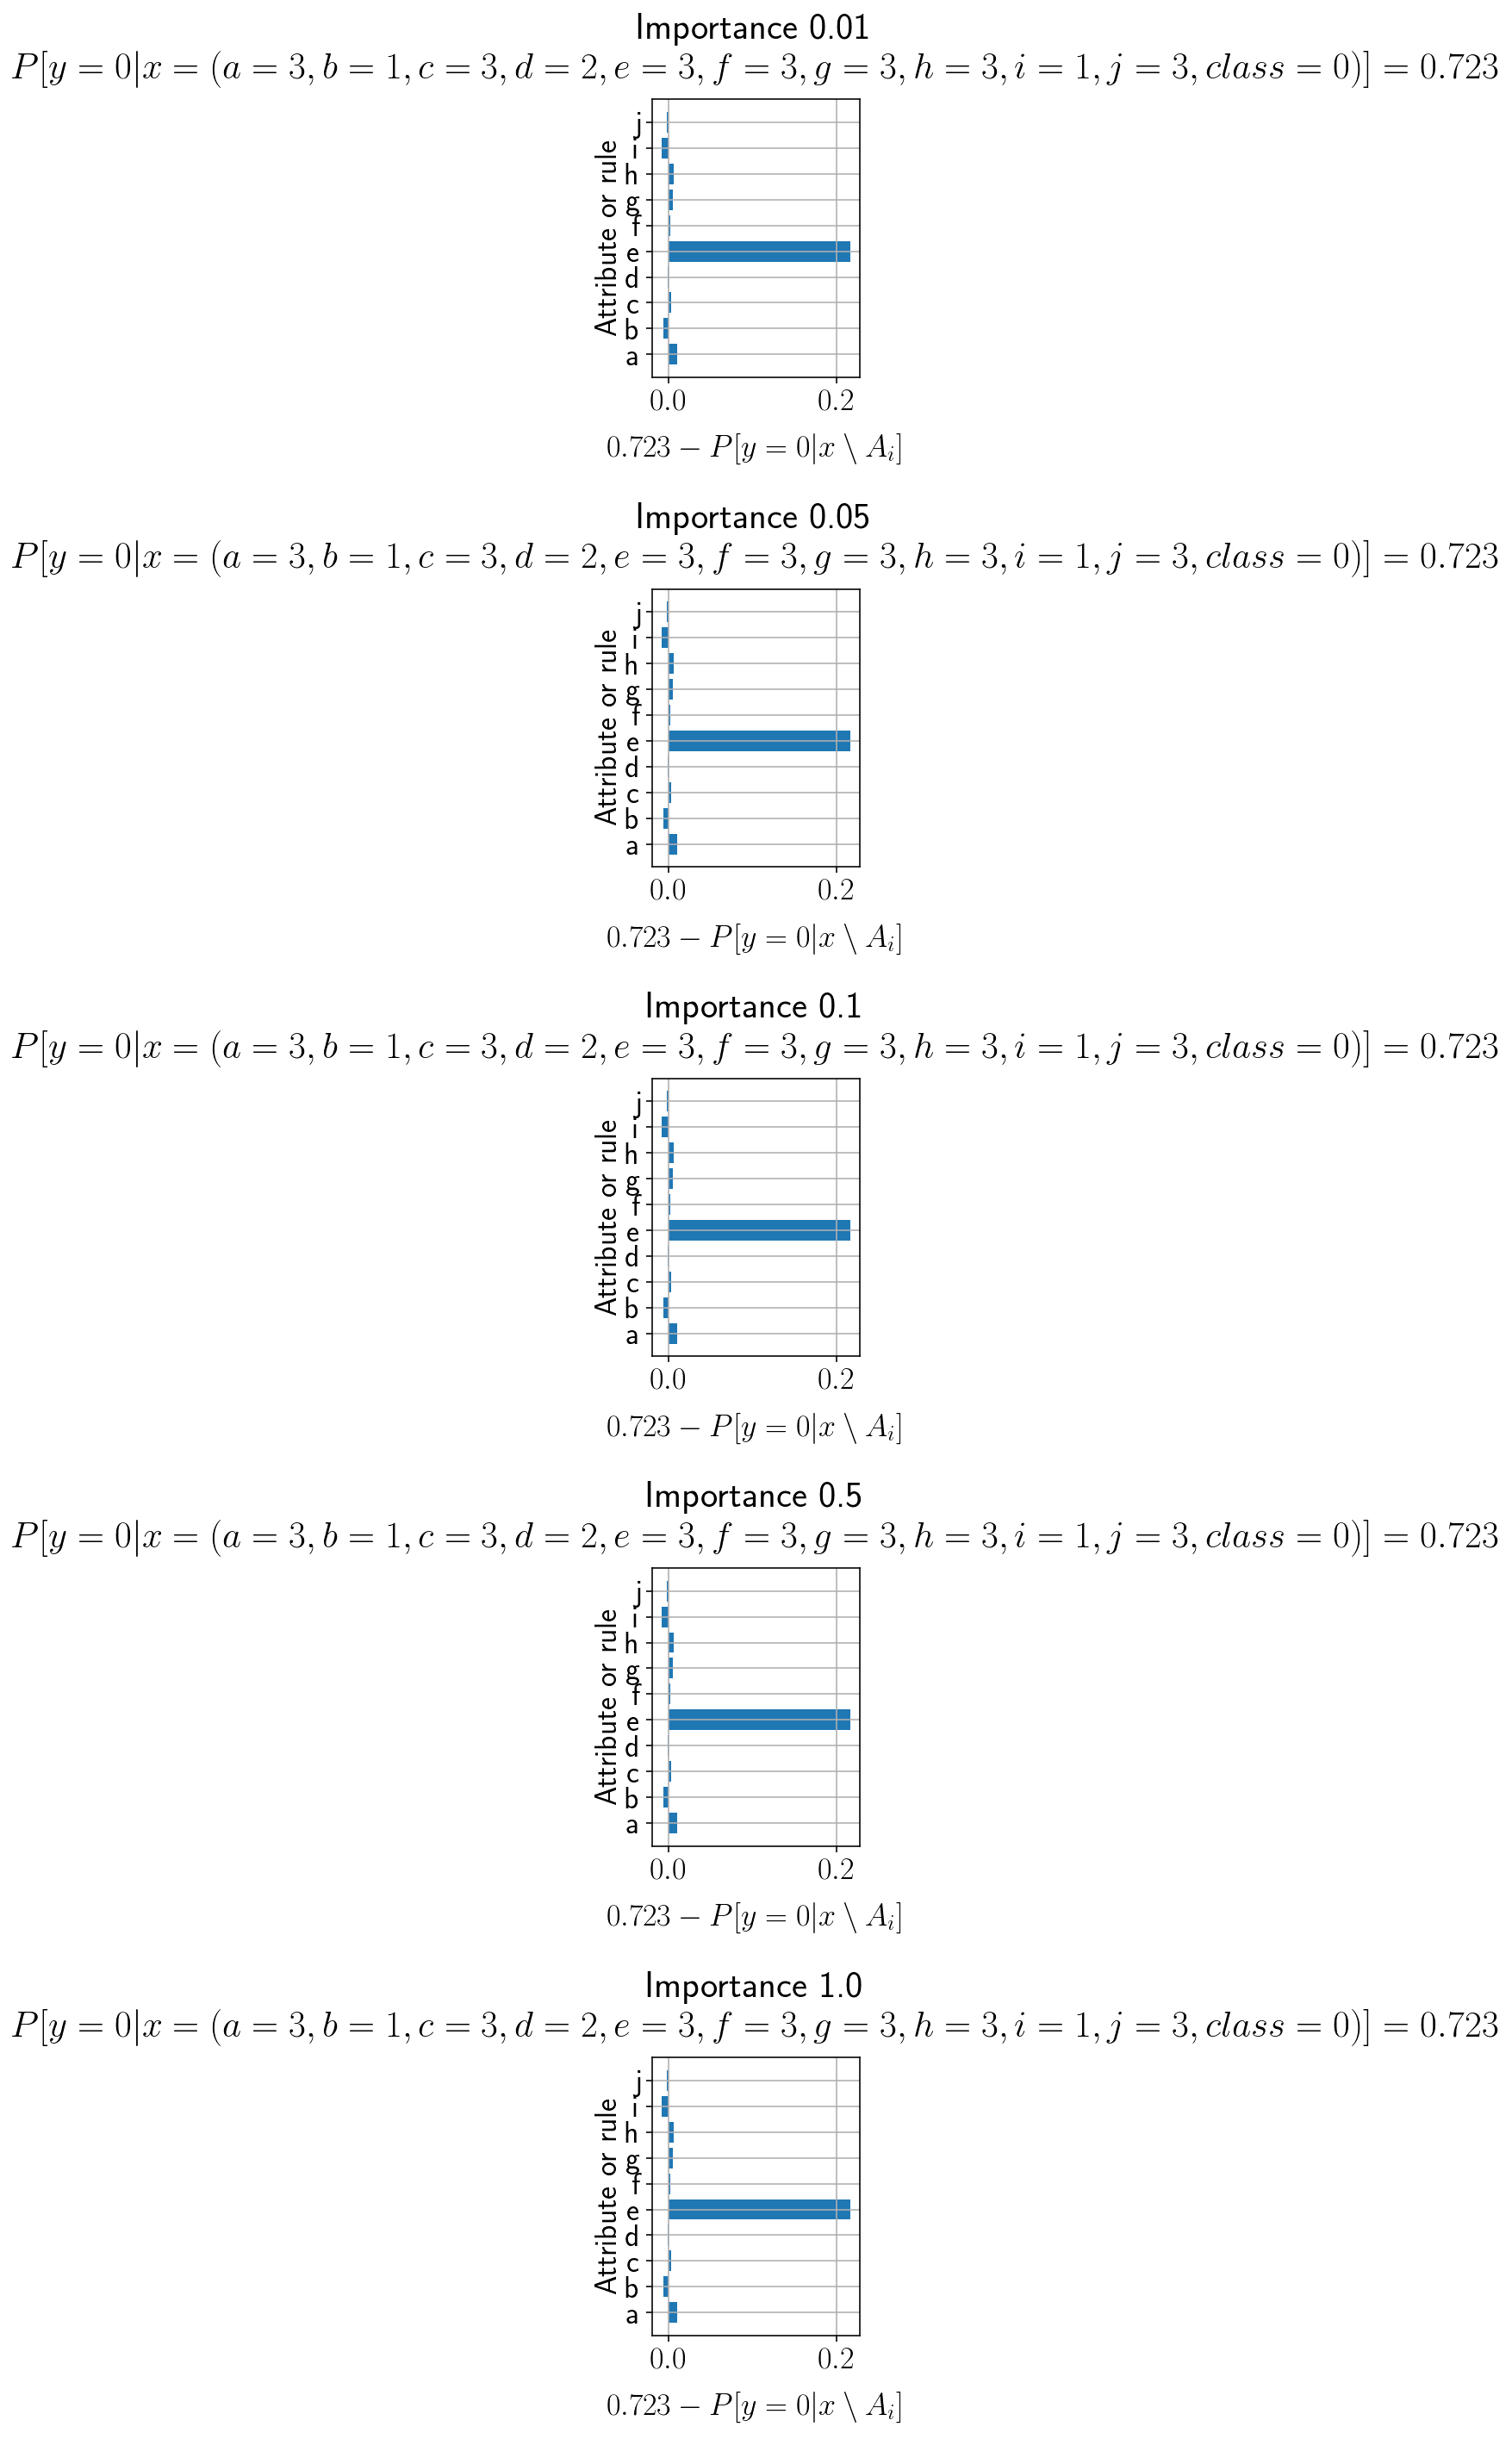

In [20]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_title(
        f"""Importance {min_sup}
        $P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
        )
        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(3)

### Instance 4

Instance 4
compute_lace_step k=141 0.01
{'body': [('e', '2')], 'class': '0', 'sup': 82}
{'body': [('e', '3')], 'class': '0', 'sup': 33}
{'body': [('e', '1')], 'class': '1', 'sup': 27}
final rules [[5]]
explain_instance errors: 1.647E-03
compute_lace_step k=141 0.05
{'body': [('e', '2')], 'class': '0', 'sup': 82}
{'body': [('e', '3')], 'class': '0', 'sup': 33}
{'body': [('e', '1')], 'class': '1', 'sup': 27}
final rules [[5]]
explain_instance errors: 1.647E-03
compute_lace_step k=141 0.1
{'body': [('e', '2')], 'class': '0', 'sup': 82}
{'body': [('e', '3')], 'class': '0', 'sup': 33}
{'body': [('e', '1')], 'class': '1', 'sup': 27}
final rules [[5]]
explain_instance errors: 1.647E-03
compute_lace_step k=141 0.5
{'body': [('e', '2')], 'class': '0', 'sup': 82}
{'body': [('e', '1')], 'class': '1', 'sup': 27}
final rules [[5]]
explain_instance errors: 1.647E-03
compute_lace_step k=141 1.0
{'body': [('e', '1')], 'class': '1', 'sup': 27}
final rules []
compute_lace_step k=282 1.0
{'body': [('e', 

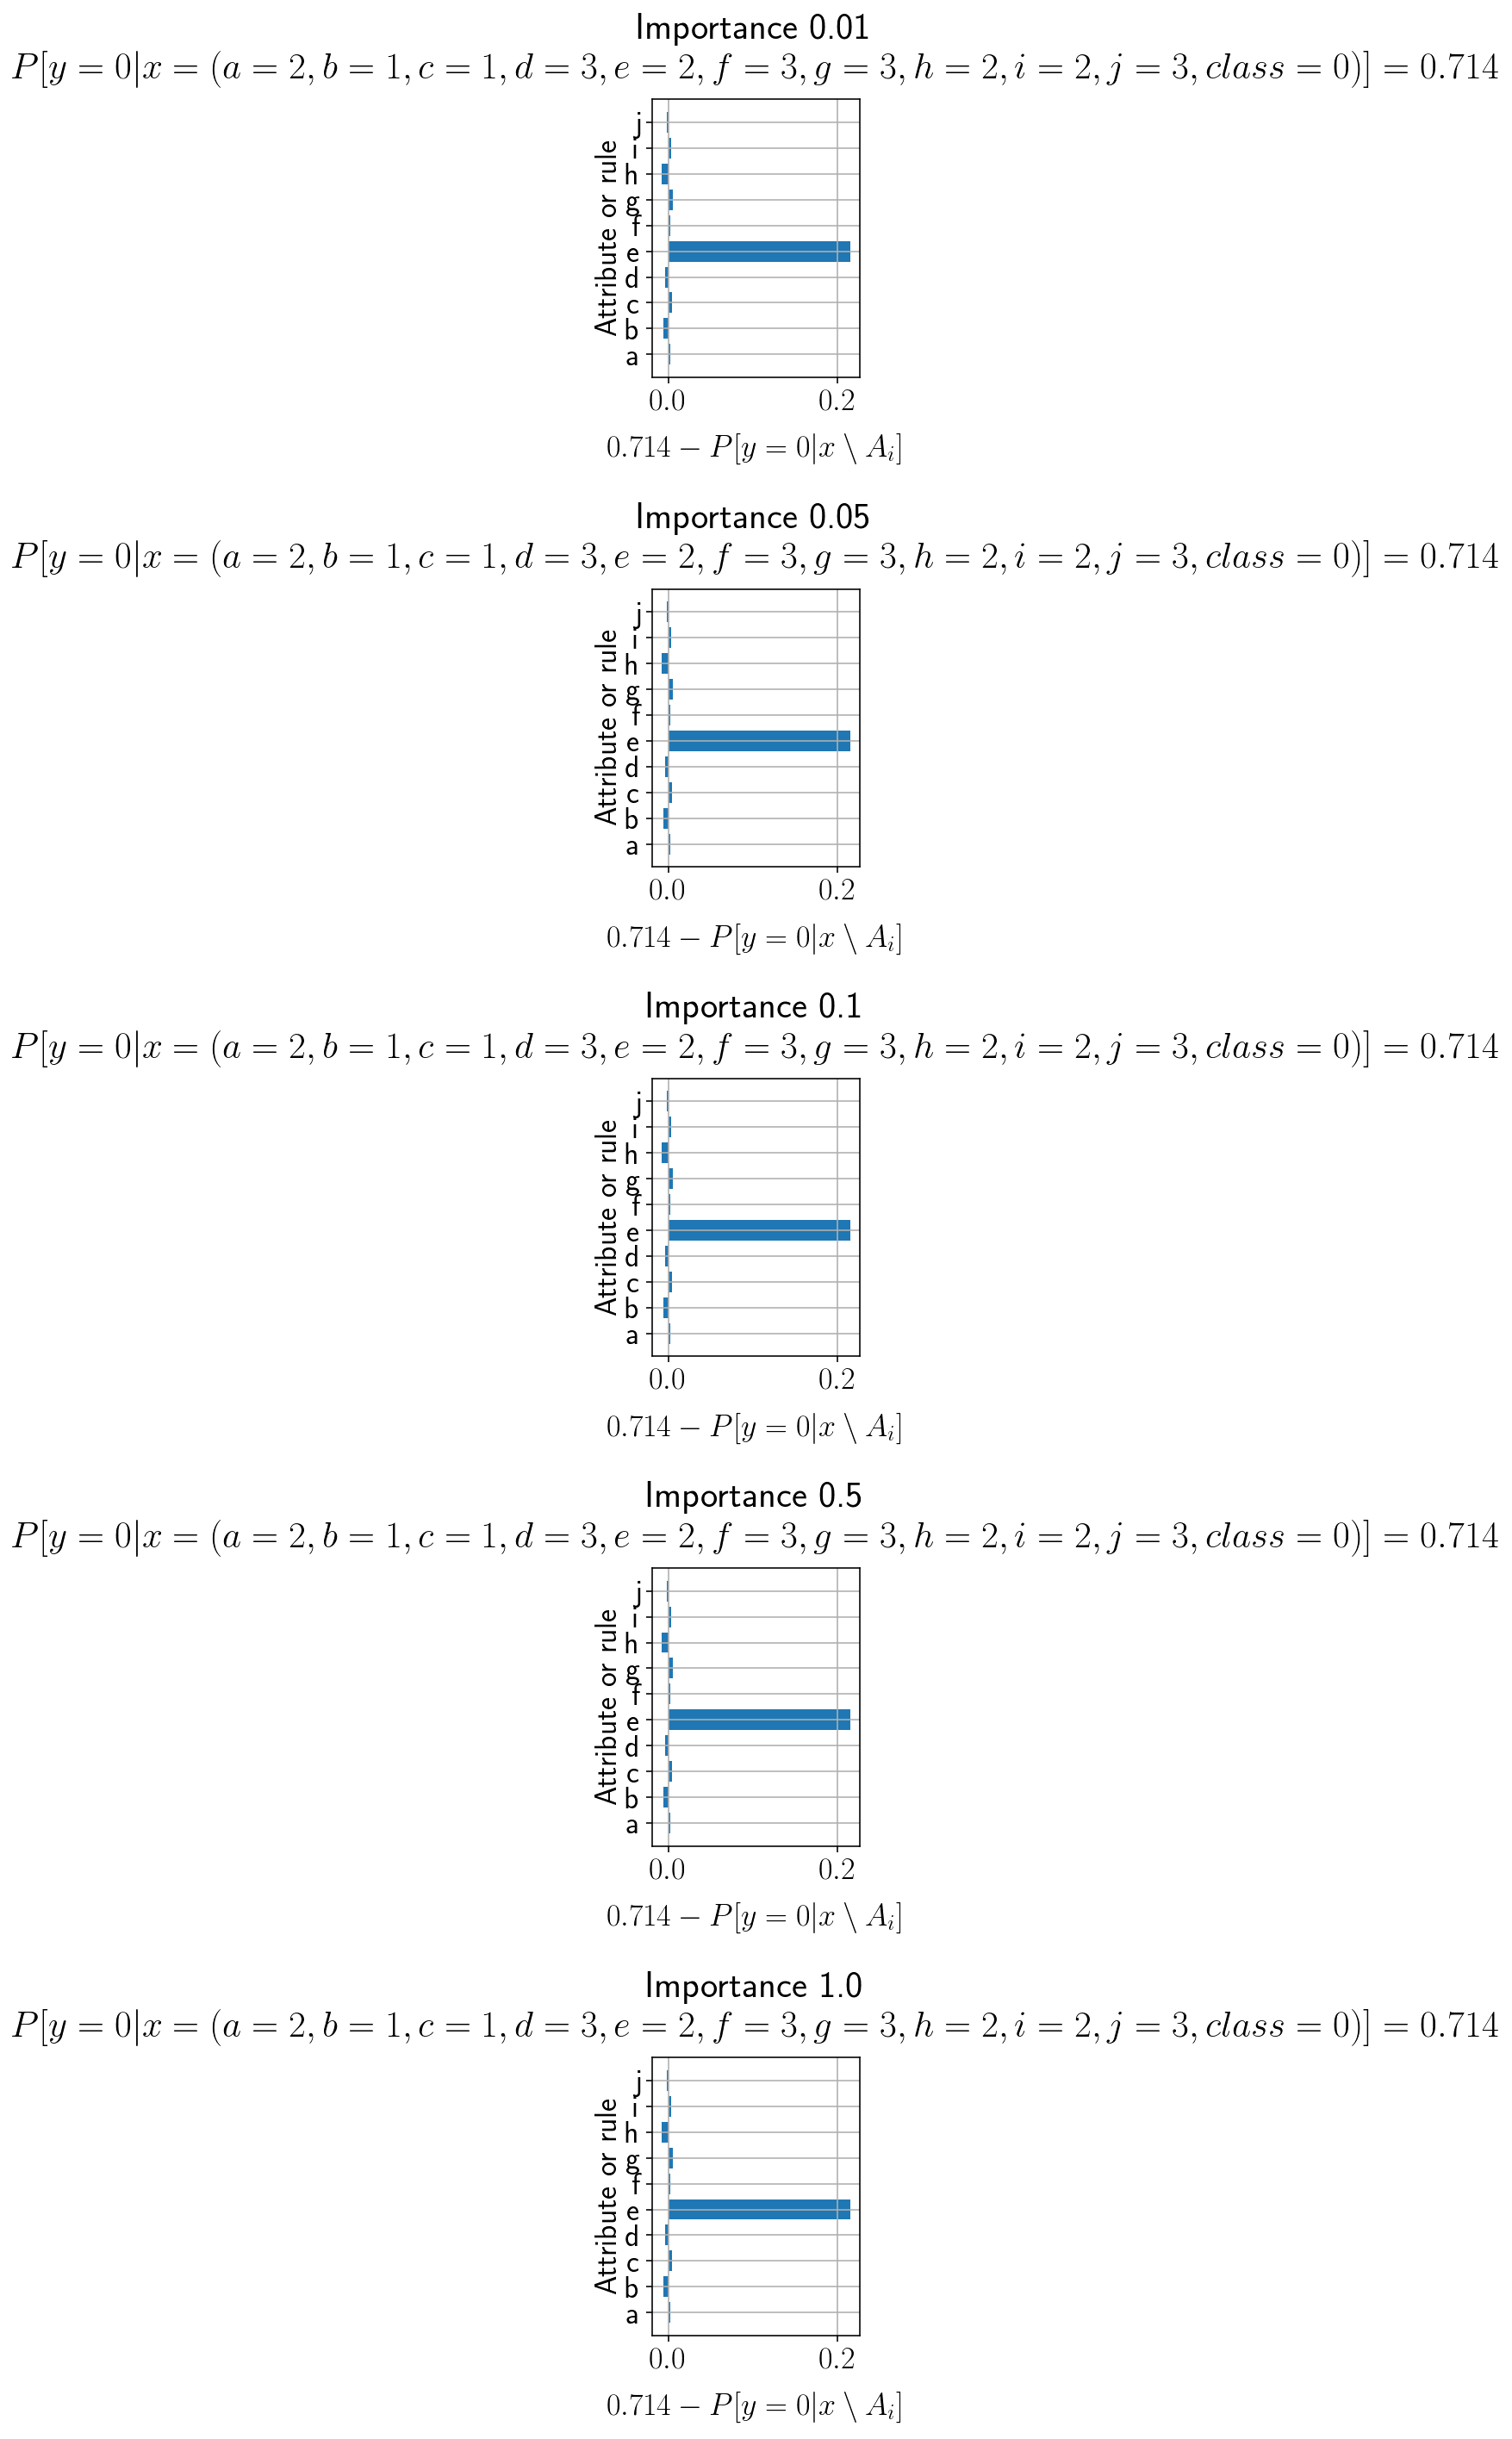

In [21]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_title(
        f"""Importance {min_sup}
        $P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
        )
        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(4)

### Instance 5

Instance 5
compute_lace_step k=141 0.01
final rules []
compute_lace_step k=282 0.01
final rules []
compute_lace_step k=423 0.01
{'body': [('a', '3'), ('c', '1'), ('e', '1'), ('f', '2'), ('g', '3'), ('h', '2'), ('i', '1'), ('j', '1')], 'class': '1', 'sup': 2}
final rules []
compute_lace_step k=564 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 343}
{'body': [('a', '3'), ('e', '1'), ('i', '1')], 'class': '1', 'sup': 6}
final rules []
compute_lace_step k=705 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 423}
{'body': [('a', '2')], 'class': '0', 'sup': 272}
{'body': [('e', '2')], 'class': '0', 'sup': 268}
{'body': [('a', '3'), ('e', '1')], 'class': '1', 'sup': 15}
final rules []
compute_lace_step k=846 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 502}
{'body': [('e', '2')], 'class': '0', 'sup': 320}
{'body': [('e', '1')], 'class': '1', 'sup': 25}
final rules []
compute_lace_step k=987 0.01
{'body': [('e', '3')], 'class': '0', 'sup': 579}
{'body': [('e', '2')], 'class': '0', 'sup':

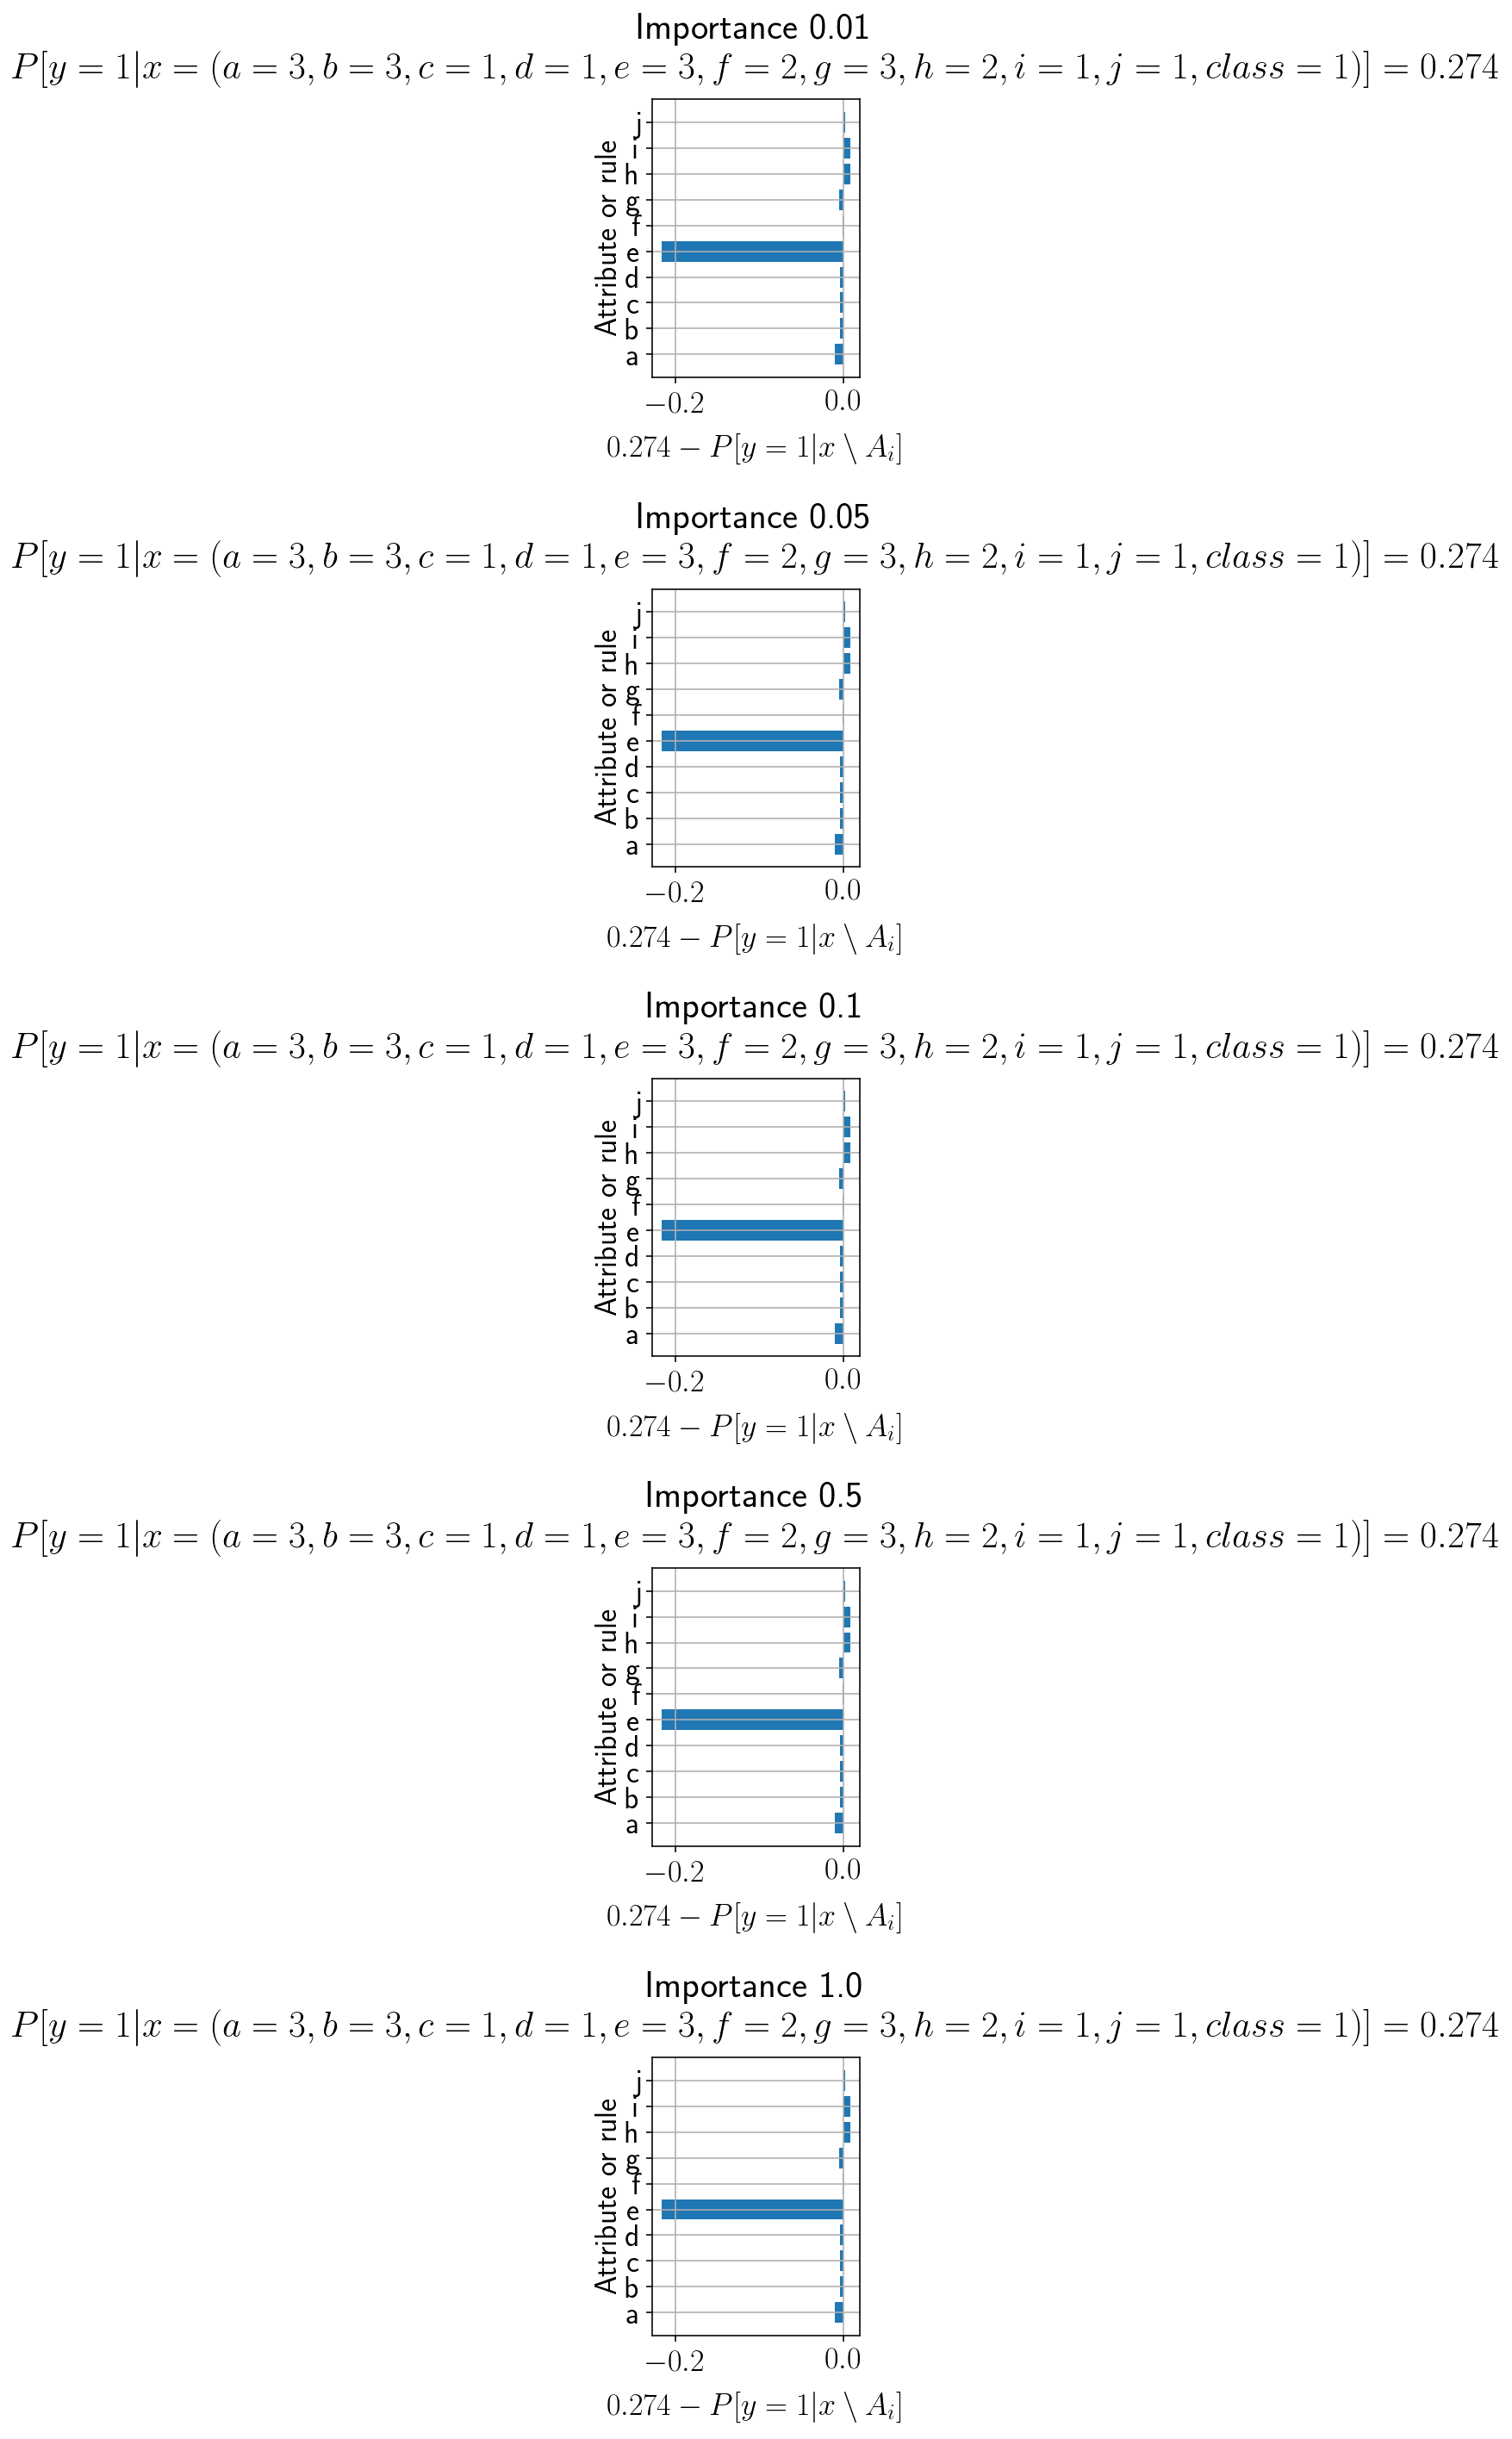

In [22]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_title(
        f"""Importance {min_sup}
        $P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
        )
        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/monks_extended.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(5)

## Testing other values of `min_sup` for Adult - Categorical Naive Bayes

### Instance 2

Instance 2
compute_lace_step k=118 0.01
final rules []
compute_lace_step k=236 0.01
final rules []
compute_lace_step k=354 0.01
{'body': [('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 233}
{'body': [('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 210}
{'body': [('marital-status', 'Never-married'), ('occupation', 'Blue-Collar')], 'class': '<=50K', 'sup': 174}
{'body': [('capital-gain', 'low'), ('age', '34-41')], 'class': '<=50K', 'sup': 123}
{'body': [('marital-status', 'Separated'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 95}
{'body': [('race', 'White'), ('relationship', 'Own-child')], 'class': '<=50K', 'sup': 94}
{'body': [('sex', 'Female'), ('workclass', 'Private'), ('race', 'White')], 'class': '<=50K', 'sup': 84}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship

{'body': [('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 257}
{'body': [('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 231}
{'body': [('marital-status', 'Never-married'), ('occupation', 'Blue-Collar')], 'class': '<=50K', 'sup': 195}
{'body': [('capital-gain', 'low'), ('age', '34-41')], 'class': '<=50K', 'sup': 137}
{'body': [('marital-status', 'Separated'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 108}
{'body': [('race', 'White'), ('relationship', 'Own-child')], 'class': '<=50K', 'sup': 106}
{'body': [('sex', 'Female'), ('race', 'White')], 'class': '<=50K', 'sup': 99}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('occupation', 'Blue-Collar'), ('relationship', 'Husband'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '39.5-40.5'), ('age', '26-33')], 'class': '>50K', 'sup': 92}
{'body'

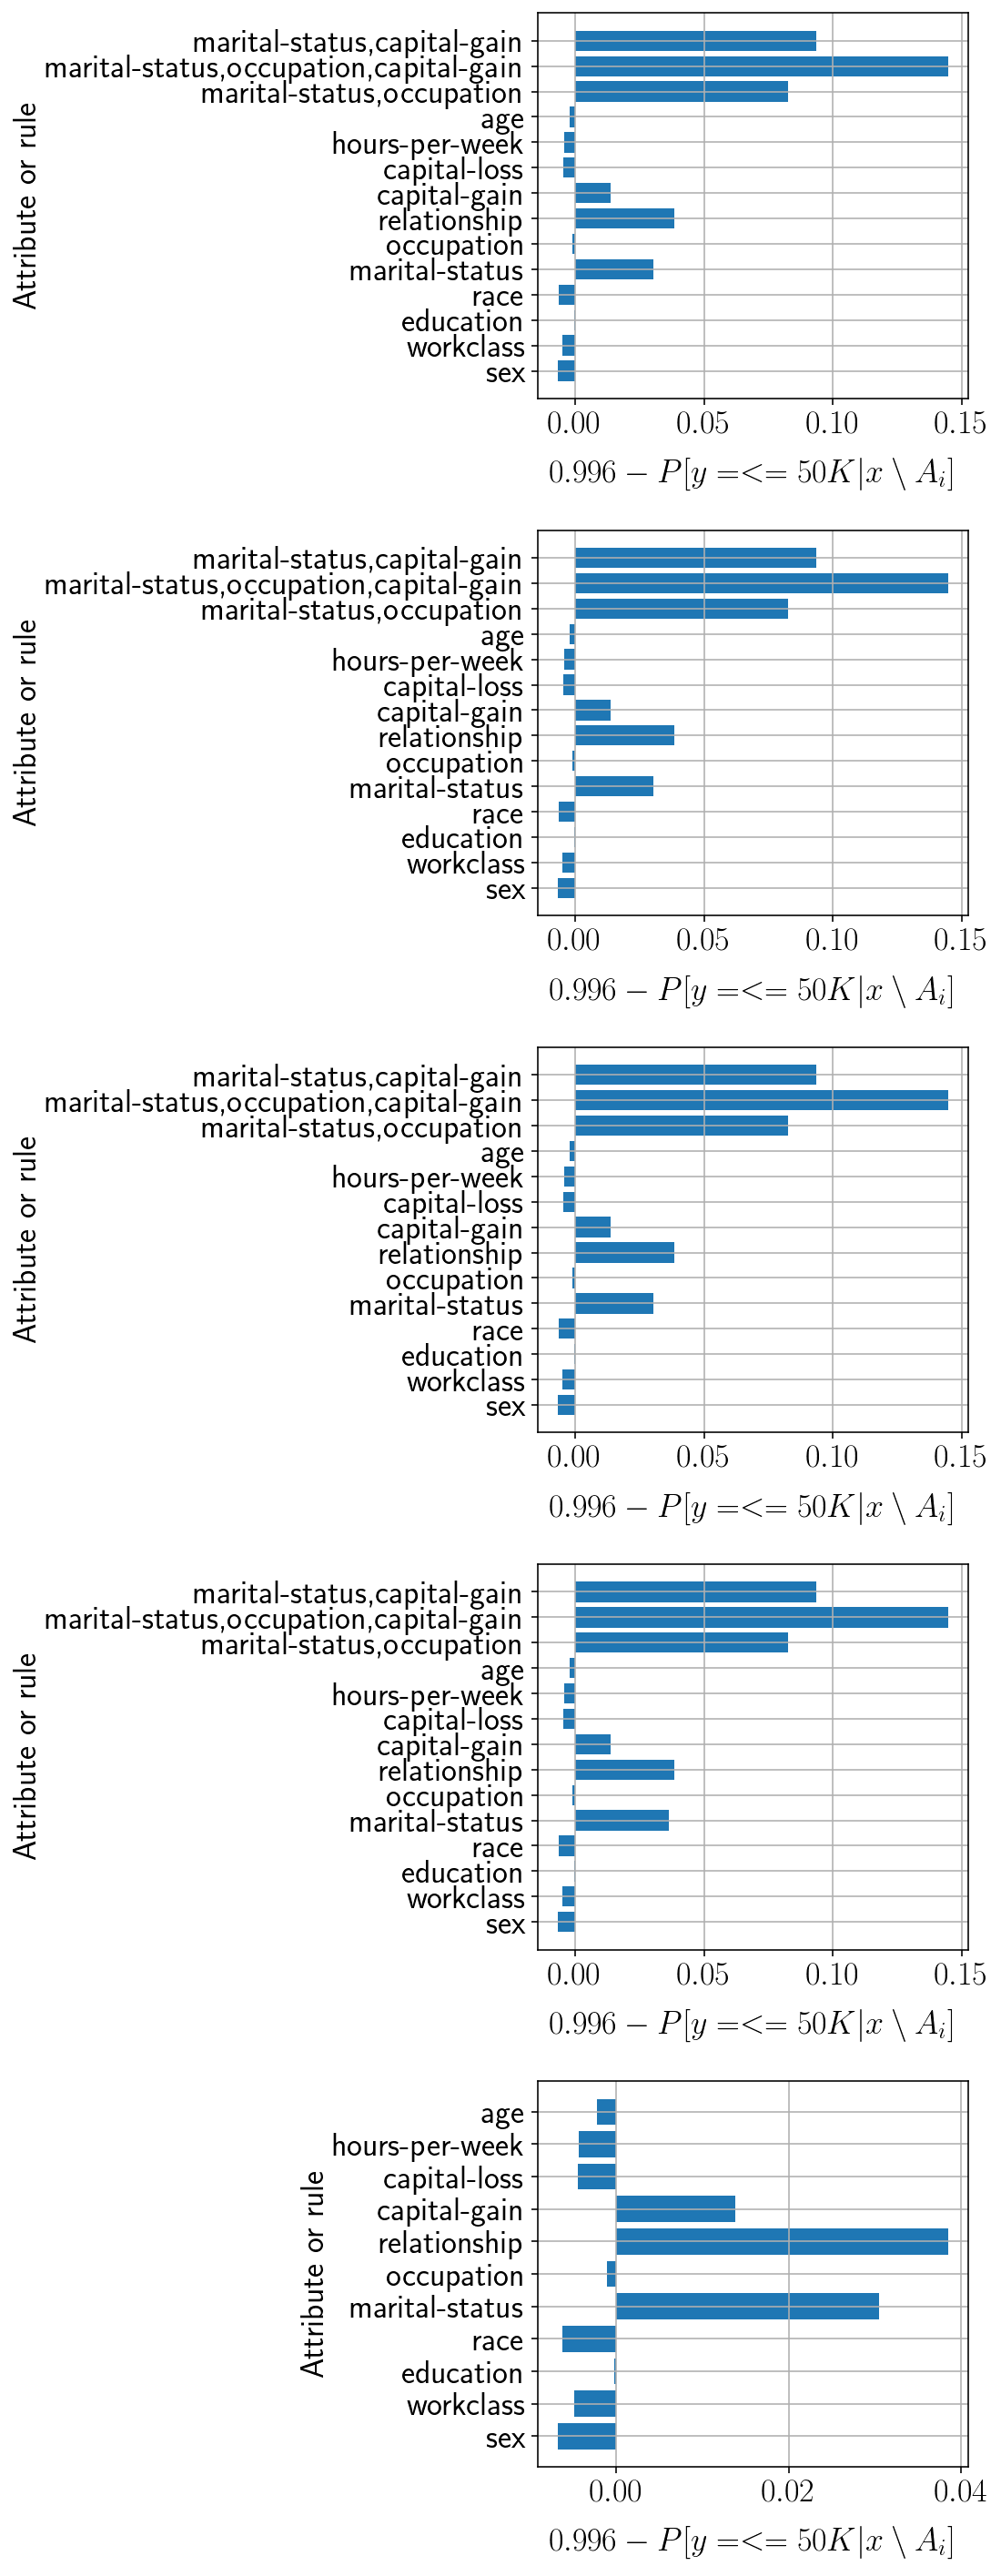

In [17]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(2)

### Instance 3

Instance 3
compute_lace_step k=118 0.01
{'body': [('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 97}
{'body': [('race', 'White'), ('marital-status', 'Never-married'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 90}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-School-grad'), ('race', 'White'), ('marital-status', 'Married'), ('relationship', 'Husband'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('age', '26-33')], 'class': '>50K', 'sup': 19}
final rules [[4, 5, 7, 8, 9], [4, 5, 8, 9], [4, 7, 8, 9]]
compute_lace_step k=236 0.01
{'body': [('race', 'White'), ('relationship', 'Not-in-family'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 164}
{'body': [('race', 'White'), ('marital-status', 'Never-married'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 139}
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('education', 'High-Scho

{'body': [('race', 'White'), ('capital-gain', 'low')], 'class': '<=50K', 'sup': 171}
final rules [[4, 8]]
compute_lace_step k=354 1.0
{'body': [('capital-gain', 'low')], 'class': '<=50K', 'sup': 209}
final rules [[8]]
explain_instance errors: 4.803E-01, 4.352E-01, 4.611E-01


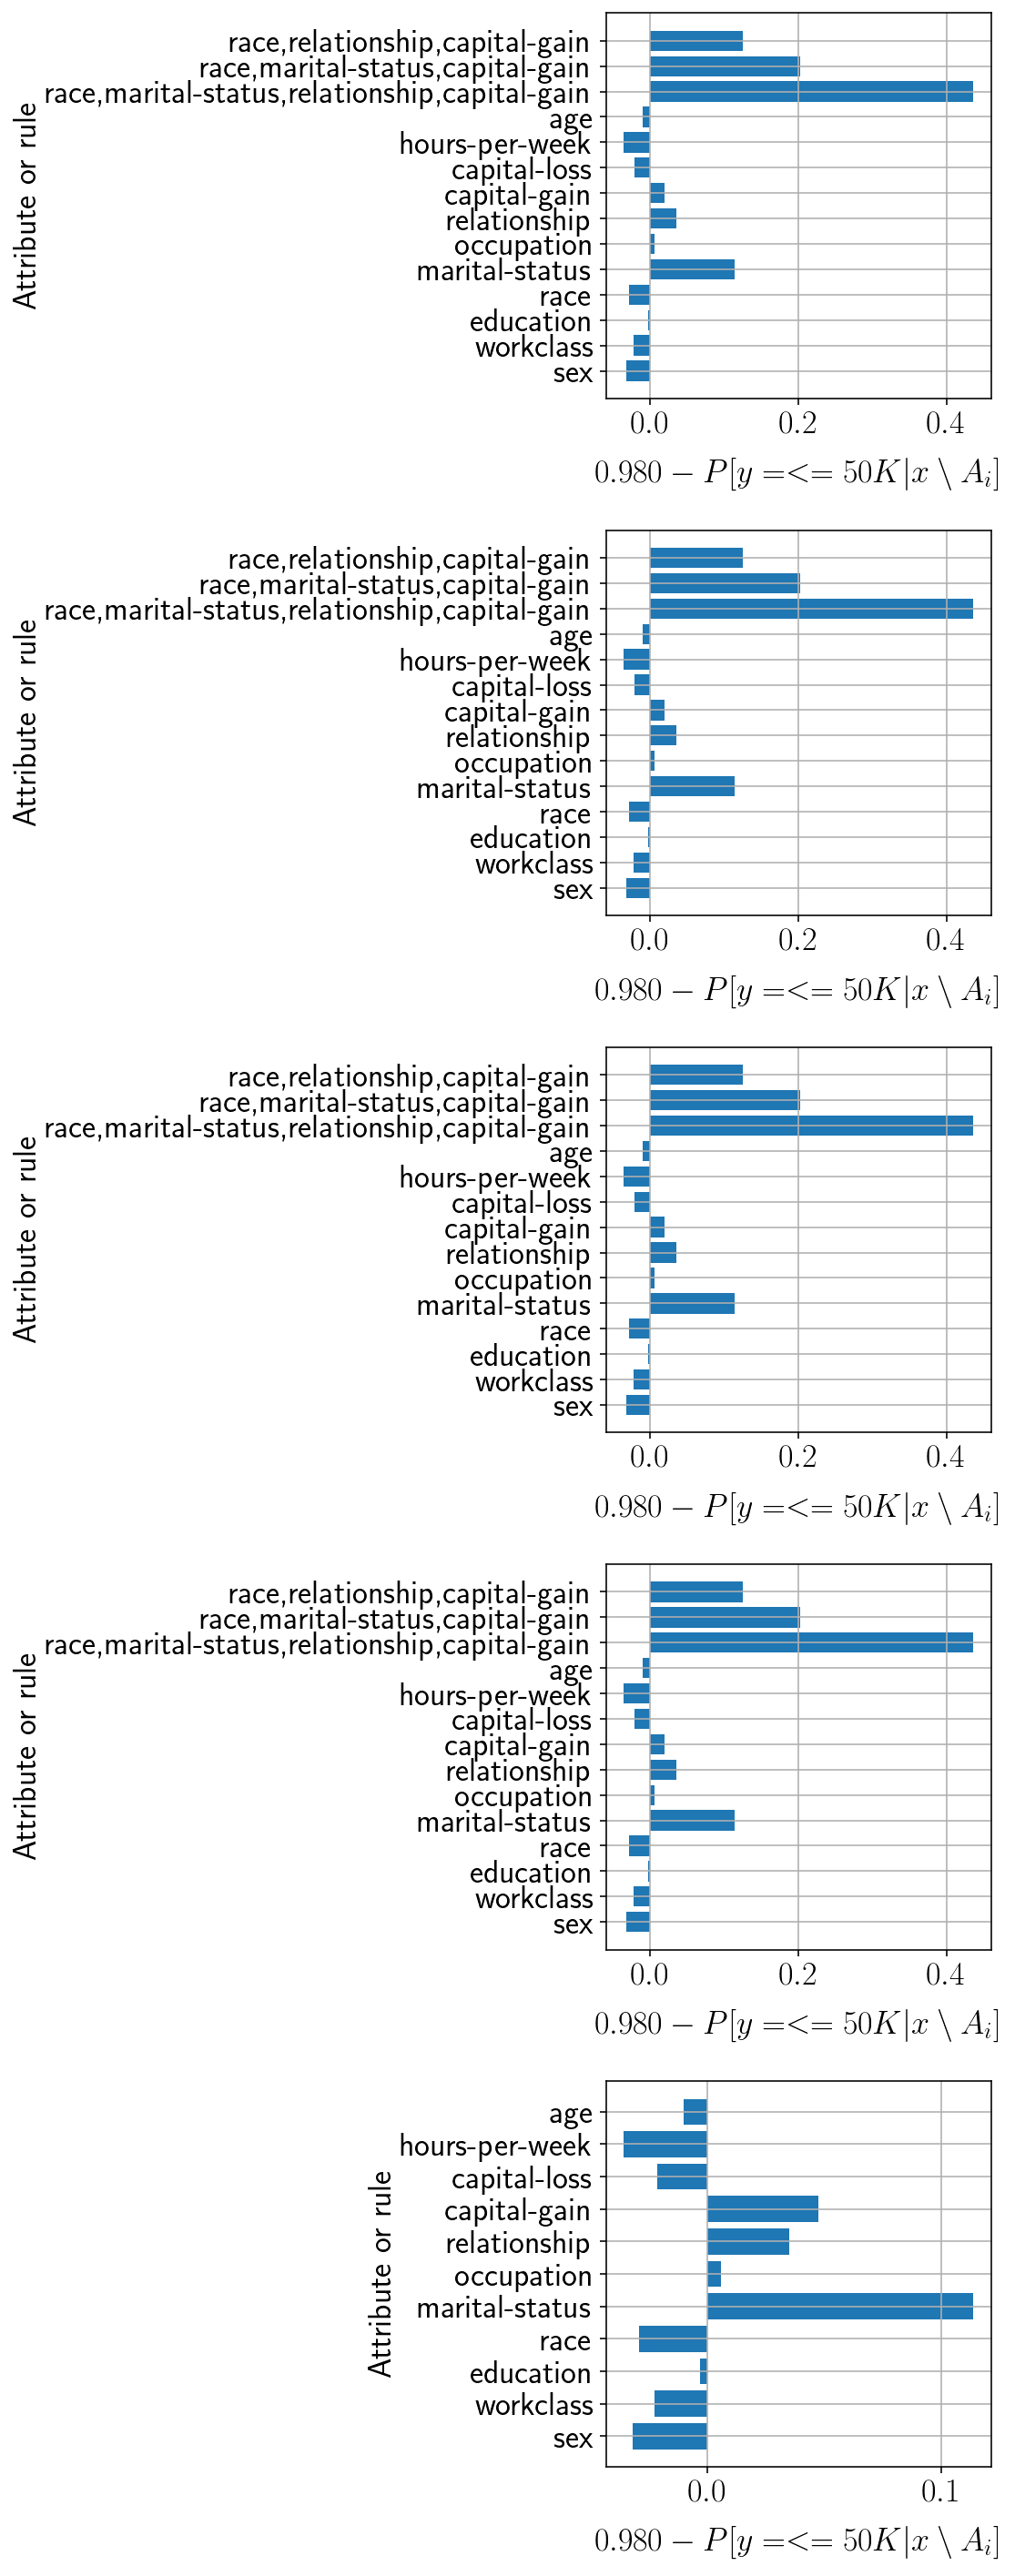

In [18]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(3)

### Instance 4

Instance 4
compute_lace_step k=118 0.01
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 87}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 83}
{'body': [('workclass', 'Private'), ('marital-status', 'Never-married'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 16}
{'body': [('sex', 'Male'), ('education', 'Bachelors'), ('race', 'White'), ('occupation', 'Service'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '<39.5'), ('age', '26-33')], 'class': '<=50K', 'sup': 2}
final rules []
compute_lace_step k=236 0.01
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 175}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 140}
{

compute_lace_step k=118 0.05
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 87}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 83}
{'body': [('workclass', 'Private'), ('marital-status', 'Never-married'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 16}
{'body': [('sex', 'Male'), ('education', 'Bachelors'), ('race', 'White'), ('occupation', 'Service'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '<39.5'), ('age', '26-33')], 'class': '<=50K', 'sup': 2}
final rules []
compute_lace_step k=236 0.05
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 175}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 140}
{'body': [('

compute_lace_step k=118 0.1
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 87}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 83}
{'body': [('workclass', 'Private'), ('marital-status', 'Never-married'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 16}
{'body': [('sex', 'Male'), ('education', 'Bachelors'), ('race', 'White'), ('occupation', 'Service'), ('capital-gain', 'low'), ('capital-loss', 'low'), ('hours-per-week', '<39.5'), ('age', '26-33')], 'class': '<=50K', 'sup': 2}
final rules []
compute_lace_step k=236 0.1
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 175}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 140}
{'body': [('se

compute_lace_step k=118 0.5
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 87}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 83}
{'body': [('workclass', 'Private'), ('marital-status', 'Never-married'), ('relationship', 'Not-in-family'), ('capital-gain', 'low'), ('capital-loss', 'low')], 'class': '<=50K', 'sup': 16}
final rules []
compute_lace_step k=236 0.5
{'body': [('sex', 'Male'), ('workclass', 'Private'), ('race', 'White'), ('marital-status', 'Married')], 'class': '>50K', 'sup': 175}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('hours-per-week', '>=50.5')], 'class': '>50K', 'sup': 140}
{'body': [('sex', 'Male'), ('marital-status', 'Married'), ('occupation', 'Sales'), ('relationship', 'Husband')], 'class': '>50K', 'sup': 106}
{'body': [('workclass', 'Private'), ('marital-status', 'Never-married'), ('relationship', 'Not-in-f

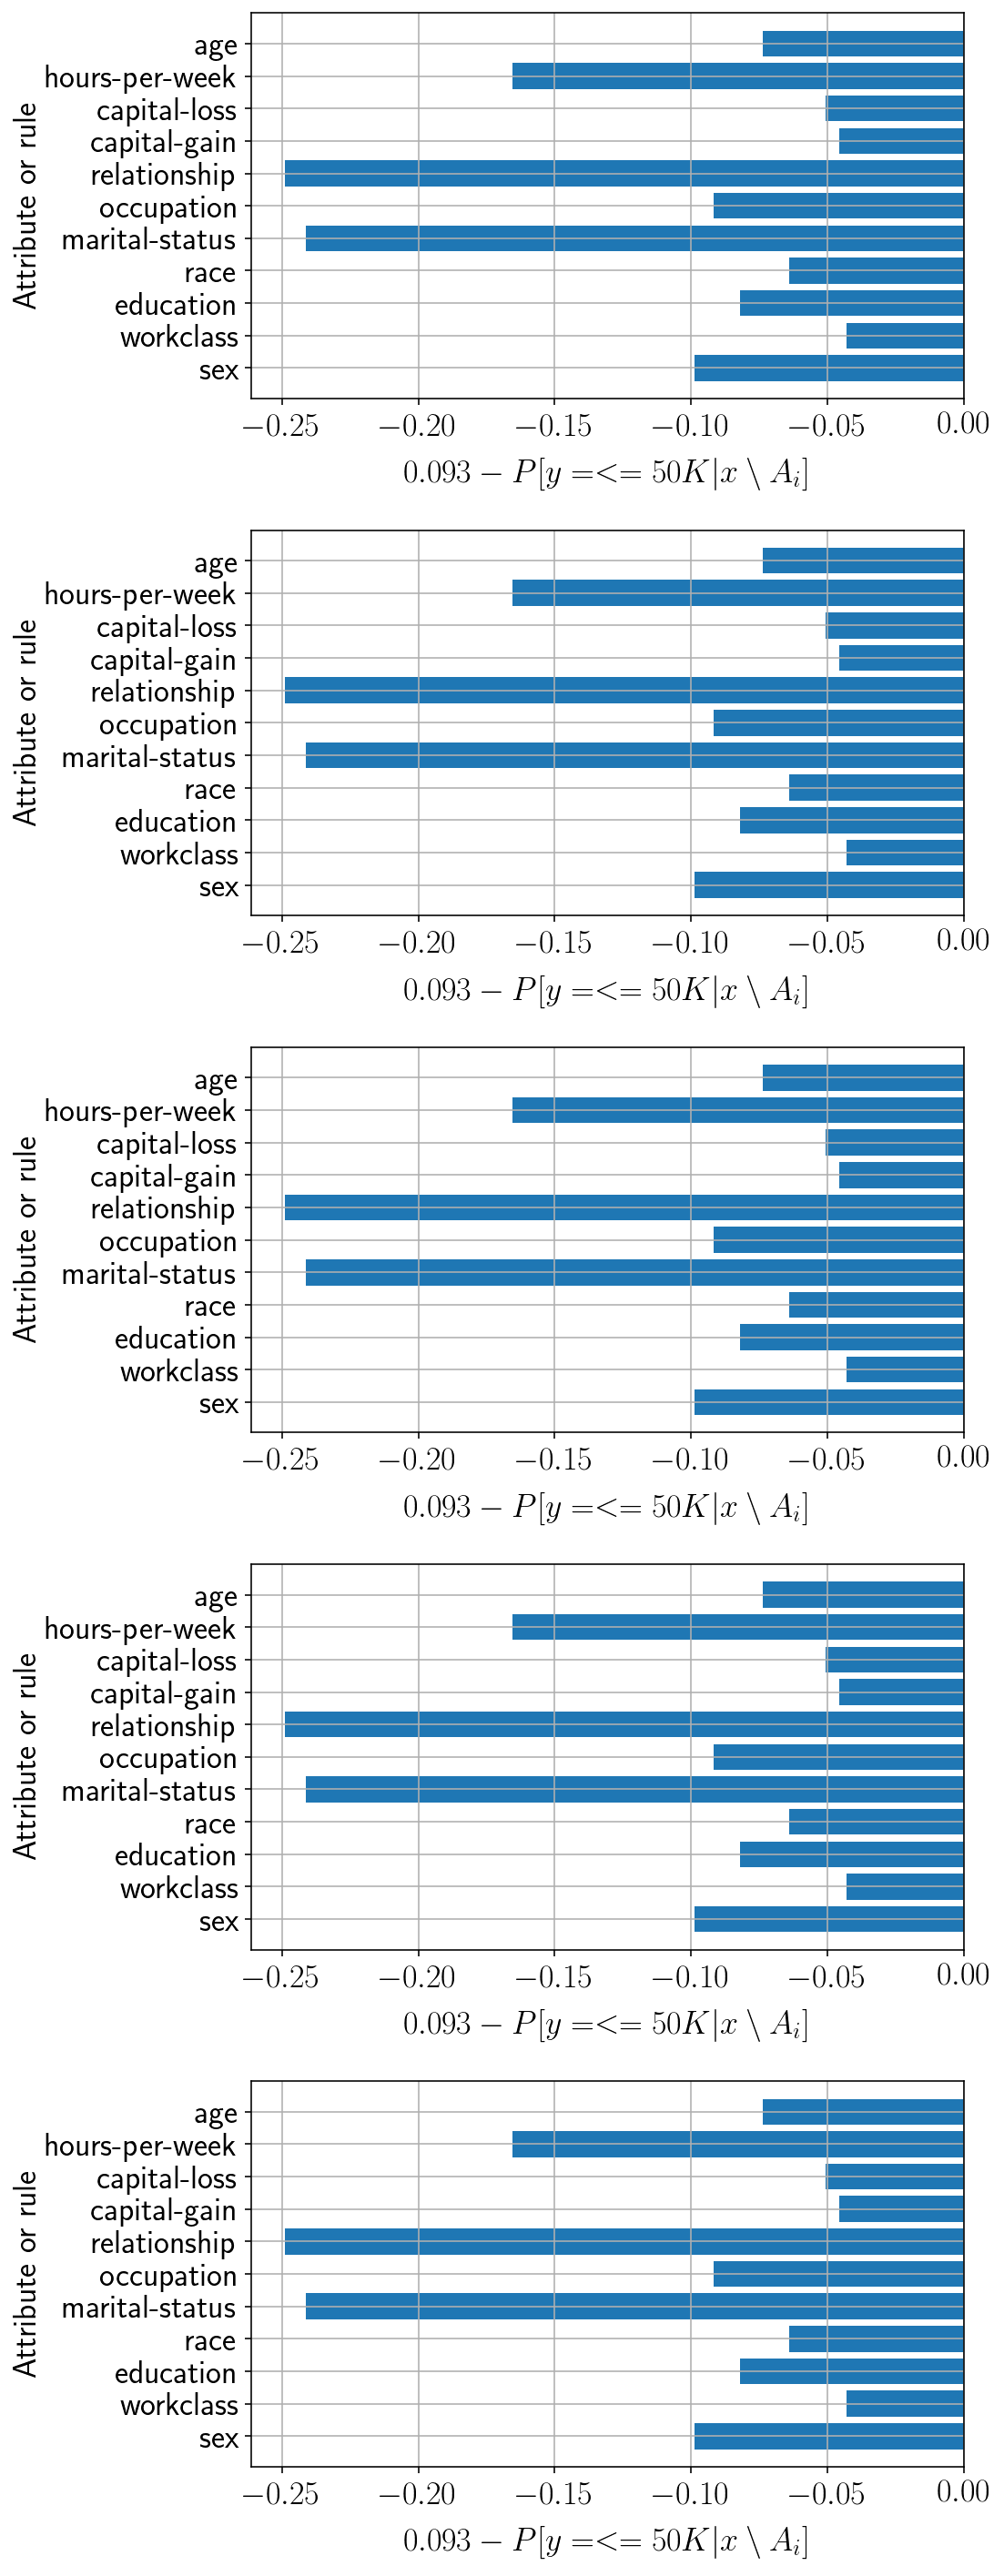

In [19]:
def run(i):
    def plot(ax, e, min_sup):
        attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
        values = [f"{k}={v}" for k,v in (e['instance'].items())]

        ax.set_ylabel("Attribute or rule", labelpad=2)
        ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)

        ax.grid(True)

        ax.barh(
            attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
            width=e['diff_single'] + list(e['map_difference'].values())
        )
        
        
    print(f"Instance {i}")
    min_sups = [0.010, 0.050, 0.100, 0.500, 1.000]
    fig, axes = plt.subplots(len(min_sups), 1, figsize=(8, len(min_sups)*4))
    
    for ax_ix,min_sup in enumerate(min_sups):
        plot(
            axes[ax_ix],
            get_explanation(i, join(DEFAULT_DIR, "datasets/adult_d.arff"), "sklearn_nb", min_sup),
            min_sup
        )
    
    plt.tight_layout()
    plt.show()

run(4)